In [155]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import preprocessing
from numpy import mean
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [156]:
import warnings
warnings.filterwarnings('ignore')

## Import data and preprocess

Create separate dataframes for each year of output since 2017. The final model can then learn off of 5 years of data before making its predictions for 2022. 
#### Let's get this shit

In [157]:
rb_fp = pd.read_csv('rb_fantasy3.csv')
wr_fp = pd.read_csv('wr_fantasy3.csv')
te_fp = pd.read_csv('te_fantasy3.csv')
fp_df = rb_fp.append(wr_fp.append(te_fp))
fp_df

,Full Name,Position,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),Games (2014),Games (2015),Games (2016),Games (2017),Games (2018),Games (2019),Games (2020),Games (2021)
0,A.J. Dillon,RB,24.1,-,-,-,-,-,-,3.6636,10.9176,-,-,-,-,-,-,11,17
1,Aaron Jones,RB,27.5,-,-,-,8,14.3,19.7,18.4929,15.2667,-,-,-,10,12,16,14,15
2,Aaron Ripkowski,RB,29.4,-,2.8,4.7,1.1,-,-,-,-,-,1,10,11,-,-,-,-
3,Adrian Peterson,RB,37.2,11.3,16.3,3,7.9,11.8,9.8,7.7812,6.65,1,16,3,10,16,15,16,4
4,Ahmad Bradshaw,RB,36.2,15.4,7.1,-,-,-,-,-,-,10,6,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,Zach Ertz,TE,31.5,9,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,16,15,14,14,16,15,11,17
301,Zach Gentry,TE,25.7,-,-,-,-,-,1.4,0,2.1,-,-,-,-,-,1,2,17
302,Zach Miller,TE,37.6,-,8.3,12,7,-,-,-,-,-,13,10,8,-,-,-,-
303,Zach Miller,TE,36.5,4.5,-,-,-,-,-,-,-,3,-,-,-,-,-,-,-


In [158]:
fp_df['rb?'] = np.where(fp_df['Position'] == 'RB',1,0)
fp_df['wr?'] = np.where(fp_df['Position'] == 'WR',1,0)
fp_df['te?'] = np.where(fp_df['Position'] == 'TE',1,0)
fp_df

,Full Name,Position,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),...,Games (2015),Games (2016),Games (2017),Games (2018),Games (2019),Games (2020),Games (2021),rb?,wr?,te?
0,A.J. Dillon,RB,24.1,-,-,-,-,-,-,3.6636,...,-,-,-,-,-,11,17,1,0,0
1,Aaron Jones,RB,27.5,-,-,-,8,14.3,19.7,18.4929,...,-,-,10,12,16,14,15,1,0,0
2,Aaron Ripkowski,RB,29.4,-,2.8,4.7,1.1,-,-,-,...,1,10,11,-,-,-,-,1,0,0
3,Adrian Peterson,RB,37.2,11.3,16.3,3,7.9,11.8,9.8,7.7812,...,16,3,10,16,15,16,4,1,0,0
4,Ahmad Bradshaw,RB,36.2,15.4,7.1,-,-,-,-,-,...,6,-,-,-,-,-,-,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,Zach Ertz,TE,31.5,9,11.4,13.1,14.5,17.5,14.2,7.0455,...,15,14,14,16,15,11,17,0,0,1
301,Zach Gentry,TE,25.7,-,-,-,-,-,1.4,0,...,-,-,-,-,1,2,17,0,0,1
302,Zach Miller,TE,37.6,-,8.3,12,7,-,-,-,...,13,10,8,-,-,-,-,0,0,1
303,Zach Miller,TE,36.5,4.5,-,-,-,-,-,-,...,-,-,-,-,-,-,-,0,0,1


In [159]:
fp_clean = fp_df.replace('-',np.nan).set_index('Full Name').drop(columns=['Position'])
fp_final_df = fp_clean.apply(lambda x: pd.to_numeric(x))
fp_final_df

,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),Games (2014),Games (2015),Games (2016),Games (2017),Games (2018),Games (2019),Games (2020),Games (2021),rb?,wr?,te?
Full Name,,,,,,,,,,,,,,,,,,,,
A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,10.9176,NaN,NaN,NaN,NaN,NaN,NaN,11.0,17.0,1,0,0
Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,15.2667,NaN,NaN,NaN,10.0,12.0,16.0,14.0,15.0,1,0,0
Aaron Ripkowski,29.4,NaN,2.8,4.7,1.1,NaN,NaN,NaN,NaN,NaN,1.0,10.0,11.0,NaN,NaN,NaN,NaN,1,0,0
Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,6.6500,1.0,16.0,3.0,10.0,16.0,15.0,16.0,4.0,1,0,0
Ahmad Bradshaw,36.2,15.4,7.1,NaN,NaN,NaN,NaN,NaN,NaN,10.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,16.0,15.0,14.0,14.0,16.0,15.0,11.0,17.0,0,0,1
Zach Gentry,25.7,NaN,NaN,NaN,NaN,NaN,1.4,0.0000,2.1000,NaN,NaN,NaN,NaN,NaN,1.0,2.0,17.0,0,0,1
Zach Miller,37.6,NaN,8.3,12.0,7.0,NaN,NaN,NaN,NaN,NaN,13.0,10.0,8.0,NaN,NaN,NaN,NaN,0,0,1


In [160]:
fp_final_df['fpts_2014'] = fp_final_df['Fantasy Points Per Game (2014)'] * fp_final_df['Games (2014)']
fp_final_df['fpts_2015'] = fp_final_df['Fantasy Points Per Game (2015)'] * fp_final_df['Games (2015)']
fp_final_df['fpts_2016'] = fp_final_df['Fantasy Points Per Game (2016)'] * fp_final_df['Games (2016)']
fp_final_df['fpts_2017'] = fp_final_df['Fantasy Points Per Game (2017)'] * fp_final_df['Games (2017)']
fp_final_df['fpts_2018'] = fp_final_df['Fantasy Points Per Game (2018)'] * fp_final_df['Games (2018)']
fp_final_df['fpts_2019'] = fp_final_df['Fantasy Points Per Game (2019)'] * fp_final_df['Games (2019)']
fp_final_df['fpts_2020'] = fp_final_df['Fantasy Points Per Game (2020)'] * fp_final_df['Games (2020)']
fp_final_df['fpts_2021'] = fp_final_df['Fantasy Points Per Game (2021)'] * fp_final_df['Games (2021)']
fp_final_df.reset_index()

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),...,wr?,te?,fpts_2014,fpts_2015,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,fpts_2021
0,A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,10.9176,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,40.2996,185.5992
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,15.2667,...,0,0,NaN,NaN,NaN,80.0,171.6,315.2,258.9006,229.0005
2,Aaron Ripkowski,29.4,NaN,2.8,4.7,1.1,NaN,NaN,NaN,NaN,...,0,0,NaN,2.8,47.0,12.1,NaN,NaN,NaN,NaN
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,6.6500,...,0,0,11.3,260.8,9.0,79.0,188.8,147.0,124.4992,26.6000
4,Ahmad Bradshaw,36.2,15.4,7.1,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,154.0,42.6,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,...,0,1,144.0,171.0,183.4,203.0,280.0,213.0,77.5005,180.6998
1294,Zach Gentry,25.7,NaN,NaN,NaN,NaN,NaN,1.4,0.0000,2.1000,...,0,1,NaN,NaN,NaN,NaN,NaN,1.4,0.0000,35.7000
1295,Zach Miller,37.6,NaN,8.3,12.0,7.0,NaN,NaN,NaN,NaN,...,0,1,NaN,107.9,120.0,56.0,NaN,NaN,NaN,NaN
1296,Zach Miller,36.5,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,13.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [161]:
rb_dc = pd.read_csv('rb_dc.csv')
wr_dc = pd.read_csv('wr_dc.csv')
te_dc = pd.read_csv('te_dc.csv')

dc_df = rb_dc.append(wr_dc.append(te_dc))
dc_df

,Full Name,Position,Draft Pick,College Dominator Rating,Breakout Age
0,A.J. Dillon,RB,2.30,34.8%,19.3
1,Aaron Green,RB,Undrafted,18.7%,20.9
2,Aaron Jones,RB,5.39,47.0%,18.8
3,Aaron Ripkowski,RB,6.30,3.9%,-
4,Abram Smith,RB,Undrafted,25.5%,23
...,...,...,...,...,...
458,Xavier Grimble,TE,Undrafted,13.1%,-
459,Zach Ertz,TE,2.03,31.8%,21.8
460,Zach Gentry,TE,5.03,15.6%,-
461,Zach Miller,TE,2.06,18.1%,20.7


In [162]:
dc_df['cdr'] = dc_df['College Dominator Rating'].str.strip('%')
dc_df

,Full Name,Position,Draft Pick,College Dominator Rating,Breakout Age,cdr
0,A.J. Dillon,RB,2.30,34.8%,19.3,34.8
1,Aaron Green,RB,Undrafted,18.7%,20.9,18.7
2,Aaron Jones,RB,5.39,47.0%,18.8,47.0
3,Aaron Ripkowski,RB,6.30,3.9%,-,3.9
4,Abram Smith,RB,Undrafted,25.5%,23,25.5
...,...,...,...,...,...,...
458,Xavier Grimble,TE,Undrafted,13.1%,-,13.1
459,Zach Ertz,TE,2.03,31.8%,21.8,31.8
460,Zach Gentry,TE,5.03,15.6%,-,15.6
461,Zach Miller,TE,2.06,18.1%,20.7,18.1


In [163]:
dc_df['drafted'] = np.where(dc_df['Draft Pick'] != 'Undrafted', 1, 0)
dc_df

,Full Name,Position,Draft Pick,College Dominator Rating,Breakout Age,cdr,drafted
0,A.J. Dillon,RB,2.30,34.8%,19.3,34.8,1
1,Aaron Green,RB,Undrafted,18.7%,20.9,18.7,0
2,Aaron Jones,RB,5.39,47.0%,18.8,47.0,1
3,Aaron Ripkowski,RB,6.30,3.9%,-,3.9,1
4,Abram Smith,RB,Undrafted,25.5%,23,25.5,0
...,...,...,...,...,...,...,...
458,Xavier Grimble,TE,Undrafted,13.1%,-,13.1,0
459,Zach Ertz,TE,2.03,31.8%,21.8,31.8,1
460,Zach Gentry,TE,5.03,15.6%,-,15.6,1
461,Zach Miller,TE,2.06,18.1%,20.7,18.1,1


In [164]:
dc_df_clean = dc_df[['Draft Pick','Breakout Age','cdr','drafted']].set_index(dc_df['Full Name']
                                                                            ).replace({'Undrafted':np.nan,
                                                                                    '-':np.nan,
                                                                                      'Supplemental (2nd)':2.50}
                                                                                     ).apply(lambda x: 
                                                                                             pd.to_numeric(x))
dc_df_final = dc_df_clean.reset_index()
dc_df_final

,Full Name,Draft Pick,Breakout Age,cdr,drafted
0,A.J. Dillon,2.30,19.3,34.8,1
1,Aaron Green,NaN,20.9,18.7,0
2,Aaron Jones,5.39,18.8,47.0,1
3,Aaron Ripkowski,6.30,NaN,3.9,1
4,Abram Smith,NaN,23.0,25.5,0
...,...,...,...,...,...
2272,Xavier Grimble,NaN,NaN,13.1,0
2273,Zach Ertz,2.03,21.8,31.8,1
2274,Zach Gentry,5.03,NaN,15.6,1
2275,Zach Miller,2.06,20.7,18.1,1


In [165]:
full_data = fp_final_df.merge(dc_df_final,on='Full Name',how='inner')
full_data

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),...,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,fpts_2021,Draft Pick,Breakout Age,cdr,drafted
0,A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,10.9176,...,NaN,NaN,NaN,NaN,40.2996,185.5992,2.30,19.3,34.8,1
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,15.2667,...,NaN,80.0,171.6,315.2,258.9006,229.0005,5.39,18.8,47.0,1
2,Aaron Ripkowski,29.4,NaN,2.8,4.7,1.1,NaN,NaN,NaN,NaN,...,47.0,12.1,NaN,NaN,NaN,NaN,6.30,NaN,3.9,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,6.6500,...,9.0,79.0,188.8,147.0,124.4992,26.6000,1.07,19.5,42.7,1
4,Ahmad Bradshaw,36.2,15.4,7.1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.40,18.5,46.3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,...,183.4,203.0,280.0,213.0,77.5005,180.6998,2.03,21.8,31.8,1
1252,Zach Gentry,25.7,NaN,NaN,NaN,NaN,NaN,1.4,0.0000,2.1000,...,NaN,NaN,NaN,1.4,0.0000,35.7000,5.03,NaN,15.6,1
1253,Zach Miller,37.6,NaN,8.3,12.0,7.0,NaN,NaN,NaN,NaN,...,120.0,56.0,NaN,NaN,NaN,NaN,2.06,20.7,18.1,1
1254,Zach Miller,36.5,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.06,20.7,18.1,1


In [166]:
full_data.columns

Index(['Full Name', 'Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)',
       'Fantasy Points Per Game (2017)', 'Fantasy Points Per Game (2018)',
       'Fantasy Points Per Game (2019)', 'Fantasy Points Per Game (2020)',
       'Fantasy Points Per Game (2021)', 'Games (2014)', 'Games (2015)',
       'Games (2016)', 'Games (2017)', 'Games (2018)', 'Games (2019)',
       'Games (2020)', 'Games (2021)', 'rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016', 'fpts_2017', 'fpts_2018', 'fpts_2019',
       'fpts_2020', 'fpts_2021', 'Draft Pick', 'Breakout Age', 'cdr',
       'drafted'],
      dtype='object')

In [380]:
final_data = pd.DataFrame()
final_data_id = pd.DataFrame()

### 2017 predictions

In [381]:
fp_2017 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2017)'])
fp_2017

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Games (2014),Games (2015),Games (2016),rb?,wr?,te?,fpts_2014,fpts_2015,fpts_2016,fpts_2017,Draft Pick,Breakout Age,cdr,drafted
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,NaN,NaN,NaN,1,0,0,NaN,NaN,NaN,80.0,5.39,18.8,47.0,1
2,Aaron Ripkowski,29.4,NaN,2.8,4.7,1.1,NaN,1.0,10.0,1,0,0,NaN,2.8,47.0,12.1,6.30,NaN,3.9,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,1.0,16.0,3.0,1,0,0,11.3,260.8,9.0,79.0,1.07,19.5,42.7,1
5,Akeem Hunt,29.3,NaN,2.8,2.1,0.7,NaN,7.0,8.0,1,0,0,NaN,19.6,16.8,9.8,NaN,20.5,27.1,0
7,Alex Armah,28.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1,0,0,NaN,NaN,NaN,0.0,6.08,NaN,3.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,Virgil Green,33.8,3.9,3.2,5.2,3.6,5.0,11.0,10.0,0,0,1,19.5,35.2,52.0,39.6,7.01,21.1,19.5,1
1249,Will Tye,30.6,NaN,8.0,5.8,3.9,NaN,13.0,16.0,0,0,1,NaN,104.0,92.8,7.8,NaN,21.8,36.1,0
1250,Xavier Grimble,29.7,NaN,NaN,4.3,2.4,NaN,NaN,8.0,0,0,1,NaN,NaN,34.4,14.4,NaN,NaN,13.1,0
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,16.0,15.0,14.0,0,0,1,144.0,171.0,183.4,203.0,2.03,21.8,31.8,1


In [382]:
fp_2017['y'] = np.where(fp_2017['fpts_2017'] > 200,1,0)
fp_2017['y'].value_counts()

0    438
1     33
Name: y, dtype: int64

In [383]:
fpts_df_2017 = fp_2017[['fpts_2014','fpts_2015', 'fpts_2016']]

In [384]:
injury_df_2017 = fp_2017[['Games (2014)','Games (2015)','Games (2016)']]

In [385]:
fppg_df_2017 = fp_2017[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)']]

In [386]:
df_2017 = fp_2017[['y','rb?','te?']]
df_2017

,y,rb?,te?
1,0,1,0
2,0,1,0
3,0,1,0
5,0,1,0
7,0,1,0
...,...,...,...
1247,0,0,1
1249,0,0,1
1250,0,0,1
1251,1,0,1


In [387]:
df_2017['age'] = fp_2017['Age'] - 5
df_2017

,y,rb?,te?,age
1,0,1,0,22.5
2,0,1,0,24.4
3,0,1,0,32.2
5,0,1,0,24.3
7,0,1,0,23.0
...,...,...,...,...
1247,0,0,1,28.8
1249,0,0,1,25.6
1250,0,0,1,24.7
1251,1,0,1,26.5


In [388]:
df_2017['max_pts'] = fpts_df_2017.max(axis=1)
df_2017

,y,rb?,te?,age,max_pts
1,0,1,0,22.5,NaN
2,0,1,0,24.4,47.0
3,0,1,0,32.2,260.8
5,0,1,0,24.3,19.6
7,0,1,0,23.0,NaN
...,...,...,...,...,...
1247,0,0,1,28.8,52.0
1249,0,0,1,25.6,104.0
1250,0,0,1,24.7,34.4
1251,1,0,1,26.5,183.4


In [389]:
df_2017['avg_pts'] = fpts_df_2017.mean(axis=1)
df_2017

,y,rb?,te?,age,max_pts,avg_pts
1,0,1,0,22.5,NaN,NaN
2,0,1,0,24.4,47.0,24.900000
3,0,1,0,32.2,260.8,93.700000
5,0,1,0,24.3,19.6,18.200000
7,0,1,0,23.0,NaN,NaN
...,...,...,...,...,...,...
1247,0,0,1,28.8,52.0,35.566667
1249,0,0,1,25.6,104.0,98.400000
1250,0,0,1,24.7,34.4,34.400000
1251,1,0,1,26.5,183.4,166.133333


In [390]:
df_2017['last_pts'] = fpts_df_2017['fpts_2016']
df_2017

,y,rb?,te?,age,max_pts,avg_pts,last_pts
1,0,1,0,22.5,NaN,NaN,NaN
2,0,1,0,24.4,47.0,24.900000,47.0
3,0,1,0,32.2,260.8,93.700000,9.0
5,0,1,0,24.3,19.6,18.200000,16.8
7,0,1,0,23.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1247,0,0,1,28.8,52.0,35.566667,52.0
1249,0,0,1,25.6,104.0,98.400000,92.8
1250,0,0,1,24.7,34.4,34.400000,34.4
1251,1,0,1,26.5,183.4,166.133333,183.4


In [391]:
df_2017['3_yr_trail_avg_fppg'] = fppg_df_2017.mean(axis=1)
df_2017

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg
1,0,1,0,22.5,NaN,NaN,NaN,NaN
2,0,1,0,24.4,47.0,24.900000,47.0,3.750000
3,0,1,0,32.2,260.8,93.700000,9.0,10.200000
5,0,1,0,24.3,19.6,18.200000,16.8,2.450000
7,0,1,0,23.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,52.0,35.566667,52.0,4.100000
1249,0,0,1,25.6,104.0,98.400000,92.8,6.900000
1250,0,0,1,24.7,34.4,34.400000,34.4,4.300000
1251,1,0,1,26.5,183.4,166.133333,183.4,11.166667


In [392]:
df_2017['injury_risk'] = injury_df_2017.sum(axis = 1) / (injury_df_2017.count(axis=1)*16)
df_2017

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk
1,0,1,0,22.5,NaN,NaN,NaN,NaN,NaN
2,0,1,0,24.4,47.0,24.900000,47.0,3.750000,0.343750
3,0,1,0,32.2,260.8,93.700000,9.0,10.200000,0.416667
5,0,1,0,24.3,19.6,18.200000,16.8,2.450000,0.468750
7,0,1,0,23.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,52.0,35.566667,52.0,4.100000,0.541667
1249,0,0,1,25.6,104.0,98.400000,92.8,6.900000,0.906250
1250,0,0,1,24.7,34.4,34.400000,34.4,4.300000,0.500000
1251,1,0,1,26.5,183.4,166.133333,183.4,11.166667,0.937500


In [393]:
df_2017['last_yr_games_played'] = injury_df_2017['Games (2016)']
df_2017

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played
1,0,1,0,22.5,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1,0,24.4,47.0,24.900000,47.0,3.750000,0.343750,10.0
3,0,1,0,32.2,260.8,93.700000,9.0,10.200000,0.416667,3.0
5,0,1,0,24.3,19.6,18.200000,16.8,2.450000,0.468750,8.0
7,0,1,0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,52.0,35.566667,52.0,4.100000,0.541667,10.0
1249,0,0,1,25.6,104.0,98.400000,92.8,6.900000,0.906250,16.0
1250,0,0,1,24.7,34.4,34.400000,34.4,4.300000,0.500000,8.0
1251,1,0,1,26.5,183.4,166.133333,183.4,11.166667,0.937500,14.0


In [394]:
df_2017['hit_rate'] = fpts_df_2017[fpts_df_2017 > 200].count(axis = 1) / fpts_df_2017.count(axis=1)
df_2017

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate
1,0,1,0,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1,0,24.4,47.0,24.900000,47.0,3.750000,0.343750,10.0,0.000000
3,0,1,0,32.2,260.8,93.700000,9.0,10.200000,0.416667,3.0,0.333333
5,0,1,0,24.3,19.6,18.200000,16.8,2.450000,0.468750,8.0,0.000000
7,0,1,0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,52.0,35.566667,52.0,4.100000,0.541667,10.0,0.000000
1249,0,0,1,25.6,104.0,98.400000,92.8,6.900000,0.906250,16.0,0.000000
1250,0,0,1,24.7,34.4,34.400000,34.4,4.300000,0.500000,8.0,0.000000
1251,1,0,1,26.5,183.4,166.133333,183.4,11.166667,0.937500,14.0,0.000000


In [395]:
df_2017['Draft Pick'] = fp_2017['Draft Pick']
df_2017['Breakout Age'] = fp_2017['Breakout Age']
df_2017['cdr'] = fp_2017['cdr']
df_2017

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr
1,0,1,0,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.39,18.8,47.0
2,0,1,0,24.4,47.0,24.900000,47.0,3.750000,0.343750,10.0,0.000000,6.30,NaN,3.9
3,0,1,0,32.2,260.8,93.700000,9.0,10.200000,0.416667,3.0,0.333333,1.07,19.5,42.7
5,0,1,0,24.3,19.6,18.200000,16.8,2.450000,0.468750,8.0,0.000000,NaN,20.5,27.1
7,0,1,0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.08,NaN,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,52.0,35.566667,52.0,4.100000,0.541667,10.0,0.000000,7.01,21.1,19.5
1249,0,0,1,25.6,104.0,98.400000,92.8,6.900000,0.906250,16.0,0.000000,NaN,21.8,36.1
1250,0,0,1,24.7,34.4,34.400000,34.4,4.300000,0.500000,8.0,0.000000,NaN,NaN,13.1
1251,1,0,1,26.5,183.4,166.133333,183.4,11.166667,0.937500,14.0,0.000000,2.03,21.8,31.8


In [396]:
df_2017_id = df_2017.copy()
df_2017_id['id'] = fp_2017['Full Name']
df_2017_id['year'] = 2017
df_2017_id

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,0,1,0,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.39,18.8,47.0,Aaron Jones,2017
2,0,1,0,24.4,47.0,24.900000,47.0,3.750000,0.343750,10.0,0.000000,6.30,NaN,3.9,Aaron Ripkowski,2017
3,0,1,0,32.2,260.8,93.700000,9.0,10.200000,0.416667,3.0,0.333333,1.07,19.5,42.7,Adrian Peterson,2017
5,0,1,0,24.3,19.6,18.200000,16.8,2.450000,0.468750,8.0,0.000000,NaN,20.5,27.1,Akeem Hunt,2017
7,0,1,0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.08,NaN,3.2,Alex Armah,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,52.0,35.566667,52.0,4.100000,0.541667,10.0,0.000000,7.01,21.1,19.5,Virgil Green,2017
1249,0,0,1,25.6,104.0,98.400000,92.8,6.900000,0.906250,16.0,0.000000,NaN,21.8,36.1,Will Tye,2017
1250,0,0,1,24.7,34.4,34.400000,34.4,4.300000,0.500000,8.0,0.000000,NaN,NaN,13.1,Xavier Grimble,2017
1251,1,0,1,26.5,183.4,166.133333,183.4,11.166667,0.937500,14.0,0.000000,2.03,21.8,31.8,Zach Ertz,2017


In [397]:
final_data = final_data.append(df_2017)
final_data

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr
1,0,1,0,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.39,18.8,47.0
2,0,1,0,24.4,47.0,24.900000,47.0,3.750000,0.343750,10.0,0.000000,6.30,NaN,3.9
3,0,1,0,32.2,260.8,93.700000,9.0,10.200000,0.416667,3.0,0.333333,1.07,19.5,42.7
5,0,1,0,24.3,19.6,18.200000,16.8,2.450000,0.468750,8.0,0.000000,NaN,20.5,27.1
7,0,1,0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.08,NaN,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,52.0,35.566667,52.0,4.100000,0.541667,10.0,0.000000,7.01,21.1,19.5
1249,0,0,1,25.6,104.0,98.400000,92.8,6.900000,0.906250,16.0,0.000000,NaN,21.8,36.1
1250,0,0,1,24.7,34.4,34.400000,34.4,4.300000,0.500000,8.0,0.000000,NaN,NaN,13.1
1251,1,0,1,26.5,183.4,166.133333,183.4,11.166667,0.937500,14.0,0.000000,2.03,21.8,31.8


In [398]:
final_data_id = final_data_id.append(df_2017_id)
final_data_id

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,0,1,0,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.39,18.8,47.0,Aaron Jones,2017
2,0,1,0,24.4,47.0,24.900000,47.0,3.750000,0.343750,10.0,0.000000,6.30,NaN,3.9,Aaron Ripkowski,2017
3,0,1,0,32.2,260.8,93.700000,9.0,10.200000,0.416667,3.0,0.333333,1.07,19.5,42.7,Adrian Peterson,2017
5,0,1,0,24.3,19.6,18.200000,16.8,2.450000,0.468750,8.0,0.000000,NaN,20.5,27.1,Akeem Hunt,2017
7,0,1,0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.08,NaN,3.2,Alex Armah,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,28.8,52.0,35.566667,52.0,4.100000,0.541667,10.0,0.000000,7.01,21.1,19.5,Virgil Green,2017
1249,0,0,1,25.6,104.0,98.400000,92.8,6.900000,0.906250,16.0,0.000000,NaN,21.8,36.1,Will Tye,2017
1250,0,0,1,24.7,34.4,34.400000,34.4,4.300000,0.500000,8.0,0.000000,NaN,NaN,13.1,Xavier Grimble,2017
1251,1,0,1,26.5,183.4,166.133333,183.4,11.166667,0.937500,14.0,0.000000,2.03,21.8,31.8,Zach Ertz,2017


### 2018

In [399]:
fp_2018 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2018)'])
fp_2018

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Games (2014),Games (2015),Games (2016),...,te?,fpts_2014,fpts_2015,fpts_2016,fpts_2017,fpts_2018,Draft Pick,Breakout Age,cdr,drafted
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,NaN,NaN,NaN,...,0,NaN,NaN,NaN,80.0,171.6,5.39,18.8,47.0,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,1.0,16.0,3.0,...,0,11.3,260.8,9.0,79.0,188.8,1.07,19.5,42.7,1
7,Alex Armah,28.0,NaN,NaN,NaN,0.0,1.9,NaN,NaN,NaN,...,0,NaN,NaN,NaN,0.0,15.2,6.08,NaN,3.2,1
8,Alex Collins,27.8,NaN,NaN,4.0,11.4,10.9,NaN,NaN,9.0,...,0,NaN,NaN,36.0,171.0,109.0,5.34,19.0,29.9,1
11,Alfred Blue,31.1,6.1,8.0,4.4,5.6,6.1,16.0,14.0,14.0,...,0,97.6,112.0,61.6,44.8,97.6,6.05,21.4,14.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,Vernon Davis,38.3,4.8,6.0,7.6,7.6,5.7,13.0,13.0,15.0,...,1,62.4,78.0,114.0,121.6,74.1,1.06,21.6,35.9,1
1247,Virgil Green,33.8,3.9,3.2,5.2,3.6,3.3,5.0,11.0,10.0,...,1,19.5,35.2,52.0,39.6,46.2,7.01,21.1,19.5,1
1248,Will Dissly,25.9,NaN,NaN,NaN,NaN,8.9,NaN,NaN,NaN,...,1,NaN,NaN,NaN,NaN,35.6,4.20,NaN,10.3,1
1250,Xavier Grimble,29.7,NaN,NaN,4.3,2.4,1.6,NaN,NaN,8.0,...,1,NaN,NaN,34.4,14.4,12.8,NaN,NaN,13.1,0


In [400]:
fp_2018['y'] = np.where(fp_2018['fpts_2018'] > 200,1,0)
fp_2018['y'].value_counts()

0    451
1     40
Name: y, dtype: int64

In [401]:
fpts_df_2018 = fp_2018[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017']]

injury_df_2018 = fp_2018[['Games (2014)','Games (2015)','Games (2016)','Games (2017)']]

fppg_df_2018 = fp_2018[['Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)']]

df_2018 = fp_2018[['y','rb?','te?']]


df_2018['age'] = fp_2018['Age'] - 4


df_2018['max_pts'] = fpts_df_2018.max(axis=1)


df_2018['avg_pts'] = fpts_df_2018.mean(axis=1)


df_2018['last_pts'] = fpts_df_2018['fpts_2017']


df_2018['3_yr_trail_avg_fppg'] = fppg_df_2018.mean(axis=1)


df_2018['injury_risk'] = injury_df_2018.sum(axis = 1) / (injury_df_2018.count(axis=1)*16)


df_2018['last_yr_games_played'] = injury_df_2018['Games (2017)']


df_2018['hit_rate'] = fpts_df_2018[fpts_df_2018 > 200].count(axis = 1) / fpts_df_2018.count(axis=1)


df_2018['Draft Pick'] = fp_2018['Draft Pick']
df_2018['Breakout Age'] = fp_2018['Breakout Age']
df_2018['cdr'] = fp_2018['cdr']

df_2018_id = df_2018.copy()
df_2018_id['id'] = fp_2018['Full Name']
df_2018_id['year'] = 2018
df_2018_id


final_data = final_data.append(df_2018)
final_data

final_data_id = final_data_id.append(df_2018_id)
final_data_id

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,0,1,0,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.39,18.8,47.0,Aaron Jones,2017
2,0,1,0,24.4,47.0,24.900,47.0,3.750000,0.343750,10.0,0.000000,6.30,NaN,3.9,Aaron Ripkowski,2017
3,0,1,0,32.2,260.8,93.700,9.0,10.200000,0.416667,3.0,0.333333,1.07,19.5,42.7,Adrian Peterson,2017
5,0,1,0,24.3,19.6,18.200,16.8,2.450000,0.468750,8.0,0.000000,NaN,20.5,27.1,Akeem Hunt,2017
7,0,1,0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.08,NaN,3.2,Alex Armah,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,0,0,1,34.3,121.6,94.000,121.6,7.066667,0.890625,16.0,0.000000,1.06,21.6,35.9,Vernon Davis,2018
1247,0,0,1,29.8,52.0,36.575,39.6,4.000000,0.578125,11.0,0.000000,7.01,21.1,19.5,Virgil Green,2018
1248,0,0,1,21.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.20,NaN,10.3,Will Dissly,2018
1250,0,0,1,25.7,34.4,24.400,14.4,3.350000,0.437500,6.0,0.000000,NaN,NaN,13.1,Xavier Grimble,2018


### 2019

In [402]:
fp_2019 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2019)'])
fp_2019

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Games (2014),Games (2015),...,fpts_2014,fpts_2015,fpts_2016,fpts_2017,fpts_2018,fpts_2019,Draft Pick,Breakout Age,cdr,drafted
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,NaN,NaN,...,NaN,NaN,NaN,80.0,171.6,315.2,5.39,18.8,47.0,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,1.0,16.0,...,11.3,260.8,9.0,79.0,188.8,147.0,1.07,19.5,42.7,1
6,Alec Ingold,25.9,NaN,NaN,NaN,NaN,NaN,1.6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.6,NaN,NaN,10.1,0
7,Alex Armah,28.0,NaN,NaN,NaN,0.0,1.9,1.2,NaN,NaN,...,NaN,NaN,NaN,0.0,15.2,9.6,6.08,NaN,3.2,1
9,Alexander Mattison,23.9,NaN,NaN,NaN,NaN,NaN,5.3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,68.9,3.38,19.2,28.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,Virgil Green,33.8,3.9,3.2,5.2,3.6,3.3,1.9,5.0,11.0,...,19.5,35.2,52.0,39.6,46.2,22.8,7.01,21.1,19.5,1
1248,Will Dissly,25.9,NaN,NaN,NaN,NaN,8.9,12.3,NaN,NaN,...,NaN,NaN,NaN,NaN,35.6,73.8,4.20,NaN,10.3,1
1250,Xavier Grimble,29.7,NaN,NaN,4.3,2.4,1.6,0.6,NaN,NaN,...,NaN,NaN,34.4,14.4,12.8,1.2,NaN,NaN,13.1,0
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,16.0,15.0,...,144.0,171.0,183.4,203.0,280.0,213.0,2.03,21.8,31.8,1


In [403]:
fp_2019['y'] = np.where(fp_2019['fpts_2019'] > 200,1,0)
fp_2019['y'].value_counts()

0    439
1     46
Name: y, dtype: int64

In [404]:
fpts_df_2019 = fp_2019[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018']]

injury_df_2019 = fp_2019[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)']]

fppg_df_2019 = fp_2019[['Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)']]

df_2019 = fp_2019[['y','rb?','te?']]


df_2019['age'] = fp_2019['Age'] - 3


df_2019['max_pts'] = fpts_df_2019.max(axis=1)


df_2019['avg_pts'] = fpts_df_2019.mean(axis=1)


df_2019['last_pts'] = fpts_df_2019['fpts_2018']


df_2019['3_yr_trail_avg_fppg'] = fppg_df_2019.mean(axis=1)


df_2019['injury_risk'] = injury_df_2019.sum(axis = 1) / (injury_df_2019.count(axis=1)*16)


df_2019['last_yr_games_played'] = injury_df_2019['Games (2018)']


df_2019['hit_rate'] = fpts_df_2019[fpts_df_2019 > 200].count(axis = 1) / fpts_df_2019.count(axis=1)


df_2019['Draft Pick'] = fp_2019['Draft Pick']
df_2019['Breakout Age'] = fp_2019['Breakout Age']
df_2019['cdr'] = fp_2019['cdr']

df_2019_id = df_2019.copy()
df_2019_id['id'] = fp_2019['Full Name']
df_2019_id['year'] = 2019
df_2019_id


final_data = final_data.append(df_2019)
final_data

final_data_id = final_data_id.append(df_2019_id)
final_data_id

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,0,1,0,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.39,18.8,47.0,Aaron Jones,2017
2,0,1,0,24.4,47.0,24.900000,47.0,3.750000,0.343750,10.0,0.000000,6.30,NaN,3.9,Aaron Ripkowski,2017
3,0,1,0,32.2,260.8,93.700000,9.0,10.200000,0.416667,3.0,0.333333,1.07,19.5,42.7,Adrian Peterson,2017
5,0,1,0,24.3,19.6,18.200000,16.8,2.450000,0.468750,8.0,0.000000,NaN,20.5,27.1,Akeem Hunt,2017
7,0,1,0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.08,NaN,3.2,Alex Armah,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,0,0,1,30.8,52.0,38.500000,46.2,4.033333,0.637500,14.0,0.000000,7.01,21.1,19.5,Virgil Green,2019
1248,0,0,1,22.9,35.6,35.600000,35.6,8.900000,0.250000,4.0,0.000000,4.20,NaN,10.3,Will Dissly,2019
1250,0,0,1,26.7,34.4,20.533333,12.8,2.766667,0.458333,8.0,0.000000,NaN,NaN,13.1,Xavier Grimble,2019
1251,1,0,1,28.5,280.0,196.280000,280.0,15.033333,0.937500,16.0,0.400000,2.03,21.8,31.8,Zach Ertz,2019


### 2020

In [405]:
fp_2020 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Fantasy Points Per Game (2020)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2020)'])
fp_2020

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Games (2014),...,fpts_2015,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,Draft Pick,Breakout Age,cdr,drafted
0,A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,NaN,...,NaN,NaN,NaN,NaN,NaN,40.2996,2.30,19.3,34.8,1
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,NaN,...,NaN,NaN,80.0,171.6,315.2,258.9006,5.39,18.8,47.0,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,1.0,...,260.8,9.0,79.0,188.8,147.0,124.4992,1.07,19.5,42.7,1
6,Alec Ingold,25.9,NaN,NaN,NaN,NaN,NaN,1.6,2.7000,NaN,...,NaN,NaN,NaN,NaN,17.6,29.7000,NaN,NaN,10.1,0
7,Alex Armah,28.0,NaN,NaN,NaN,0.0,1.9,1.2,0.6000,NaN,...,NaN,NaN,0.0,15.2,9.6,7.2000,6.08,NaN,3.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,Vance McDonald,32.0,0.8,5.8,8.7,4.3,8.9,6.0,1.7786,4.0,...,81.2,87.0,38.7,133.5,84.0,24.9004,2.23,20.2,26.6,1
1247,Virgil Green,33.8,3.9,3.2,5.2,3.6,3.3,1.9,2.3333,5.0,...,35.2,52.0,39.6,46.2,22.8,13.9998,7.01,21.1,19.5,1
1248,Will Dissly,25.9,NaN,NaN,NaN,NaN,8.9,12.3,3.8188,NaN,...,NaN,NaN,NaN,35.6,73.8,61.1008,4.20,NaN,10.3,1
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,16.0,...,171.0,183.4,203.0,280.0,213.0,77.5005,2.03,21.8,31.8,1


In [406]:
fp_2020['y'] = np.where(fp_2020['fpts_2020'] > 200,1,0)
fp_2020['y'].value_counts()

0    500
1     43
Name: y, dtype: int64

In [407]:
fpts_df_2020 = fp_2020[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019']]

injury_df_2020 = fp_2020[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)','Games (2019)']]

fppg_df_2020 = fp_2020[['Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)']]

df_2020 = fp_2020[['y','rb?','te?']]


df_2020['age'] = fp_2020['Age'] - 2


df_2020['max_pts'] = fpts_df_2020.max(axis=1)


df_2020['avg_pts'] = fpts_df_2020.mean(axis=1)


df_2020['last_pts'] = fpts_df_2020['fpts_2019']


df_2020['3_yr_trail_avg_fppg'] = fppg_df_2020.mean(axis=1)


df_2020['injury_risk'] = injury_df_2020.sum(axis = 1) / (injury_df_2020.count(axis=1)*16)


df_2020['last_yr_games_played'] = injury_df_2020['Games (2019)']


df_2020['hit_rate'] = fpts_df_2020[fpts_df_2020 > 200].count(axis = 1) / fpts_df_2020.count(axis=1)


df_2020['Draft Pick'] = fp_2020['Draft Pick']
df_2020['Breakout Age'] = fp_2020['Breakout Age']
df_2020['cdr'] = fp_2020['cdr']

df_2020_id = df_2020.copy()
df_2020_id['id'] = fp_2020['Full Name']
df_2020_id['year'] = 2020
df_2020_id

final_data = final_data.append(df_2020)
final_data

final_data_id = final_data_id.append(df_2020_id)
final_data_id

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,0,1,0,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.39,18.8,47.0,Aaron Jones,2017
2,0,1,0,24.4,47.0,24.900000,47.0,3.750000,0.343750,10.0,0.000000,6.30,NaN,3.9,Aaron Ripkowski,2017
3,0,1,0,32.2,260.8,93.700000,9.0,10.200000,0.416667,3.0,0.333333,1.07,19.5,42.7,Adrian Peterson,2017
5,0,1,0,24.3,19.6,18.200000,16.8,2.450000,0.468750,8.0,0.000000,NaN,20.5,27.1,Akeem Hunt,2017
7,0,1,0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.08,NaN,3.2,Alex Armah,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,0,0,1,30.0,133.5,71.266667,84.0,6.400000,0.687500,14.0,0.000000,2.23,20.2,26.6,Vance McDonald,2020
1247,0,0,1,31.8,52.0,35.883333,22.8,2.933333,0.656250,12.0,0.000000,7.01,21.1,19.5,Virgil Green,2020
1248,0,0,1,23.9,73.8,54.700000,73.8,10.600000,0.312500,6.0,0.000000,4.20,NaN,10.3,Will Dissly,2020
1251,0,0,1,29.5,280.0,199.066667,213.0,15.400000,0.937500,15.0,0.500000,2.03,21.8,31.8,Zach Ertz,2020


### 2021

In [408]:
fp_2021 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','Games (2019)','Games (2020)',
                     'rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','fpts_2021',
                     'Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2021)'])
fp_2021

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),...,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,fpts_2021,Draft Pick,Breakout Age,cdr,drafted
0,A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,10.9176,...,NaN,NaN,NaN,NaN,40.2996,185.5992,2.30,19.3,34.8,1
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,15.2667,...,NaN,80.0,171.6,315.2,258.9006,229.0005,5.39,18.8,47.0,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,6.6500,...,9.0,79.0,188.8,147.0,124.4992,26.6000,1.07,19.5,42.7,1
8,Alex Collins,27.8,NaN,NaN,4.0,11.4,10.9,NaN,7.0333,6.2545,...,36.0,171.0,109.0,NaN,21.0999,68.7995,5.34,19.0,29.9,1
9,Alexander Mattison,23.9,NaN,NaN,NaN,NaN,NaN,5.3,6.6846,7.8688,...,NaN,NaN,NaN,68.9,86.8998,125.9008,3.38,19.2,28.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,Tyler Higbee,29.4,NaN,NaN,2.1,4.3,4.7,11.5,8.5467,9.8000,...,25.2,60.2,65.8,161.0,128.2005,147.0000,4.12,22.7,15.6,1
1243,Tyler Kroft,29.6,NaN,3.7,2.7,8.3,1.5,2.1,4.1900,4.3667,...,18.9,124.5,7.5,18.9,41.9000,39.3003,3.21,20.9,11.5,1
1248,Will Dissly,25.9,NaN,NaN,NaN,NaN,8.9,12.3,3.8188,3.3400,...,NaN,NaN,35.6,73.8,61.1008,50.1000,4.20,NaN,10.3,1
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,...,183.4,203.0,280.0,213.0,77.5005,180.6998,2.03,21.8,31.8,1


In [409]:
fp_2021['y'] = np.where(fp_2021['fpts_2021'] > 200,1,0)
fp_2021['y'].value_counts()

0    503
1     47
Name: y, dtype: int64

In [410]:
fpts_df_2021 = fp_2021[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020']]

injury_df_2021 = fp_2021[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)','Games (2019)',
                         'Games (2020)']]

fppg_df_2021 = fp_2021[['Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)']]

df_2021 = fp_2021[['y','rb?','te?']]


df_2021['age'] = fp_2021['Age'] - 1


df_2021['max_pts'] = fpts_df_2021.max(axis=1)


df_2021['avg_pts'] = fpts_df_2021.mean(axis=1)


df_2021['last_pts'] = fpts_df_2021['fpts_2020']


df_2021['3_yr_trail_avg_fppg'] = fppg_df_2021.mean(axis=1)


df_2021['injury_risk'] = injury_df_2021.sum(axis = 1) / (injury_df_2021.count(axis=1)*16)


df_2021['last_yr_games_played'] = injury_df_2021['Games (2020)']


df_2021['hit_rate'] = fpts_df_2021[fpts_df_2021 > 200].count(axis = 1) / fpts_df_2021.count(axis=1)


df_2021['Draft Pick'] = fp_2021['Draft Pick']
df_2021['Breakout Age'] = fp_2021['Breakout Age']
df_2021['cdr'] = fp_2021['cdr']

df_2021_id = df_2021.copy()
df_2021_id['id'] = fp_2021['Full Name']
df_2021_id['year'] = 2021
df_2021_id

final_data = final_data.append(df_2021)
final_data

final_data_id = final_data_id.append(df_2021_id)
final_data_id

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr,id,year
1,0,1,0,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.39,18.8,47.0,Aaron Jones,2017
2,0,1,0,24.4,47.0,24.900000,47.0000,3.750000,0.343750,10.0,0.000000,6.30,NaN,3.9,Aaron Ripkowski,2017
3,0,1,0,32.2,260.8,93.700000,9.0000,10.200000,0.416667,3.0,0.333333,1.07,19.5,42.7,Adrian Peterson,2017
5,0,1,0,24.3,19.6,18.200000,16.8000,2.450000,0.468750,8.0,0.000000,NaN,20.5,27.1,Akeem Hunt,2017
7,0,1,0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.08,NaN,3.2,Alex Armah,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,0,0,1,28.4,161.0,88.080100,128.2005,8.248900,0.864583,15.0,0.000000,4.12,22.7,15.6,Tyler Higbee,2021
1243,0,0,1,28.6,124.5,40.216667,41.9000,2.596667,0.562500,10.0,0.000000,3.21,20.9,11.5,Tyler Kroft,2021
1248,0,0,1,24.9,73.8,56.833600,61.1008,8.339600,0.500000,16.0,0.000000,4.20,NaN,10.3,Will Dissly,2021
1251,0,0,1,30.5,280.0,181.700071,77.5005,12.915167,0.906250,11.0,0.428571,2.03,21.8,31.8,Zach Ertz,2021


In [411]:
final_data_id.y.value_counts()

0    2331
1     209
Name: y, dtype: int64

In [412]:
final_data.to_csv('final_data2.csv')
final_data_id.to_csv('final_data_id2.csv')

## CREATE 2022 DATAFRAME TO BE SCORED

In [413]:
fp_2022 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','Games (2019)','Games (2020)','Games (2021)',
                     'rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','fpts_2021',
                     'Draft Pick', 'Breakout Age', 'cdr',
       'drafted']]
fp_2022

,Full Name,Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),Fantasy Points Per Game (2021),...,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,fpts_2021,Draft Pick,Breakout Age,cdr,drafted
0,A.J. Dillon,24.1,NaN,NaN,NaN,NaN,NaN,NaN,3.6636,10.9176,...,NaN,NaN,NaN,NaN,40.2996,185.5992,2.30,19.3,34.8,1
1,Aaron Jones,27.5,NaN,NaN,NaN,8.0,14.3,19.7,18.4929,15.2667,...,NaN,80.0,171.6,315.2,258.9006,229.0005,5.39,18.8,47.0,1
2,Aaron Ripkowski,29.4,NaN,2.8,4.7,1.1,NaN,NaN,NaN,NaN,...,47.0,12.1,NaN,NaN,NaN,NaN,6.30,NaN,3.9,1
3,Adrian Peterson,37.2,11.3,16.3,3.0,7.9,11.8,9.8,7.7812,6.6500,...,9.0,79.0,188.8,147.0,124.4992,26.6000,1.07,19.5,42.7,1
4,Ahmad Bradshaw,36.2,15.4,7.1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.40,18.5,46.3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,Zach Ertz,31.5,9.0,11.4,13.1,14.5,17.5,14.2,7.0455,10.6294,...,183.4,203.0,280.0,213.0,77.5005,180.6998,2.03,21.8,31.8,1
1252,Zach Gentry,25.7,NaN,NaN,NaN,NaN,NaN,1.4,0.0000,2.1000,...,NaN,NaN,NaN,1.4,0.0000,35.7000,5.03,NaN,15.6,1
1253,Zach Miller,37.6,NaN,8.3,12.0,7.0,NaN,NaN,NaN,NaN,...,120.0,56.0,NaN,NaN,NaN,NaN,2.06,20.7,18.1,1
1254,Zach Miller,36.5,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.06,20.7,18.1,1


In [414]:
fpts_df_2022 = fp_2022[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020',
                        'fpts_2021']]

injury_df_2022 = fp_2022[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)','Games (2019)',
                         'Games (2020)','Games (2021)']]

fppg_df_2022 = fp_2022[['Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)']]

df_2022 = fp_2022[['rb?','te?']]


df_2022['age'] = fp_2022['Age']


df_2022['max_pts'] = fpts_df_2022.max(axis=1)


df_2022['avg_pts'] = fpts_df_2022.mean(axis=1)


df_2022['last_pts'] = fpts_df_2022['fpts_2021']


df_2022['3_yr_trail_avg_fppg'] = fppg_df_2022.mean(axis=1)


df_2022['injury_risk'] = injury_df_2022.sum(axis = 1) / (injury_df_2022.count(axis=1)*16)


df_2022['last_yr_games_played'] = injury_df_2022['Games (2021)']


df_2022['hit_rate'] = fpts_df_2022[fpts_df_2022 > 200].count(axis = 1) / fpts_df_2022.count(axis=1)


df_2022['Draft Pick'] = fp_2022['Draft Pick']
df_2022['Breakout Age'] = fp_2022['Breakout Age']
df_2022['cdr'] = fp_2022['cdr']

df_2022_id = df_2022.copy()
df_2022_id['id'] = fp_2022['Full Name']
df_2022_id['year'] = 2022

df_2022

,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr
0,1,0,24.1,185.5992,112.949400,185.5992,7.290600,0.875000,17.0,0.000,2.30,19.3,34.8
1,1,0,27.5,315.2000,210.940220,229.0005,17.819867,0.864583,15.0,0.600,5.39,18.8,47.0
2,1,0,29.4,47.0000,20.633333,NaN,NaN,0.458333,NaN,0.000,6.30,NaN,3.9
3,1,0,37.2,260.8000,105.874900,26.6000,8.077067,0.666667,4.0,0.125,1.07,19.5,42.7
4,1,0,36.2,154.0000,98.300000,NaN,NaN,0.500000,NaN,0.000,7.40,18.5,46.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,0,1,31.5,280.0000,181.575038,180.6998,10.624967,0.923611,17.0,0.375,2.03,21.8,31.8
1252,0,1,25.7,35.7000,12.366667,35.7000,1.166667,0.328125,17.0,0.000,5.03,NaN,15.6
1253,0,1,37.6,120.0000,94.633333,NaN,NaN,0.645833,NaN,0.000,2.06,20.7,18.1
1254,0,1,36.5,13.5000,13.500000,NaN,NaN,0.187500,NaN,0.000,2.06,20.7,18.1


In [415]:
rb_dc_rookie = pd.read_csv('rb_2022_rookie.csv')
wr_dc_rookie = pd.read_csv('wr_2022_rookie.csv')
te_dc_rookie = pd.read_csv('te_2022_rookie.csv')

dc_df_rookie = rb_dc_rookie.append(wr_dc_rookie.append(te_dc_rookie))
dc_df_rookie

dc_df_rookie['cdr'] = dc_df_rookie['College Dominator Rating'].str.strip('%')
dc_df_rookie

dc_df_rookie['rb?'] = np.where(dc_df_rookie['Position']=='RB',1,0)
dc_df_rookie['te?'] = np.where(dc_df_rookie['Position']=='TE',1,0)


dc_df_rookie_clean = dc_df_rookie[['Draft Pick','Breakout Age','cdr','rb?','te?','Age']].set_index(
    dc_df_rookie['Full Name']
                                                                            ).replace({'Undrafted':np.nan,
                                                                                    '-':np.nan,
                                                                                      'Supplemental (2nd)':2.50}
                                                                                     ).apply(lambda x: 
                                                                                             pd.to_numeric(x))
dc_df_rookie_final = dc_df_rookie_clean.reset_index()
dc_df_rookie_final

,Full Name,Draft Pick,Breakout Age,cdr,rb?,te?,Age
0,Abram Smith,NaN,23.0,25.5,1,0,23.7
1,B.J. Smith,NaN,20.7,19.9,1,0,24.4
2,BJ Baylor,NaN,23.0,25.0,1,0,23.7
3,Breece Hall,2.04,18.3,43.9,1,0,21.0
4,Brian Robinson,3.34,22.5,24.4,1,0,23.2
...,...,...,...,...,...,...,...
144,Rodney Williams,NaN,22.4,20.8,0,1,24.1
145,Seth Green,NaN,NaN,6.9,0,1,0.0
146,Stone Smartt,NaN,NaN,4.9,0,1,0.0
147,Teagan Quitoriano,5.27,NaN,12.7,0,1,22.2


In [416]:
dc_df_rookie_final = dc_df_rookie_final.append({'Full Name':'Travis Etienne','Draft Pick':1.25,
                                                'Breakout Age':19,'cdr':25.7,'rb?':1,'te?':0,'Age':23.3
                                               },ignore_index=True)
dc_df_rookie_final

,Full Name,Draft Pick,Breakout Age,cdr,rb?,te?,Age
0,Abram Smith,NaN,23.0,25.5,1,0,23.7
1,B.J. Smith,NaN,20.7,19.9,1,0,24.4
2,BJ Baylor,NaN,23.0,25.0,1,0,23.7
3,Breece Hall,2.04,18.3,43.9,1,0,21.0
4,Brian Robinson,3.34,22.5,24.4,1,0,23.2
...,...,...,...,...,...,...,...
145,Seth Green,NaN,NaN,6.9,0,1,0.0
146,Stone Smartt,NaN,NaN,4.9,0,1,0.0
147,Teagan Quitoriano,5.27,NaN,12.7,0,1,22.2
148,Trey McBride,2.23,20.8,46.3,0,1,22.5


In [417]:
rookie_df = pd.DataFrame()
rookie_df[['id','rb?','te?','age']] = dc_df_rookie_final[['Full Name','rb?','te?','Age']]
rookie_df

,id,rb?,te?,age
0,Abram Smith,1,0,23.7
1,B.J. Smith,1,0,24.4
2,BJ Baylor,1,0,23.7
3,Breece Hall,1,0,21.0
4,Brian Robinson,1,0,23.2
...,...,...,...,...
145,Seth Green,0,1,0.0
146,Stone Smartt,0,1,0.0
147,Teagan Quitoriano,0,1,22.2
148,Trey McBride,0,1,22.5


In [418]:
df_2022.columns

Index(['rb?', 'te?', 'age', 'max_pts', 'avg_pts', 'last_pts',
       '3_yr_trail_avg_fppg', 'injury_risk', 'last_yr_games_played',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr'],
      dtype='object')

In [419]:
rookie_df[['max_pts', 'avg_pts', 'last_pts',
       '3_yr_trail_avg_fppg', 'injury_risk', 'last_yr_games_played',
       'hit_rate',]] = np.nan
rookie_df

,id,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate
0,Abram Smith,1,0,23.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,B.J. Smith,1,0,24.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BJ Baylor,1,0,23.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Breece Hall,1,0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Brian Robinson,1,0,23.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
145,Seth Green,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,Stone Smartt,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,Teagan Quitoriano,0,1,22.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,Trey McBride,0,1,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [420]:
rookie_df[['Draft Pick', 'Breakout Age', 'cdr']] = dc_df_rookie_final[['Draft Pick', 'Breakout Age', 'cdr']]
rookie_df

,id,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr
0,Abram Smith,1,0,23.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,25.5
1,B.J. Smith,1,0,24.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.7,19.9
2,BJ Baylor,1,0,23.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,25.0
3,Breece Hall,1,0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.04,18.3,43.9
4,Brian Robinson,1,0,23.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.34,22.5,24.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Seth Green,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.9
146,Stone Smartt,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.9
147,Teagan Quitoriano,0,1,22.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.27,NaN,12.7
148,Trey McBride,0,1,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.23,20.8,46.3


In [421]:
df_2022_X_id = df_2022_id.append(rookie_df)
df_2022_X_id

,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr,id,year
0,1,0,24.1,185.5992,112.949400,185.5992,7.290600,0.875000,17.0,0.000,2.30,19.3,34.8,A.J. Dillon,2022.0
1,1,0,27.5,315.2000,210.940220,229.0005,17.819867,0.864583,15.0,0.600,5.39,18.8,47.0,Aaron Jones,2022.0
2,1,0,29.4,47.0000,20.633333,NaN,NaN,0.458333,NaN,0.000,6.30,NaN,3.9,Aaron Ripkowski,2022.0
3,1,0,37.2,260.8000,105.874900,26.6000,8.077067,0.666667,4.0,0.125,1.07,19.5,42.7,Adrian Peterson,2022.0
4,1,0,36.2,154.0000,98.300000,NaN,NaN,0.500000,NaN,0.000,7.40,18.5,46.3,Ahmad Bradshaw,2022.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.9,Seth Green,NaN
146,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.9,Stone Smartt,NaN
147,0,1,22.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.27,NaN,12.7,Teagan Quitoriano,NaN
148,0,1,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.23,20.8,46.3,Trey McBride,NaN


In [422]:
df_2022_X = df_2022.append(rookie_df)
df_2022_X

,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr,id
0,1,0,24.1,185.5992,112.949400,185.5992,7.290600,0.875000,17.0,0.000,2.30,19.3,34.8,NaN
1,1,0,27.5,315.2000,210.940220,229.0005,17.819867,0.864583,15.0,0.600,5.39,18.8,47.0,NaN
2,1,0,29.4,47.0000,20.633333,NaN,NaN,0.458333,NaN,0.000,6.30,NaN,3.9,NaN
3,1,0,37.2,260.8000,105.874900,26.6000,8.077067,0.666667,4.0,0.125,1.07,19.5,42.7,NaN
4,1,0,36.2,154.0000,98.300000,NaN,NaN,0.500000,NaN,0.000,7.40,18.5,46.3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.9,Seth Green
146,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.9,Stone Smartt
147,0,1,22.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.27,NaN,12.7,Teagan Quitoriano
148,0,1,22.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.23,20.8,46.3,Trey McBride


## XGBOOST

In [423]:
X = final_data.drop(columns=['y'])
y = final_data['y']

In [424]:
sum(y)/len(y)

0.08228346456692913

In [425]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24, stratify=y)

In [426]:
sum(y_train)/len(y_train)

0.08241469816272966

In [427]:
sum(y_test)/len(y_test)

0.08188976377952756

In [449]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',seed=24,early_stopping_rounds=24)
clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           eval_set=[(X_test,y_test)])

[0]	validation_0-logloss:0.49075
[1]	validation_0-logloss:0.37881
[2]	validation_0-logloss:0.31442
[3]	validation_0-logloss:0.27000
[4]	validation_0-logloss:0.24099
[5]	validation_0-logloss:0.22109
[6]	validation_0-logloss:0.20790
[7]	validation_0-logloss:0.19688
[8]	validation_0-logloss:0.19127
[9]	validation_0-logloss:0.18604
[10]	validation_0-logloss:0.18038
[11]	validation_0-logloss:0.17788
[12]	validation_0-logloss:0.17559
[13]	validation_0-logloss:0.17622
[14]	validation_0-logloss:0.17536
[15]	validation_0-logloss:0.17446
[16]	validation_0-logloss:0.17412
[17]	validation_0-logloss:0.17538
[18]	validation_0-logloss:0.17401
[19]	validation_0-logloss:0.17552
[20]	validation_0-logloss:0.17350
[21]	validation_0-logloss:0.17482
[22]	validation_0-logloss:0.17579
[23]	validation_0-logloss:0.17632
[24]	validation_0-logloss:0.17610
[25]	validation_0-logloss:0.17623
[26]	validation_0-logloss:0.17717
[27]	validation_0-logloss:0.17861
[28]	validation_0-logloss:0.17706
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=24, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=24,
              reg_alpha=0, reg_lambda=1, ...)

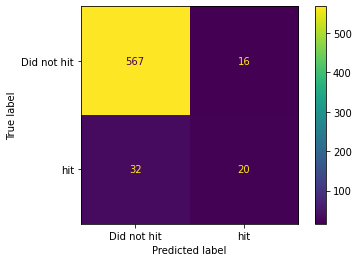

In [450]:
plot_confusion_matrix(clf_xgb,X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Did not hit","hit"])

In [451]:
param_grid = {
    'max_depth':[3,4,5],
    'learning_rate':[0.1,0.01,0.05],
    'gamma':[0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0],
    'scale_pos_weight':[1,3,5]
}

In [452]:
eval_set = [(X_test, y_test)]

In [ ]:
gsearch1 = GridSearchCV(estimator = clf_xgb, param_grid = param_grid, scoring='f1_micro'
                        ,n_jobs=10,verbose = 2, cv=3)
gsearch1.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END gamma=0.5, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   2.4s
[0]	validation_0-logloss:0.62709
[1]	validation_0-logloss:0.57346
[2]	validation_0-logloss:0.52699
[3]	validation_0-logloss:0.48861
[4]	validation_0-logloss:0.45506
[5]	validation_0-logloss:0.42664
[6]	validation_0-logloss:0.40231
[7]	validation_0-logloss:0.38110
[8]	validation_0-logloss:0.36333
[9]	validation_0-logloss:0.34690
[10]	validation_0-logloss:0.33296
[11]	validation_0-logloss:0.32010
[12]	validation_0-logloss:0.31014
[13]	validation_0-logloss:0.30124
[14]	validation_0-logloss:0.29249
[15]	validation_0-logloss:0.28512
[16]	validation_0-logloss:0.27879
[17]	validation_0-logloss:0.27246
[18]	validation_0-logloss:0.26748
[19]	validation_0-logloss:0.26300
[20]	validation_0-logloss:0.25886
[21]	validation_0-logloss:0.25487
[22]	validation_0-logloss:0.25208
[23]	validation_0-logloss:0.24939
[CV] END gamma=0.75, lear

[23]	validation_0-logloss:0.23960
[26]	validation_0-logloss:0.18435
[26]	validation_0-logloss:0.20861
[48]	validation_0-logloss:0.22522
[24]	validation_0-logloss:0.23561
[27]	validation_0-logloss:0.18226
[49]	validation_0-logloss:0.22370
[28]	validation_0-logloss:0.18061
[26]	validation_0-logloss:0.18232
[27]	validation_0-logloss:0.20633
[26]	validation_0-logloss:0.21413
[28]	validation_0-logloss:0.20566
[27]	validation_0-logloss:0.18102
[27]	validation_0-logloss:0.19536
[27]	validation_0-logloss:0.21225
[30]	validation_0-logloss:0.22668
[31]	validation_0-logloss:0.22432
[28]	validation_0-logloss:0.19369
[32]	validation_0-logloss:0.22358
[29]	validation_0-logloss:0.19224
[28]	validation_0-logloss:0.21060
[27]	validation_0-logloss:0.20341
[29]	validation_0-logloss:0.20927
[50]	validation_0-logloss:0.22377
[30]	validation_0-logloss:0.20767
[25]	validation_0-logloss:0.23243
[28]	validation_0-logloss:0.20186
[26]	validation_0-logloss:0.22990
[29]	validation_0-logloss:0.19977
[29]	validatio

[57]	validation_0-logloss:0.20716
[53]	validation_0-logloss:0.16847
[52]	validation_0-logloss:0.20106
[77]	validation_0-logloss:0.21884
[54]	validation_0-logloss:0.16839
[53]	validation_0-logloss:0.20087
[54]	validation_0-logloss:0.18625
[55]	validation_0-logloss:0.17327
[78]	validation_0-logloss:0.21818
[54]	validation_0-logloss:0.20060
[55]	validation_0-logloss:0.18621
[79]	validation_0-logloss:0.21953
[56]	validation_0-logloss:0.17297
[56]	validation_0-logloss:0.18598
[57]	validation_0-logloss:0.17293
[54]	validation_0-logloss:0.18626
[55]	validation_0-logloss:0.18633
[55]	validation_0-logloss:0.16851
[55]	validation_0-logloss:0.20062
[54]	validation_0-logloss:0.17743
[56]	validation_0-logloss:0.18600
[56]	validation_0-logloss:0.16809
[58]	validation_0-logloss:0.20701
[56]	validation_0-logloss:0.20074
[55]	validation_0-logloss:0.17707
[57]	validation_0-logloss:0.19927
[59]	validation_0-logloss:0.20636
[80]	validation_0-logloss:0.21969
[56]	validation_0-logloss:0.17715
[81]	validatio

[78]	validation_0-logloss:0.17713
[16]	validation_0-logloss:0.22714
[79]	validation_0-logloss:0.17660
[82]	validation_0-logloss:0.17807
[17]	validation_0-logloss:0.22062
[80]	validation_0-logloss:0.17651
[83]	validation_0-logloss:0.20046
[82]	validation_0-logloss:0.18937
[81]	validation_0-logloss:0.17672
[84]	validation_0-logloss:0.20018
[83]	validation_0-logloss:0.18860
[82]	validation_0-logloss:0.16656
[81]	validation_0-logloss:0.18578
[83]	validation_0-logloss:0.17744
[82]	validation_0-logloss:0.18635
[83]	validation_0-logloss:0.16622
[84]	validation_0-logloss:0.16573
[85]	validation_0-logloss:0.20107
[18]	validation_0-logloss:0.21514
[86]	validation_0-logloss:0.20130
[87]	validation_0-logloss:0.20083
[82]	validation_0-logloss:0.17708
[19]	validation_0-logloss:0.20967
[20]	validation_0-logloss:0.20542
[83]	validation_0-logloss:0.17738
[85]	validation_0-logloss:0.16574
[84]	validation_0-logloss:0.17752
[86]	validation_0-logloss:0.16614
[87]	validation_0-logloss:0.16657
[84]	validatio

[3]	validation_0-logloss:0.48809
[1]	validation_0-logloss:0.56300
[20]	validation_0-logloss:0.22890
[21]	validation_0-logloss:0.23245
[4]	validation_0-logloss:0.45471
[2]	validation_0-logloss:0.51387
[22]	validation_0-logloss:0.22810
[23]	validation_0-logloss:0.22437
[21]	validation_0-logloss:0.22602
[11]	validation_0-logloss:0.31828
[22]	validation_0-logloss:0.22231
[39]	validation_0-logloss:0.18390
[12]	validation_0-logloss:0.30726
[40]	validation_0-logloss:0.18323
[23]	validation_0-logloss:0.21922
[13]	validation_0-logloss:0.29742
[41]	validation_0-logloss:0.18359
[75]	validation_0-logloss:0.16972
[41]	validation_0-logloss:0.17177
[3]	validation_0-logloss:0.47239
[76]	validation_0-logloss:0.16950
[4]	validation_0-logloss:0.43640
[77]	validation_0-logloss:0.16930
[5]	validation_0-logloss:0.42564
[22]	validation_0-logloss:0.21907
[6]	validation_0-logloss:0.40161
[23]	validation_0-logloss:0.21606
[8]	validation_0-logloss:0.36450
[42]	validation_0-logloss:0.18304
[9]	validation_0-loglos

[43]	validation_0-logloss:0.22140
[59]	validation_0-logloss:0.18165
[60]	validation_0-logloss:0.18170
[55]	validation_0-logloss:0.18399
[58]	validation_0-logloss:0.19893
[56]	validation_0-logloss:0.18432
[57]	validation_0-logloss:0.18408
[58]	validation_0-logloss:0.18360
[37]	validation_0-logloss:0.18206
[59]	validation_0-logloss:0.18345
[60]	validation_0-logloss:0.18365
[38]	validation_0-logloss:0.18111
[38]	validation_0-logloss:0.21775
[47]	validation_0-logloss:0.20613
[59]	validation_0-logloss:0.19880
[44]	validation_0-logloss:0.22060
[48]	validation_0-logloss:0.20535
[60]	validation_0-logloss:0.19917
[39]	validation_0-logloss:0.18094
[45]	validation_0-logloss:0.21984
[61]	validation_0-logloss:0.19915
[49]	validation_0-logloss:0.20445
[40]	validation_0-logloss:0.18043
[46]	validation_0-logloss:0.22006
[39]	validation_0-logloss:0.21625
[50]	validation_0-logloss:0.20471
[41]	validation_0-logloss:0.17965
[61]	validation_0-logloss:0.18129
[61]	validation_0-logloss:0.18353
[51]	validatio

[94]	validation_0-logloss:0.17991
[70]	validation_0-logloss:0.17453
[75]	validation_0-logloss:0.21576
[95]	validation_0-logloss:0.18007
[71]	validation_0-logloss:0.17434
[96]	validation_0-logloss:0.17992
[76]	validation_0-logloss:0.21463
[77]	validation_0-logloss:0.21495
[79]	validation_0-logloss:0.19509
[80]	validation_0-logloss:0.19519
[17]	validation_0-logloss:0.23648
[18]	validation_0-logloss:0.23051
[17]	validation_0-logloss:0.22401
[92]	validation_0-logloss:0.18099
[73]	validation_0-logloss:0.20317
[18]	validation_0-logloss:0.21777
[74]	validation_0-logloss:0.20243
[19]	validation_0-logloss:0.21266
[72]	validation_0-logloss:0.17464
[20]	validation_0-logloss:0.20783
[93]	validation_0-logloss:0.18136
[21]	validation_0-logloss:0.20362
[13]	validation_0-logloss:0.28941
[73]	validation_0-logloss:0.17459
[94]	validation_0-logloss:0.18138
[81]	validation_0-logloss:0.19496
[14]	validation_0-logloss:0.28039
[82]	validation_0-logloss:0.19433
[15]	validation_0-logloss:0.27115
[83]	validatio

[49]	validation_0-logloss:0.17257
[4]	validation_0-logloss:0.47015
[44]	validation_0-logloss:0.19543
[50]	validation_0-logloss:0.17259
[5]	validation_0-logloss:0.44224
[45]	validation_0-logloss:0.19413
[30]	validation_0-logloss:0.21141
[51]	validation_0-logloss:0.17224
[31]	validation_0-logloss:0.21001
[46]	validation_0-logloss:0.19323
[47]	validation_0-logloss:0.19290
[49]	validation_0-logloss:0.18323
[32]	validation_0-logloss:0.20849
[50]	validation_0-logloss:0.18286
[7]	validation_0-logloss:0.37400
[8]	validation_0-logloss:0.35417
[52]	validation_0-logloss:0.17213
[6]	validation_0-logloss:0.41812
[53]	validation_0-logloss:0.17158
[7]	validation_0-logloss:0.39750
[51]	validation_0-logloss:0.18299
[52]	validation_0-logloss:0.18292
[8]	validation_0-logloss:0.37980
[9]	validation_0-logloss:0.33691
[53]	validation_0-logloss:0.18283
[10]	validation_0-logloss:0.32191
[11]	validation_0-logloss:0.30890
[48]	validation_0-logloss:0.19266
[33]	validation_0-logloss:0.20738
[54]	validation_0-logl

[28]	validation_0-logloss:0.23710
[76]	validation_0-logloss:0.18535
[21]	validation_0-logloss:0.25652
[29]	validation_0-logloss:0.23510
[30]	validation_0-logloss:0.23331
[38]	validation_0-logloss:0.19704
[39]	validation_0-logloss:0.19654
[22]	validation_0-logloss:0.25405
[84]	validation_0-logloss:0.17053
[40]	validation_0-logloss:0.19582
[77]	validation_0-logloss:0.18510
[23]	validation_0-logloss:0.25036
[85]	validation_0-logloss:0.17087
[41]	validation_0-logloss:0.19517
[24]	validation_0-logloss:0.24847
[39]	validation_0-logloss:0.22425
[86]	validation_0-logloss:0.17087
[42]	validation_0-logloss:0.19529
[40]	validation_0-logloss:0.22305
[63]	validation_0-logloss:0.19763
[78]	validation_0-logloss:0.18472
[64]	validation_0-logloss:0.19765
[15]	validation_0-logloss:0.24144
[65]	validation_0-logloss:0.19756
[79]	validation_0-logloss:0.18471
[16]	validation_0-logloss:0.23530
[16]	validation_0-logloss:0.22140
[25]	validation_0-logloss:0.24639
[17]	validation_0-logloss:0.21461
[26]	validatio

[65]	validation_0-logloss:0.21071
[48]	validation_0-logloss:0.18674
[7]	validation_0-logloss:0.35920
[49]	validation_0-logloss:0.18783
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=3; total time=   2.0s
[0]	validation_0-logloss:0.62229
[83]	validation_0-logloss:0.20466
[6]	validation_0-logloss:0.38613
[1]	validation_0-logloss:0.56154
[84]	validation_0-logloss:0.20467
[71]	validation_0-logloss:0.21650
[7]	validation_0-logloss:0.36356
[23]	validation_0-logloss:0.18859
[72]	validation_0-logloss:0.21601
[49]	validation_0-logloss:0.16594
[24]	validation_0-logloss:0.18517
[50]	validation_0-logloss:0.16561
[8]	validation_0-logloss:0.33804
[25]	validation_0-logloss:0.18252
[51]	validation_0-logloss:0.16593
[50]	validation_0-logloss:0.18888
[52]	validation_0-logloss:0.16658
[9]	validation_0-logloss:0.31948
[66]	validation_0-logloss:0.21080
[51]	validation_0-logloss:0.18876
[85]	validation_0-logloss:0.18772
[85]	validation_0-logloss:0.20454
[2]	validation_0-

[31]	validation_0-logloss:0.18796
[94]	validation_0-logloss:0.20379
[32]	validation_0-logloss:0.18637
[95]	validation_0-logloss:0.20349
[26]	validation_0-logloss:0.20404
[75]	validation_0-logloss:0.16784
[27]	validation_0-logloss:0.20133
[52]	validation_0-logloss:0.17934
[76]	validation_0-logloss:0.16852
[53]	validation_0-logloss:0.17943
[34]	validation_0-logloss:0.19890
[33]	validation_0-logloss:0.18515
[35]	validation_0-logloss:0.19791
[96]	validation_0-logloss:0.20323
[34]	validation_0-logloss:0.18354
[77]	validation_0-logloss:0.16899
[35]	validation_0-logloss:0.18242
[78]	validation_0-logloss:0.16976
[97]	validation_0-logloss:0.20307
[98]	validation_0-logloss:0.20259
[79]	validation_0-logloss:0.16967
[36]	validation_0-logloss:0.18166
[80]	validation_0-logloss:0.16927
[28]	validation_0-logloss:0.19969
[54]	validation_0-logloss:0.17985
[55]	validation_0-logloss:0.17946
[CV] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   1.6s
[0]	validatio

[29]	validation_0-logloss:0.22190
[71]	validation_0-logloss:0.17077
[21]	validation_0-logloss:0.19964
[30]	validation_0-logloss:0.22002
[72]	validation_0-logloss:0.17076
[70]	validation_0-logloss:0.20090
[22]	validation_0-logloss:0.19642
[73]	validation_0-logloss:0.17036
[71]	validation_0-logloss:0.20045
[74]	validation_0-logloss:0.17117
[31]	validation_0-logloss:0.21856
[75]	validation_0-logloss:0.17100
[9]	validation_0-logloss:0.29868
[32]	validation_0-logloss:0.21741
[14]	validation_0-logloss:0.24890
[62]	validation_0-logloss:0.19000
[10]	validation_0-logloss:0.28252
[63]	validation_0-logloss:0.18981
[10]	validation_0-logloss:0.30444
[15]	validation_0-logloss:0.24077
[11]	validation_0-logloss:0.28980
[31]	validation_0-logloss:0.20010
[29]	validation_0-logloss:0.21658
[23]	validation_0-logloss:0.19390
[72]	validation_0-logloss:0.20171
[32]	validation_0-logloss:0.19802
[30]	validation_0-logloss:0.21533
[11]	validation_0-logloss:0.26853
[24]	validation_0-logloss:0.19063
[73]	validation

[58]	validation_0-logloss:0.20518
[61]	validation_0-logloss:0.20696
[CV] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   2.0s
[0]	validation_0-logloss:0.62266
[62]	validation_0-logloss:0.17581
[59]	validation_0-logloss:0.20497
[1]	validation_0-logloss:0.56311
[63]	validation_0-logloss:0.17615
[54]	validation_0-logloss:0.16946
[2]	validation_0-logloss:0.51517
[11]	validation_0-logloss:0.30120
[64]	validation_0-logloss:0.17621
[12]	validation_0-logloss:0.28912
[65]	validation_0-logloss:0.17537
[44]	validation_0-logloss:0.18540
[41]	validation_0-logloss:0.17182
[55]	validation_0-logloss:0.16932
[66]	validation_0-logloss:0.17497
[45]	validation_0-logloss:0.18487
[42]	validation_0-logloss:0.17206
[67]	validation_0-logloss:0.17461
[56]	validation_0-logloss:0.16938
[62]	validation_0-logloss:0.20789
[13]	validation_0-logloss:0.27876
[63]	validation_0-logloss:0.20887
[14]	validation_0-logloss:0.26934
[60]	validation_0-logloss:0.20447
[61]	validation_

[19]	validation_0-logloss:0.24297
[81]	validation_0-logloss:0.16930
[82]	validation_0-logloss:0.16973
[20]	validation_0-logloss:0.23799
[90]	validation_0-logloss:0.17144
[21]	validation_0-logloss:0.23362
[85]	validation_0-logloss:0.20038
[91]	validation_0-logloss:0.17091
[92]	validation_0-logloss:0.17054
[37]	validation_0-logloss:0.19762
[86]	validation_0-logloss:0.20054
[25]	validation_0-logloss:0.20670
[38]	validation_0-logloss:0.19826
[26]	validation_0-logloss:0.20411
[87]	validation_0-logloss:0.20128
[67]	validation_0-logloss:0.16980
[27]	validation_0-logloss:0.20232
[28]	validation_0-logloss:0.19974
[68]	validation_0-logloss:0.16947
[29]	validation_0-logloss:0.19901
[69]	validation_0-logloss:0.16925
[70]	validation_0-logloss:0.16940
[93]	validation_0-logloss:0.17027
[39]	validation_0-logloss:0.19728
[94]	validation_0-logloss:0.17007
[40]	validation_0-logloss:0.19713
[88]	validation_0-logloss:0.20067
[22]	validation_0-logloss:0.22885
[89]	validation_0-logloss:0.20136
[23]	validatio

[50]	validation_0-logloss:0.19181
[70]	validation_0-logloss:0.19974
[18]	validation_0-logloss:0.25215
[13]	validation_0-logloss:0.26605
[51]	validation_0-logloss:0.19146
[14]	validation_0-logloss:0.25707
[15]	validation_0-logloss:0.24956
[19]	validation_0-logloss:0.24745
[59]	validation_0-logloss:0.18447
[22]	validation_0-logloss:0.23876
[20]	validation_0-logloss:0.24301
[21]	validation_0-logloss:0.23879
[60]	validation_0-logloss:0.18516
[23]	validation_0-logloss:0.23509
[19]	validation_0-logloss:0.22370
[6]	validation_0-logloss:0.39676
[24]	validation_0-logloss:0.23263
[20]	validation_0-logloss:0.21887
[7]	validation_0-logloss:0.37523
[25]	validation_0-logloss:0.22969
[71]	validation_0-logloss:0.20021
[52]	validation_0-logloss:0.19103
[16]	validation_0-logloss:0.24289
[17]	validation_0-logloss:0.23623
[72]	validation_0-logloss:0.20000
[53]	validation_0-logloss:0.19007
[11]	validation_0-logloss:0.28064
[73]	validation_0-logloss:0.19969
[74]	validation_0-logloss:0.19982
[61]	validation_

[48]	validation_0-logloss:0.17753
[39]	validation_0-logloss:0.17554
[50]	validation_0-logloss:0.20943
[11]	validation_0-logloss:0.30406
[49]	validation_0-logloss:0.17746
[40]	validation_0-logloss:0.17543
[51]	validation_0-logloss:0.20912
[52]	validation_0-logloss:0.20941
[12]	validation_0-logloss:0.29190
[53]	validation_0-logloss:0.20924
[14]	validation_0-logloss:0.27824
[15]	validation_0-logloss:0.26974
[82]	validation_0-logloss:0.18090
[45]	validation_0-logloss:0.18411
[83]	validation_0-logloss:0.18079
[37]	validation_0-logloss:0.19467
[46]	validation_0-logloss:0.18399
[50]	validation_0-logloss:0.17724
[38]	validation_0-logloss:0.19390
[41]	validation_0-logloss:0.17489
[84]	validation_0-logloss:0.18022
[51]	validation_0-logloss:0.17678
[52]	validation_0-logloss:0.20795
[85]	validation_0-logloss:0.18021
[42]	validation_0-logloss:0.17510
[86]	validation_0-logloss:0.18029
[54]	validation_0-logloss:0.20934
[13]	validation_0-logloss:0.28090
[87]	validation_0-logloss:0.17938
[55]	validatio

[40]	validation_0-logloss:0.19336
[72]	validation_0-logloss:0.18712
[83]	validation_0-logloss:0.20658
[73]	validation_0-logloss:0.18712
[65]	validation_0-logloss:0.18150
[41]	validation_0-logloss:0.19279
[70]	validation_0-logloss:0.17333
[74]	validation_0-logloss:0.18711
[81]	validation_0-logloss:0.20100
[42]	validation_0-logloss:0.19244
[71]	validation_0-logloss:0.17329
[82]	validation_0-logloss:0.20037
[43]	validation_0-logloss:0.19193
[14]	validation_0-logloss:0.29946
[66]	validation_0-logloss:0.18141
[75]	validation_0-logloss:0.18706
[78]	validation_0-logloss:0.17495
[15]	validation_0-logloss:0.29060
[76]	validation_0-logloss:0.18714
[79]	validation_0-logloss:0.17518
[84]	validation_0-logloss:0.20715
[45]	validation_0-logloss:0.19723
[85]	validation_0-logloss:0.20702
[46]	validation_0-logloss:0.19679
[86]	validation_0-logloss:0.20697
[67]	validation_0-logloss:0.18149
[72]	validation_0-logloss:0.17315
[83]	validation_0-logloss:0.20111
[68]	validation_0-logloss:0.18160
[84]	validatio

[10]	validation_0-logloss:0.28506
[CV] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   2.3s
[0]	validation_0-logloss:0.61973
[4]	validation_0-logloss:0.42528
[1]	validation_0-logloss:0.56096
[11]	validation_0-logloss:0.27109
[5]	validation_0-logloss:0.39487
[16]	validation_0-logloss:0.28361
[12]	validation_0-logloss:0.25902
[17]	validation_0-logloss:0.27669
[6]	validation_0-logloss:0.36831
[2]	validation_0-logloss:0.51401
[13]	validation_0-logloss:0.24864
[31]	validation_0-logloss:0.22762
[50]	validation_0-logloss:0.20604
[79]	validation_0-logloss:0.19465
[51]	validation_0-logloss:0.20537
[32]	validation_0-logloss:0.22576
[33]	validation_0-logloss:0.22479
[80]	validation_0-logloss:0.19487
[3]	validation_0-logloss:0.45503
[18]	validation_0-logloss:0.26989
[34]	validation_0-logloss:0.22344
[81]	validation_0-logloss:0.18571
[52]	validation_0-logloss:0.20528
[19]	validation_0-logloss:0.26451
[82]	validation_0-logloss:0.18578
[53]	validation_0

[87]	validation_0-logloss:0.19506
[31]	validation_0-logloss:0.17912
[88]	validation_0-logloss:0.19436
[CV] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   2.3s
[0]	validation_0-logloss:0.62067
[39]	validation_0-logloss:0.17243
[68]	validation_0-logloss:0.21367
[40]	validation_0-logloss:0.17252
[31]	validation_0-logloss:0.17367
[33]	validation_0-logloss:0.19548
[11]	validation_0-logloss:0.28351
[69]	validation_0-logloss:0.21321
[34]	validation_0-logloss:0.19594
[32]	validation_0-logloss:0.17321
[53]	validation_0-logloss:0.20891
[12]	validation_0-logloss:0.27079
[21]	validation_0-logloss:0.22425
[41]	validation_0-logloss:0.17183
[54]	validation_0-logloss:0.20871
[42]	validation_0-logloss:0.17076
[55]	validation_0-logloss:0.20848
[32]	validation_0-logloss:0.17740
[89]	validation_0-logloss:0.19439
[33]	validation_0-logloss:0.17627
[1]	validation_0-logloss:0.55988
[90]	validation_0-logloss:0.19411
[35]	validation_0-logloss:0.19606
[33]	validat

[45]	validation_0-logloss:0.20158
[CV] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=5; total time=   2.4s
[0]	validation_0-logloss:0.62313
[65]	validation_0-logloss:0.17514
[24]	validation_0-logloss:0.20990
[66]	validation_0-logloss:0.17536
[37]	validation_0-logloss:0.19094
[57]	validation_0-logloss:0.17141
[25]	validation_0-logloss:0.20806
[38]	validation_0-logloss:0.19151
[84]	validation_0-logloss:0.20339
[58]	validation_0-logloss:0.17188
[85]	validation_0-logloss:0.20274
[59]	validation_0-logloss:0.17893
[46]	validation_0-logloss:0.20181
[1]	validation_0-logloss:0.56796
[60]	validation_0-logloss:0.17874
[2]	validation_0-logloss:0.52115
[47]	validation_0-logloss:0.20242
[67]	validation_0-logloss:0.17593
[39]	validation_0-logloss:0.19214
[59]	validation_0-logloss:0.17246
[26]	validation_0-logloss:0.20552
[60]	validation_0-logloss:0.17208
[40]	validation_0-logloss:0.19161
[86]	validation_0-logloss:0.20260
[87]	validation_0-logloss:0.20236
[41]	validati

[33]	validation_0-logloss:0.21747
[15]	validation_0-logloss:0.24594
[18]	validation_0-logloss:0.24206
[5]	validation_0-logloss:0.40497
[19]	validation_0-logloss:0.23603
[6]	validation_0-logloss:0.37751
[16]	validation_0-logloss:0.23878
[57]	validation_0-logloss:0.18329
[2]	validation_0-logloss:0.51533
[58]	validation_0-logloss:0.18300
[3]	validation_0-logloss:0.47474
[19]	validation_0-logloss:0.21250
[12]	validation_0-logloss:0.25673
[4]	validation_0-logloss:0.44132
[20]	validation_0-logloss:0.20784
[2]	validation_0-logloss:0.51247
[13]	validation_0-logloss:0.24627
[34]	validation_0-logloss:0.21694
[3]	validation_0-logloss:0.47176
[1]	validation_0-logloss:0.56599
[20]	validation_0-logloss:0.23128
[7]	validation_0-logloss:0.35411
[17]	validation_0-logloss:0.23247
[59]	validation_0-logloss:0.18325
[21]	validation_0-logloss:0.20374
[18]	validation_0-logloss:0.22772
[60]	validation_0-logloss:0.18405
[14]	validation_0-logloss:0.23767
[35]	validation_0-logloss:0.21539
[22]	validation_0-loglo

[41]	validation_0-logloss:0.17680
[45]	validation_0-logloss:0.19088
[27]	validation_0-logloss:0.20157
[29]	validation_0-logloss:0.19163
[32]	validation_0-logloss:0.18461
[30]	validation_0-logloss:0.19020
[33]	validation_0-logloss:0.18355
[31]	validation_0-logloss:0.18927
[47]	validation_0-logloss:0.20135
[88]	validation_0-logloss:0.17905
[49]	validation_0-logloss:0.17580
[30]	validation_0-logloss:0.20602
[89]	validation_0-logloss:0.17871
[48]	validation_0-logloss:0.20093
[42]	validation_0-logloss:0.17711
[31]	validation_0-logloss:0.20497
[43]	validation_0-logloss:0.17608
[28]	validation_0-logloss:0.20122
[34]	validation_0-logloss:0.18284
[46]	validation_0-logloss:0.19086
[29]	validation_0-logloss:0.19933
[50]	validation_0-logloss:0.17561
[35]	validation_0-logloss:0.18232
[47]	validation_0-logloss:0.19117
[49]	validation_0-logloss:0.20015
[90]	validation_0-logloss:0.17892
[32]	validation_0-logloss:0.20388
[91]	validation_0-logloss:0.17916
[50]	validation_0-logloss:0.19963
[44]	validatio

[62]	validation_0-logloss:0.17724
[65]	validation_0-logloss:0.18767
[22]	validation_0-logloss:0.23834
[67]	validation_0-logloss:0.17528
[9]	validation_0-logloss:0.33175
[83]	validation_0-logloss:0.20090
[23]	validation_0-logloss:0.23601
[10]	validation_0-logloss:0.31604
[84]	validation_0-logloss:0.20143
[24]	validation_0-logloss:0.23397
[68]	validation_0-logloss:0.17535
[63]	validation_0-logloss:0.17731
[69]	validation_0-logloss:0.17464
[66]	validation_0-logloss:0.18745
[64]	validation_0-logloss:0.17767
[67]	validation_0-logloss:0.18728
[11]	validation_0-logloss:0.30308
[85]	validation_0-logloss:0.20181
[12]	validation_0-logloss:0.29061
[70]	validation_0-logloss:0.17486
[25]	validation_0-logloss:0.23043
[71]	validation_0-logloss:0.17481
[CV] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   2.0s
[0]	validation_0-logloss:0.62169
[65]	validation_0-logloss:0.17758
[CV] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weigh

[12]	validation_0-logloss:0.28971
[15]	validation_0-logloss:0.27359
[54]	validation_0-logloss:0.21823
[32]	validation_0-logloss:0.18972
[30]	validation_0-logloss:0.19509
[33]	validation_0-logloss:0.18852
[55]	validation_0-logloss:0.21778
[30]	validation_0-logloss:0.18251
[9]	validation_0-logloss:0.35194
[42]	validation_0-logloss:0.20318
[19]	validation_0-logloss:0.24108
[31]	validation_0-logloss:0.18121
[43]	validation_0-logloss:0.20227
[16]	validation_0-logloss:0.26570
[13]	validation_0-logloss:0.27896
[31]	validation_0-logloss:0.19389
[56]	validation_0-logloss:0.21804
[34]	validation_0-logloss:0.18701
[32]	validation_0-logloss:0.19252
[32]	validation_0-logloss:0.18012
[57]	validation_0-logloss:0.21909
[20]	validation_0-logloss:0.23593
[10]	validation_0-logloss:0.33722
[44]	validation_0-logloss:0.20172
[21]	validation_0-logloss:0.23169
[11]	validation_0-logloss:0.32346
[45]	validation_0-logloss:0.20080
[17]	validation_0-logloss:0.25845
[14]	validation_0-logloss:0.26868
[35]	validation

[58]	validation_0-logloss:0.17670
[46]	validation_0-logloss:0.18704
[56]	validation_0-logloss:0.18733
[47]	validation_0-logloss:0.18712
[59]	validation_0-logloss:0.17639
[57]	validation_0-logloss:0.18720
[60]	validation_0-logloss:0.17641
[58]	validation_0-logloss:0.18785
[12]	validation_0-logloss:0.31086
[57]	validation_0-logloss:0.17285
[69]	validation_0-logloss:0.19757
[70]	validation_0-logloss:0.19742
[34]	validation_0-logloss:0.21176
[40]	validation_0-logloss:0.20405
[13]	validation_0-logloss:0.29979
[58]	validation_0-logloss:0.17298
[35]	validation_0-logloss:0.20984
[41]	validation_0-logloss:0.20345
[71]	validation_0-logloss:0.19784
[59]	validation_0-logloss:0.17291
[14]	validation_0-logloss:0.29095
[72]	validation_0-logloss:0.19791
[15]	validation_0-logloss:0.28332
[41]	validation_0-logloss:0.19248
[42]	validation_0-logloss:0.19152
[16]	validation_0-logloss:0.27658
[61]	validation_0-logloss:0.17616
[59]	validation_0-logloss:0.18762
[48]	validation_0-logloss:0.18693
[62]	validatio

[68]	validation_0-logloss:0.20077
[70]	validation_0-logloss:0.18557
[91]	validation_0-logloss:0.17441
[69]	validation_0-logloss:0.20080
[71]	validation_0-logloss:0.18552
[92]	validation_0-logloss:0.17455
[70]	validation_0-logloss:0.20054
[40]	validation_0-logloss:0.21730
[41]	validation_0-logloss:0.21679
[75]	validation_0-logloss:0.18093
[26]	validation_0-logloss:0.23014
[6]	validation_0-logloss:0.64110
[93]	validation_0-logloss:0.17448
[76]	validation_0-logloss:0.18083
[27]	validation_0-logloss:0.22806
[77]	validation_0-logloss:0.18063
[7]	validation_0-logloss:0.63433
[65]	validation_0-logloss:0.19321
[42]	validation_0-logloss:0.21640
[8]	validation_0-logloss:0.62752
[72]	validation_0-logloss:0.18563
[28]	validation_0-logloss:0.22624
[66]	validation_0-logloss:0.19319
[9]	validation_0-logloss:0.62099
[73]	validation_0-logloss:0.18578
[29]	validation_0-logloss:0.22399
[10]	validation_0-logloss:0.61443
[67]	validation_0-logloss:0.19251
[78]	validation_0-logloss:0.18054
[71]	validation_0-

[5]	validation_0-logloss:0.65249
[54]	validation_0-logloss:0.41430
[96]	validation_0-logloss:0.18840
[6]	validation_0-logloss:0.64618
[55]	validation_0-logloss:0.41119
[58]	validation_0-logloss:0.20408
[24]	validation_0-logloss:0.54664
[25]	validation_0-logloss:0.54195
[2]	validation_0-logloss:0.67109
[72]	validation_0-logloss:0.21043
[3]	validation_0-logloss:0.66403
[34]	validation_0-logloss:0.48959
[30]	validation_0-logloss:0.50144
[35]	validation_0-logloss:0.48542
[7]	validation_0-logloss:0.63996
[31]	validation_0-logloss:0.49686
[4]	validation_0-logloss:0.65710
[36]	validation_0-logloss:0.48116
[73]	validation_0-logloss:0.21079
[32]	validation_0-logloss:0.49231
[8]	validation_0-logloss:0.63387
[97]	validation_0-logloss:0.18876
[9]	validation_0-logloss:0.62790
[56]	validation_0-logloss:0.40807
[74]	validation_0-logloss:0.21063
[59]	validation_0-logloss:0.20422
[98]	validation_0-logloss:0.18869
[57]	validation_0-logloss:0.40501
[75]	validation_0-logloss:0.21070
[60]	validation_0-logl

[54]	validation_0-logloss:0.43286
[6]	validation_0-logloss:0.64746
[64]	validation_0-logloss:0.38851
[60]	validation_0-logloss:0.39048
[61]	validation_0-logloss:0.38757
[65]	validation_0-logloss:0.38591
[62]	validation_0-logloss:0.38476
[86]	validation_0-logloss:0.33211
[31]	validation_0-logloss:0.51098
[87]	validation_0-logloss:0.33016
[32]	validation_0-logloss:0.50687
[36]	validation_0-logloss:0.49704
[37]	validation_0-logloss:0.49305
[78]	validation_0-logloss:0.19957
[33]	validation_0-logloss:0.50266
[38]	validation_0-logloss:0.48912
[93]	validation_0-logloss:0.21263
[79]	validation_0-logloss:0.19953
[22]	validation_0-logloss:0.56254
[7]	validation_0-logloss:0.64144
[55]	validation_0-logloss:0.42980
[23]	validation_0-logloss:0.55794
[56]	validation_0-logloss:0.42679
[8]	validation_0-logloss:0.63553
[88]	validation_0-logloss:0.32810
[57]	validation_0-logloss:0.42389
[9]	validation_0-logloss:0.62974
[66]	validation_0-logloss:0.38337
[63]	validation_0-logloss:0.38193
[89]	validation_0-

[50]	validation_0-logloss:0.45733
[64]	validation_0-logloss:0.41907
[65]	validation_0-logloss:0.41652
[12]	validation_0-logloss:0.60272
[13]	validation_0-logloss:0.59660
[97]	validation_0-logloss:0.33299
[80]	validation_0-logloss:0.36910
[98]	validation_0-logloss:0.33123
[81]	validation_0-logloss:0.36697
[82]	validation_0-logloss:0.36493
[19]	validation_0-logloss:0.57524
[76]	validation_0-logloss:0.37280
[20]	validation_0-logloss:0.57040
[21]	validation_0-logloss:0.56556
[77]	validation_0-logloss:0.37052
[51]	validation_0-logloss:0.45434
[66]	validation_0-logloss:0.41402
[78]	validation_0-logloss:0.36834
[52]	validation_0-logloss:0.45141
[14]	validation_0-logloss:0.59072
[99]	validation_0-logloss:0.32948
[83]	validation_0-logloss:0.36290
[84]	validation_0-logloss:0.36097
[15]	validation_0-logloss:0.58481
[53]	validation_0-logloss:0.44848
[22]	validation_0-logloss:0.56097
[16]	validation_0-logloss:0.57912
[17]	validation_0-logloss:0.57339
[23]	validation_0-logloss:0.55636
[67]	validatio

[81]	validation_0-logloss:0.38304
[8]	validation_0-logloss:0.63385
[42]	validation_0-logloss:0.45805
[94]	validation_0-logloss:0.35711
[23]	validation_0-logloss:0.53668
[95]	validation_0-logloss:0.35543
[43]	validation_0-logloss:0.45431
[96]	validation_0-logloss:0.35373
[44]	validation_0-logloss:0.45059
[45]	validation_0-logloss:0.44694
[24]	validation_0-logloss:0.53146
[24]	validation_0-logloss:0.53606
[50]	validation_0-logloss:0.45545
[51]	validation_0-logloss:0.45252
[25]	validation_0-logloss:0.53114
[52]	validation_0-logloss:0.44950
[53]	validation_0-logloss:0.44663
[16]	validation_0-logloss:0.58723
[82]	validation_0-logloss:0.38110
[9]	validation_0-logloss:0.62786
[17]	validation_0-logloss:0.58203
[18]	validation_0-logloss:0.57689
[83]	validation_0-logloss:0.37924
[10]	validation_0-logloss:0.62198
[11]	validation_0-logloss:0.61621
[97]	validation_0-logloss:0.35219
[25]	validation_0-logloss:0.52641
[84]	validation_0-logloss:0.37739
[98]	validation_0-logloss:0.35054
[26]	validation_

[19]	validation_0-logloss:0.56854
[38]	validation_0-logloss:0.48975
[5]	validation_0-logloss:0.65394
[72]	validation_0-logloss:0.36630
[6]	validation_0-logloss:0.64784
[20]	validation_0-logloss:0.56340
[73]	validation_0-logloss:0.36378
[18]	validation_0-logloss:0.58266
[21]	validation_0-logloss:0.55833
[74]	validation_0-logloss:0.36130
[19]	validation_0-logloss:0.57778
[79]	validation_0-logloss:0.38322
[55]	validation_0-logloss:0.40733
[56]	validation_0-logloss:0.40420
[80]	validation_0-logloss:0.38130
[53]	validation_0-logloss:0.42109
[81]	validation_0-logloss:0.37915
[54]	validation_0-logloss:0.41801
[39]	validation_0-logloss:0.48590
[7]	validation_0-logloss:0.64187
[40]	validation_0-logloss:0.48209
[22]	validation_0-logloss:0.55335
[8]	validation_0-logloss:0.63600
[47]	validation_0-logloss:0.45615
[20]	validation_0-logloss:0.57308
[23]	validation_0-logloss:0.54847
[75]	validation_0-logloss:0.35894
[21]	validation_0-logloss:0.56833
[24]	validation_0-logloss:0.54366
[76]	validation_0-

[75]	validation_0-logloss:0.37857
[36]	validation_0-logloss:0.50540
[82]	validation_0-logloss:0.34713
[21]	validation_0-logloss:0.56612
[83]	validation_0-logloss:0.34497
[22]	validation_0-logloss:0.56144
[84]	validation_0-logloss:0.34301
[37]	validation_0-logloss:0.50174
[23]	validation_0-logloss:0.55677
[49]	validation_0-logloss:0.46199
[68]	validation_0-logloss:0.39702
[51]	validation_0-logloss:0.43949
[50]	validation_0-logloss:0.45898
[69]	validation_0-logloss:0.39462
[52]	validation_0-logloss:0.43629
[76]	validation_0-logloss:0.37630
[85]	validation_0-logloss:0.34106
[87]	validation_0-logloss:0.32600
[77]	validation_0-logloss:0.37405
[38]	validation_0-logloss:0.49815
[86]	validation_0-logloss:0.33915
[88]	validation_0-logloss:0.32400
[78]	validation_0-logloss:0.37184
[39]	validation_0-logloss:0.49456
[87]	validation_0-logloss:0.33725
[89]	validation_0-logloss:0.32201
[24]	validation_0-logloss:0.55234
[51]	validation_0-logloss:0.45600
[70]	validation_0-logloss:0.39219
[25]	validatio

[82]	validation_0-logloss:0.36136
[53]	validation_0-logloss:0.44771
[83]	validation_0-logloss:0.35932
[54]	validation_0-logloss:0.44480
[99]	validation_0-logloss:0.33518
[80]	validation_0-logloss:0.38539
[81]	validation_0-logloss:0.38337
[69]	validation_0-logloss:0.40868
[82]	validation_0-logloss:0.38136
[83]	validation_0-logloss:0.37949
[24]	validation_0-logloss:0.54203
[84]	validation_0-logloss:0.37754
[85]	validation_0-logloss:0.37561
[86]	validation_0-logloss:0.37369
[70]	validation_0-logloss:0.40638
[87]	validation_0-logloss:0.37192
[25]	validation_0-logloss:0.53724
[19]	validation_0-logloss:0.56582
[20]	validation_0-logloss:0.56059
[55]	validation_0-logloss:0.44194
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   1.4s
[0]	validation_0-logloss:0.68551
[21]	validation_0-logloss:0.55539
[56]	validation_0-logloss:0.43917
[1]	validation_0-logloss:0.67802
[84]	validation_0-logloss:0.35734
[71]	validation_0-logloss:0.40411
[85]	validat

[28]	validation_0-logloss:0.53763
[20]	validation_0-logloss:0.57223
[31]	validation_0-logloss:0.50469
[21]	validation_0-logloss:0.56746
[22]	validation_0-logloss:0.56285
[55]	validation_0-logloss:0.42298
[56]	validation_0-logloss:0.41998
[52]	validation_0-logloss:0.43079
[29]	validation_0-logloss:0.53343
[53]	validation_0-logloss:0.42770
[57]	validation_0-logloss:0.41707
[30]	validation_0-logloss:0.52926
[54]	validation_0-logloss:0.42468
[15]	validation_0-logloss:0.59608
[32]	validation_0-logloss:0.50032
[16]	validation_0-logloss:0.59086
[33]	validation_0-logloss:0.49591
[17]	validation_0-logloss:0.58577
[85]	validation_0-logloss:0.37215
[34]	validation_0-logloss:0.49167
[23]	validation_0-logloss:0.55824
[86]	validation_0-logloss:0.37027
[58]	validation_0-logloss:0.41412
[24]	validation_0-logloss:0.55371
[87]	validation_0-logloss:0.36828
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   1.4s
[0]	validation_0-logloss:0.68676
[59]	valida

[89]	validation_0-logloss:0.34088
[65]	validation_0-logloss:0.38752
[29]	validation_0-logloss:0.53782
[66]	validation_0-logloss:0.38486
[67]	validation_0-logloss:0.38227
[54]	validation_0-logloss:0.44389
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=5; total time=   1.3s
[0]	validation_0-logloss:0.68521
[61]	validation_0-logloss:0.42612
[47]	validation_0-logloss:0.46299
[62]	validation_0-logloss:0.42346
[85]	validation_0-logloss:0.34862
[48]	validation_0-logloss:0.45993
[63]	validation_0-logloss:0.42087
[55]	validation_0-logloss:0.44090
[14]	validation_0-logloss:0.60627
[86]	validation_0-logloss:0.34663
[64]	validation_0-logloss:0.41828
[56]	validation_0-logloss:0.43801
[15]	validation_0-logloss:0.60119
[87]	validation_0-logloss:0.34469
[65]	validation_0-logloss:0.41572
[57]	validation_0-logloss:0.43511
[16]	validation_0-logloss:0.59625
[30]	validation_0-logloss:0.53888
[90]	validation_0-logloss:0.33901
[30]	validation_0-logloss:0.53385
[68]	valida

[57]	validation_0-logloss:0.44641
[76]	validation_0-logloss:0.38550
[42]	validation_0-logloss:0.49147
[59]	validation_0-logloss:0.44766
[77]	validation_0-logloss:0.38320
[43]	validation_0-logloss:0.48824
[60]	validation_0-logloss:0.44514
[44]	validation_0-logloss:0.48503
[78]	validation_0-logloss:0.38102
[1]	validation_0-logloss:0.67746
[79]	validation_0-logloss:0.37881
[92]	validation_0-logloss:0.35797
[80]	validation_0-logloss:0.37660
[93]	validation_0-logloss:0.35616
[81]	validation_0-logloss:0.37453
[82]	validation_0-logloss:0.37240
[94]	validation_0-logloss:0.35437
[2]	validation_0-logloss:0.66985
[98]	validation_0-logloss:0.31626
[86]	validation_0-logloss:0.36670
[24]	validation_0-logloss:0.53337
[99]	validation_0-logloss:0.31452
[25]	validation_0-logloss:0.52834
[87]	validation_0-logloss:0.36480
[58]	validation_0-logloss:0.44384
[26]	validation_0-logloss:0.52336
[88]	validation_0-logloss:0.36288
[59]	validation_0-logloss:0.44117
[CV] END gamma=0, learning_rate=0.01, max_depth=3,

[49]	validation_0-logloss:0.42722
[9]	validation_0-logloss:0.62581
[89]	validation_0-logloss:0.37737
[50]	validation_0-logloss:0.42368
[10]	validation_0-logloss:0.61965
[90]	validation_0-logloss:0.37556
[11]	validation_0-logloss:0.61366
[24]	validation_0-logloss:0.52930
[12]	validation_0-logloss:0.60775
[25]	validation_0-logloss:0.52413
[91]	validation_0-logloss:0.37390
[76]	validation_0-logloss:0.40233
[92]	validation_0-logloss:0.37837
[3]	validation_0-logloss:0.66456
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=3; total time=   1.3s
[0]	validation_0-logloss:0.68571
[77]	validation_0-logloss:0.40020
[93]	validation_0-logloss:0.37669
[4]	validation_0-logloss:0.65771
[1]	validation_0-logloss:0.67842
[78]	validation_0-logloss:0.39809
[94]	validation_0-logloss:0.37508
[28]	validation_0-logloss:0.51444
[51]	validation_0-logloss:0.42019
[26]	validation_0-logloss:0.51905
[29]	validation_0-logloss:0.50978
[52]	validation_0-logloss:0.41692
[92]	validatio

[30]	validation_0-logloss:0.52026
[37]	validation_0-logloss:0.48534
[49]	validation_0-logloss:0.44560
[42]	validation_0-logloss:0.47032
[31]	validation_0-logloss:0.51599
[16]	validation_0-logloss:0.58940
[67]	validation_0-logloss:0.37844
[43]	validation_0-logloss:0.46663
[17]	validation_0-logloss:0.58430
[68]	validation_0-logloss:0.37577
[44]	validation_0-logloss:0.46315
[4]	validation_0-logloss:0.65539
[63]	validation_0-logloss:0.37889
[15]	validation_0-logloss:0.59469
[5]	validation_0-logloss:0.64827
[90]	validation_0-logloss:0.32075
[91]	validation_0-logloss:0.31883
[16]	validation_0-logloss:0.58947
[64]	validation_0-logloss:0.37620
[38]	validation_0-logloss:0.48131
[6]	validation_0-logloss:0.64129
[50]	validation_0-logloss:0.44226
[32]	validation_0-logloss:0.51182
[7]	validation_0-logloss:0.63442
[39]	validation_0-logloss:0.47763
[33]	validation_0-logloss:0.50769
[51]	validation_0-logloss:0.43913
[40]	validation_0-logloss:0.47375
[18]	validation_0-logloss:0.57927
[34]	validation_0-

[50]	validation_0-logloss:0.45216
[41]	validation_0-logloss:0.46020
[66]	validation_0-logloss:0.40376
[50]	validation_0-logloss:0.45265
[77]	validation_0-logloss:0.37099
[78]	validation_0-logloss:0.36877
[84]	validation_0-logloss:0.35137
[51]	validation_0-logloss:0.44954
[51]	validation_0-logloss:0.44911
[73]	validation_0-logloss:0.37417
[85]	validation_0-logloss:0.34930
[10]	validation_0-logloss:0.61423
[74]	validation_0-logloss:0.37200
[11]	validation_0-logloss:0.60787
[67]	validation_0-logloss:0.40141
[68]	validation_0-logloss:0.39906
[42]	validation_0-logloss:0.45642
[69]	validation_0-logloss:0.39671
[52]	validation_0-logloss:0.44610
[43]	validation_0-logloss:0.45260
[79]	validation_0-logloss:0.36668
[70]	validation_0-logloss:0.39415
[86]	validation_0-logloss:0.34720
[53]	validation_0-logloss:0.44321
[75]	validation_0-logloss:0.36958
[87]	validation_0-logloss:0.34516
[80]	validation_0-logloss:0.36448
[76]	validation_0-logloss:0.36736
[12]	validation_0-logloss:0.60159
[52]	validatio

[78]	validation_0-logloss:0.34993
[86]	validation_0-logloss:0.36419
[48]	validation_0-logloss:0.43539
[87]	validation_0-logloss:0.36226
[22]	validation_0-logloss:0.55589
[49]	validation_0-logloss:0.43204
[25]	validation_0-logloss:0.52603
[23]	validation_0-logloss:0.55097
[1]	validation_0-logloss:0.67851
[88]	validation_0-logloss:0.36147
[26]	validation_0-logloss:0.52104
[2]	validation_0-logloss:0.67140
[7]	validation_0-logloss:0.63819
[89]	validation_0-logloss:0.35951
[8]	validation_0-logloss:0.63196
[79]	validation_0-logloss:0.34773
[90]	validation_0-logloss:0.35776
[80]	validation_0-logloss:0.34553
[91]	validation_0-logloss:0.35613
[24]	validation_0-logloss:0.54611
[88]	validation_0-logloss:0.36046
[50]	validation_0-logloss:0.42878
[25]	validation_0-logloss:0.54142
[89]	validation_0-logloss:0.35866
[3]	validation_0-logloss:0.66444
[27]	validation_0-logloss:0.51609
[51]	validation_0-logloss:0.42553
[9]	validation_0-logloss:0.62575
[4]	validation_0-logloss:0.65761
[28]	validation_0-log

[86]	validation_0-logloss:0.33767
[24]	validation_0-logloss:0.55041
[10]	validation_0-logloss:0.62294
[25]	validation_0-logloss:0.54592
[61]	validation_0-logloss:0.41129
[43]	validation_0-logloss:0.46735
[87]	validation_0-logloss:0.33575
[62]	validation_0-logloss:0.40850
[63]	validation_0-logloss:0.38202
[63]	validation_0-logloss:0.40582
[88]	validation_0-logloss:0.33391
[64]	validation_0-logloss:0.37925
[64]	validation_0-logloss:0.40310
[44]	validation_0-logloss:0.46378
[89]	validation_0-logloss:0.33196
[90]	validation_0-logloss:0.33013
[33]	validation_0-logloss:0.51083
[9]	validation_0-logloss:0.62450
[10]	validation_0-logloss:0.61831
[34]	validation_0-logloss:0.50680
[1]	validation_0-logloss:0.67810
[11]	validation_0-logloss:0.61224
[11]	validation_0-logloss:0.61725
[40]	validation_0-logloss:0.47524
[2]	validation_0-logloss:0.67079
[12]	validation_0-logloss:0.61164
[41]	validation_0-logloss:0.47129
[65]	validation_0-logloss:0.37645
[45]	validation_0-logloss:0.46023
[35]	validation_0

[38]	validation_0-logloss:0.49651
[2]	validation_0-logloss:0.67069
[51]	validation_0-logloss:0.45032
[68]	validation_0-logloss:0.38882
[39]	validation_0-logloss:0.49308
[72]	validation_0-logloss:0.38421
[61]	validation_0-logloss:0.41945
[89]	validation_0-logloss:0.34493
[62]	validation_0-logloss:0.41685
[90]	validation_0-logloss:0.34301
[73]	validation_0-logloss:0.38196
[31]	validation_0-logloss:0.50738
[94]	validation_0-logloss:0.31120
[32]	validation_0-logloss:0.50308
[39]	validation_0-logloss:0.47754
[69]	validation_0-logloss:0.38644
[95]	validation_0-logloss:0.30934
[40]	validation_0-logloss:0.47370
[70]	validation_0-logloss:0.38391
[52]	validation_0-logloss:0.44741
[3]	validation_0-logloss:0.66341
[74]	validation_0-logloss:0.37971
[40]	validation_0-logloss:0.48959
[53]	validation_0-logloss:0.44450
[4]	validation_0-logloss:0.65634
[41]	validation_0-logloss:0.48607
[91]	validation_0-logloss:0.34103
[63]	validation_0-logloss:0.41426
[75]	validation_0-logloss:0.37752
[33]	validation_0

[40]	validation_0-logloss:0.46781
[14]	validation_0-logloss:0.60228
[41]	validation_0-logloss:0.46389
[74]	validation_0-logloss:0.39339
[42]	validation_0-logloss:0.46016
[43]	validation_0-logloss:0.45641
[15]	validation_0-logloss:0.59705
[99]	validation_0-logloss:0.34123
[69]	validation_0-logloss:0.38094
[75]	validation_0-logloss:0.39116
[70]	validation_0-logloss:0.37848
[16]	validation_0-logloss:0.59180
[71]	validation_0-logloss:0.37601
[76]	validation_0-logloss:0.38886
[17]	validation_0-logloss:0.58668
[18]	validation_0-logloss:0.58160
[12]	validation_0-logloss:0.61123
[77]	validation_0-logloss:0.38684
[78]	validation_0-logloss:0.36248
[19]	validation_0-logloss:0.57663
[78]	validation_0-logloss:0.38477
[13]	validation_0-logloss:0.60568
[14]	validation_0-logloss:0.60026
[88]	validation_0-logloss:0.36364
[15]	validation_0-logloss:0.59490
[72]	validation_0-logloss:0.37362
[89]	validation_0-logloss:0.36169
[79]	validation_0-logloss:0.36026
[73]	validation_0-logloss:0.37122
[80]	validatio

[45]	validation_0-logloss:0.47086
[22]	validation_0-logloss:0.56953
[44]	validation_0-logloss:0.47310
[23]	validation_0-logloss:0.56510
[45]	validation_0-logloss:0.46976
[24]	validation_0-logloss:0.56073
[14]	validation_0-logloss:0.60372
[72]	validation_0-logloss:0.36978
[4]	validation_0-logloss:0.66190
[15]	validation_0-logloss:0.59850
[5]	validation_0-logloss:0.65600
[27]	validation_0-logloss:0.53675
[73]	validation_0-logloss:0.36735
[28]	validation_0-logloss:0.53251
[46]	validation_0-logloss:0.46753
[46]	validation_0-logloss:0.46646
[25]	validation_0-logloss:0.55650
[47]	validation_0-logloss:0.46321
[16]	validation_0-logloss:0.59342
[6]	validation_0-logloss:0.65016
[47]	validation_0-logloss:0.46427
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   2.1s
[0]	validation_0-logloss:0.68521
[26]	validation_0-logloss:0.55227
[17]	validation_0-logloss:0.58839
[1]	validation_0-logloss:0.67743
[48]	validation_0-logloss:0.46002
[74]	validatio

[27]	validation_0-logloss:0.51824
[20]	validation_0-logloss:0.55445
[59]	validation_0-logloss:0.42468
[60]	validation_0-logloss:0.42203
[28]	validation_0-logloss:0.51347
[48]	validation_0-logloss:0.46645
[78]	validation_0-logloss:0.38096
[61]	validation_0-logloss:0.41944
[18]	validation_0-logloss:0.56236
[79]	validation_0-logloss:0.37882
[62]	validation_0-logloss:0.41664
[39]	validation_0-logloss:0.50394
[57]	validation_0-logloss:0.44842
[80]	validation_0-logloss:0.37847
[40]	validation_0-logloss:0.50064
[58]	validation_0-logloss:0.44580
[81]	validation_0-logloss:0.37639
[21]	validation_0-logloss:0.54911
[49]	validation_0-logloss:0.46343
[19]	validation_0-logloss:0.55657
[50]	validation_0-logloss:0.46041
[80]	validation_0-logloss:0.37669
[22]	validation_0-logloss:0.54384
[81]	validation_0-logloss:0.37462
[59]	validation_0-logloss:0.44318
[82]	validation_0-logloss:0.37436
[29]	validation_0-logloss:0.50886
[82]	validation_0-logloss:0.37261
[60]	validation_0-logloss:0.44064
[83]	validatio

[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   2.7s
[0]	validation_0-logloss:0.68565
[80]	validation_0-logloss:0.39002
[21]	validation_0-logloss:0.55607
[93]	validation_0-logloss:0.34813
[1]	validation_0-logloss:0.67825
[22]	validation_0-logloss:0.55089
[81]	validation_0-logloss:0.38824
[2]	validation_0-logloss:0.67096
[94]	validation_0-logloss:0.34630
[23]	validation_0-logloss:0.54585
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   2.6s
[0]	validation_0-logloss:0.68542
[51]	validation_0-logloss:0.42461
[47]	validation_0-logloss:0.42980
[90]	validation_0-logloss:0.37732
[48]	validation_0-logloss:0.42623
[91]	validation_0-logloss:0.37564
[1]	validation_0-logloss:0.67788
[49]	validation_0-logloss:0.42273
[92]	validation_0-logloss:0.37395
[57]	validation_0-logloss:0.40140
[82]	validation_0-logloss:0.38640
[75]	validation_0-logloss:0.40638
[95]	validation_0-logloss:0.34446
[58]	vali

[10]	validation_0-logloss:0.61681
[11]	validation_0-logloss:0.61068
[78]	validation_0-logloss:0.35324
[84]	validation_0-logloss:0.33345
[79]	validation_0-logloss:0.35107
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=5; total time=   2.8s
[0]	validation_0-logloss:0.68532
[12]	validation_0-logloss:0.60445
[1]	validation_0-logloss:0.67768
[85]	validation_0-logloss:0.33125
[8]	validation_0-logloss:0.63227
[49]	validation_0-logloss:0.44073
[30]	validation_0-logloss:0.51450
[9]	validation_0-logloss:0.62617
[2]	validation_0-logloss:0.67019
[76]	validation_0-logloss:0.34546
[31]	validation_0-logloss:0.51018
[3]	validation_0-logloss:0.66278
[29]	validation_0-logloss:0.51400
[32]	validation_0-logloss:0.50599
[77]	validation_0-logloss:0.34313
[30]	validation_0-logloss:0.50950
[50]	validation_0-logloss:0.43746
[2]	validation_0-logloss:0.67138
[86]	validation_0-logloss:0.32922
[80]	validation_0-logloss:0.34900
[51]	validation_0-logloss:0.43421
[87]	validation_

[76]	validation_0-logloss:0.36412
[CV] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   3.5s
[0]	validation_0-logloss:0.68533
[26]	validation_0-logloss:0.52570
[37]	validation_0-logloss:0.49429
[37]	validation_0-logloss:0.48274
[57]	validation_0-logloss:0.41253
[38]	validation_0-logloss:0.49029
[27]	validation_0-logloss:0.52083
[77]	validation_0-logloss:0.36180
[58]	validation_0-logloss:0.40954
[39]	validation_0-logloss:0.48651
[1]	validation_0-logloss:0.67766
[61]	validation_0-logloss:0.40650
[59]	validation_0-logloss:0.40664
[29]	validation_0-logloss:0.52331
[2]	validation_0-logloss:0.67016
[30]	validation_0-logloss:0.51907
[28]	validation_0-logloss:0.51611
[29]	validation_0-logloss:0.51144
[38]	validation_0-logloss:0.47899
[30]	validation_0-logloss:0.50685
[39]	validation_0-logloss:0.47510
[78]	validation_0-logloss:0.35956
[62]	validation_0-logloss:0.40364
[3]	validation_0-logloss:0.66277
[40]	validation_0-logloss:0.48266
[79]	validation_

[56]	validation_0-logloss:0.40836
[21]	validation_0-logloss:0.55720
[23]	validation_0-logloss:0.53671
[83]	validation_0-logloss:0.34661
[29]	validation_0-logloss:0.51098
[84]	validation_0-logloss:0.34456
[30]	validation_0-logloss:0.50648
[24]	validation_0-logloss:0.53157
[65]	validation_0-logloss:0.40480
[64]	validation_0-logloss:0.39503
[66]	validation_0-logloss:0.40242
[22]	validation_0-logloss:0.55213
[57]	validation_0-logloss:0.40520
[85]	validation_0-logloss:0.34260
[58]	validation_0-logloss:0.40221
[23]	validation_0-logloss:0.54720
[59]	validation_0-logloss:0.39927
[31]	validation_0-logloss:0.50197
[56]	validation_0-logloss:0.42797
[25]	validation_0-logloss:0.52650
[60]	validation_0-logloss:0.39626
[32]	validation_0-logloss:0.49747
[57]	validation_0-logloss:0.42505
[26]	validation_0-logloss:0.52149
[61]	validation_0-logloss:0.39340
[89]	validation_0-logloss:0.34142
[65]	validation_0-logloss:0.39234
[58]	validation_0-logloss:0.42222
[66]	validation_0-logloss:0.38973
[90]	validatio

[21]	validation_0-logloss:0.55793
[67]	validation_0-logloss:0.37985
[4]	validation_0-logloss:0.65784
[22]	validation_0-logloss:0.55296
[68]	validation_0-logloss:0.37728
[60]	validation_0-logloss:0.39159
[5]	validation_0-logloss:0.65118
[98]	validation_0-logloss:0.33818
[94]	validation_0-logloss:0.31729
[61]	validation_0-logloss:0.38869
[99]	validation_0-logloss:0.33659
[95]	validation_0-logloss:0.31551
[56]	validation_0-logloss:0.42031
[23]	validation_0-logloss:0.54809
[9]	validation_0-logloss:0.62379
[6]	validation_0-logloss:0.64465
[24]	validation_0-logloss:0.54331
[98]	validation_0-logloss:0.32379
[10]	validation_0-logloss:0.61764
[96]	validation_0-logloss:0.31376
[90]	validation_0-logloss:0.34840
[99]	validation_0-logloss:0.32221
[11]	validation_0-logloss:0.61142
[97]	validation_0-logloss:0.31199
[91]	validation_0-logloss:0.34655
[69]	validation_0-logloss:0.37479
[62]	validation_0-logloss:0.38581
[70]	validation_0-logloss:0.37233
[57]	validation_0-logloss:0.41727
[63]	validation_0-

[6]	validation_0-logloss:0.64298
[35]	validation_0-logloss:0.49630
[7]	validation_0-logloss:0.63633
[99]	validation_0-logloss:0.31458
[87]	validation_0-logloss:0.34420
[36]	validation_0-logloss:0.49250
[88]	validation_0-logloss:0.34225
[54]	validation_0-logloss:0.42873
[93]	validation_0-logloss:0.31347
[17]	validation_0-logloss:0.57781
[15]	validation_0-logloss:0.59171
[94]	validation_0-logloss:0.31167
[18]	validation_0-logloss:0.57241
[42]	validation_0-logloss:0.46514
[16]	validation_0-logloss:0.58633
[8]	validation_0-logloss:0.62980
[43]	validation_0-logloss:0.46153
[37]	validation_0-logloss:0.48858
[55]	validation_0-logloss:0.42557
[9]	validation_0-logloss:0.62339
[56]	validation_0-logloss:0.42245
[17]	validation_0-logloss:0.58316
[89]	validation_0-logloss:0.34035
[95]	validation_0-logloss:0.30977
[18]	validation_0-logloss:0.57805
[19]	validation_0-logloss:0.56711
[17]	validation_0-logloss:0.58098
[44]	validation_0-logloss:0.45807
[38]	validation_0-logloss:0.48454
[20]	validation_0-

[79]	validation_0-logloss:0.36336
[63]	validation_0-logloss:0.40312
[42]	validation_0-logloss:0.47807
[48]	validation_0-logloss:0.44472
[80]	validation_0-logloss:0.36128
[64]	validation_0-logloss:0.40036
[49]	validation_0-logloss:0.44137
[43]	validation_0-logloss:0.47453
[42]	validation_0-logloss:0.47496
[2]	validation_0-logloss:0.67255
[37]	validation_0-logloss:0.48240
[44]	validation_0-logloss:0.47109
[43]	validation_0-logloss:0.47161
[38]	validation_0-logloss:0.47846
[3]	validation_0-logloss:0.66593
[45]	validation_0-logloss:0.46795
[70]	validation_0-logloss:0.38325
[8]	validation_0-logloss:0.63583
[18]	validation_0-logloss:0.56898
[50]	validation_0-logloss:0.43805
[19]	validation_0-logloss:0.56357
[71]	validation_0-logloss:0.38073
[81]	validation_0-logloss:0.35924
[39]	validation_0-logloss:0.47460
[44]	validation_0-logloss:0.46828
[40]	validation_0-logloss:0.47080
[82]	validation_0-logloss:0.35720
[45]	validation_0-logloss:0.46503
[4]	validation_0-logloss:0.65941
[9]	validation_0-l

[34]	validation_0-logloss:0.51048
[95]	validation_0-logloss:0.32980
[35]	validation_0-logloss:0.50661
[27]	validation_0-logloss:0.53742
[65]	validation_0-logloss:0.40855
[28]	validation_0-logloss:0.53317
[66]	validation_0-logloss:0.40608
[64]	validation_0-logloss:0.39403
[44]	validation_0-logloss:0.45240
[69]	validation_0-logloss:0.39633
[76]	validation_0-logloss:0.36683
[65]	validation_0-logloss:0.39141
[45]	validation_0-logloss:0.44880
[96]	validation_0-logloss:0.32802
[87]	validation_0-logloss:0.34851
[97]	validation_0-logloss:0.32625
[67]	validation_0-logloss:0.40366
[46]	validation_0-logloss:0.44527
[29]	validation_0-logloss:0.52890
[36]	validation_0-logloss:0.50274
[30]	validation_0-logloss:0.52471
[70]	validation_0-logloss:0.39391
[77]	validation_0-logloss:0.36463
[71]	validation_0-logloss:0.39152
[66]	validation_0-logloss:0.38878
[78]	validation_0-logloss:0.36238
[88]	validation_0-logloss:0.34650
[98]	validation_0-logloss:0.32442
[89]	validation_0-logloss:0.34461
[67]	validatio

[61]	validation_0-logloss:0.42234
[56]	validation_0-logloss:0.43549
[10]	validation_0-logloss:0.62676
[62]	validation_0-logloss:0.41967
[57]	validation_0-logloss:0.43266
[95]	validation_0-logloss:0.34307
[93]	validation_0-logloss:0.33035
[92]	validation_0-logloss:0.35217
[94]	validation_0-logloss:0.32859
[96]	validation_0-logloss:0.34136
[20]	validation_0-logloss:0.56932
[CV] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   2.7s
[0]	validation_0-logloss:0.68628
[93]	validation_0-logloss:0.35056
[74]	validation_0-logloss:0.36458
[21]	validation_0-logloss:0.56445
[1]	validation_0-logloss:0.67955
[11]	validation_0-logloss:0.62135
[22]	validation_0-logloss:0.55953
[75]	validation_0-logloss:0.36225
[23]	validation_0-logloss:0.55483
[12]	validation_0-logloss:0.61603
[58]	validation_0-logloss:0.42984
[76]	validation_0-logloss:0.35995
[95]	validation_0-logloss:0.32682
[77]	validation_0-logloss:0.35768
[63]	validation_0-logloss:0.41708
[97]	validat

[24]	validation_0-logloss:0.26897
[94]	validation_0-logloss:0.35029
[23]	validation_0-logloss:0.56356
[95]	validation_0-logloss:0.34851
[41]	validation_0-logloss:0.49293
[18]	validation_0-logloss:0.30887
[22]	validation_0-logloss:0.28955
[92]	validation_0-logloss:0.35256
[19]	validation_0-logloss:0.30042
[23]	validation_0-logloss:0.28295
[20]	validation_0-logloss:0.29247
[53]	validation_0-logloss:0.44061
[24]	validation_0-logloss:0.27681
[93]	validation_0-logloss:0.35077
[24]	validation_0-logloss:0.55925
[25]	validation_0-logloss:0.26308
[26]	validation_0-logloss:0.25718
[25]	validation_0-logloss:0.55497
[34]	validation_0-logloss:0.51187
[42]	validation_0-logloss:0.48958
[96]	validation_0-logloss:0.34677
[35]	validation_0-logloss:0.50806
[21]	validation_0-logloss:0.28481
[43]	validation_0-logloss:0.48614
[22]	validation_0-logloss:0.27772
[25]	validation_0-logloss:0.27120
[94]	validation_0-logloss:0.34906
[23]	validation_0-logloss:0.27083
[26]	validation_0-logloss:0.26583
[27]	validatio

[62]	validation_0-logloss:0.17703
[83]	validation_0-logloss:0.36593
[52]	validation_0-logloss:0.46087
[69]	validation_0-logloss:0.41361
[63]	validation_0-logloss:0.17690
[38]	validation_0-logloss:0.23355
[12]	validation_0-logloss:0.39903
[64]	validation_0-logloss:0.17640
[70]	validation_0-logloss:0.41133
[39]	validation_0-logloss:0.23101
[68]	validation_0-logloss:0.17519
[65]	validation_0-logloss:0.17616
[13]	validation_0-logloss:0.38713
[69]	validation_0-logloss:0.17485
[66]	validation_0-logloss:0.17577
[14]	validation_0-logloss:0.37505
[70]	validation_0-logloss:0.17443
[53]	validation_0-logloss:0.45797
[84]	validation_0-logloss:0.36387
[73]	validation_0-logloss:0.18612
[74]	validation_0-logloss:0.18593
[85]	validation_0-logloss:0.36194
[40]	validation_0-logloss:0.22880
[71]	validation_0-logloss:0.40916
[75]	validation_0-logloss:0.18549
[41]	validation_0-logloss:0.22642
[15]	validation_0-logloss:0.36406
[42]	validation_0-logloss:0.22434
[54]	validation_0-logloss:0.45512
[71]	validatio

[64]	validation_0-logloss:0.20624
[77]	validation_0-logloss:0.39942
[78]	validation_0-logloss:0.39728
[51]	validation_0-logloss:0.21340
[95]	validation_0-logloss:0.36267
[52]	validation_0-logloss:0.21208
[78]	validation_0-logloss:0.18815
[65]	validation_0-logloss:0.20558
[92]	validation_0-logloss:0.36530
[79]	validation_0-logloss:0.18737
[66]	validation_0-logloss:0.20491
[67]	validation_0-logloss:0.20477
[68]	validation_0-logloss:0.20446
[79]	validation_0-logloss:0.39504
[96]	validation_0-logloss:0.36096
[80]	validation_0-logloss:0.39305
[97]	validation_0-logloss:0.35933
[53]	validation_0-logloss:0.21099
[54]	validation_0-logloss:0.20982
[80]	validation_0-logloss:0.18669
[98]	validation_0-logloss:0.35770
[81]	validation_0-logloss:0.18613
[93]	validation_0-logloss:0.36369
[94]	validation_0-logloss:0.36208
[81]	validation_0-logloss:0.39099
[55]	validation_0-logloss:0.20883
[56]	validation_0-logloss:0.20719
[69]	validation_0-logloss:0.20422
[70]	validation_0-logloss:0.20428
[71]	validatio

[32]	validation_0-logloss:0.27522
[36]	validation_0-logloss:0.26344
[33]	validation_0-logloss:0.27222
[37]	validation_0-logloss:0.26067
[34]	validation_0-logloss:0.26884
[38]	validation_0-logloss:0.25793
[9]	validation_0-logloss:0.42462
[39]	validation_0-logloss:0.25519
[35]	validation_0-logloss:0.26563
[24]	validation_0-logloss:0.27134
[10]	validation_0-logloss:0.40795
[25]	validation_0-logloss:0.26562
[1]	validation_0-logloss:0.62558
[11]	validation_0-logloss:0.39250
[92]	validation_0-logloss:0.18886
[26]	validation_0-logloss:0.25978
[2]	validation_0-logloss:0.59643
[12]	validation_0-logloss:0.37825
[93]	validation_0-logloss:0.18879
[14]	validation_0-logloss:0.36252
[13]	validation_0-logloss:0.36520
[15]	validation_0-logloss:0.35163
[94]	validation_0-logloss:0.18825
[35]	validation_0-logloss:0.27407
[27]	validation_0-logloss:0.25471
[16]	validation_0-logloss:0.34074
[36]	validation_0-logloss:0.27154
[3]	validation_0-logloss:0.57003
[28]	validation_0-logloss:0.24955
[4]	validation_0-l

[23]	validation_0-logloss:0.29782
[36]	validation_0-logloss:0.24116
[68]	validation_0-logloss:0.21579
[24]	validation_0-logloss:0.29148
[37]	validation_0-logloss:0.23837
[59]	validation_0-logloss:0.18264
[69]	validation_0-logloss:0.21517
[25]	validation_0-logloss:0.28541
[38]	validation_0-logloss:0.23573
[26]	validation_0-logloss:0.28020
[70]	validation_0-logloss:0.21458
[68]	validation_0-logloss:0.23001
[27]	validation_0-logloss:0.27524
[71]	validation_0-logloss:0.21357
[48]	validation_0-logloss:0.20279
[69]	validation_0-logloss:0.22965
[72]	validation_0-logloss:0.21337
[28]	validation_0-logloss:0.27062
[49]	validation_0-logloss:0.20155
[66]	validation_0-logloss:0.22203
[29]	validation_0-logloss:0.26637
[60]	validation_0-logloss:0.18192
[8]	validation_0-logloss:0.47551
[67]	validation_0-logloss:0.22110
[30]	validation_0-logloss:0.26231
[61]	validation_0-logloss:0.18126
[68]	validation_0-logloss:0.22015
[31]	validation_0-logloss:0.25855
[62]	validation_0-logloss:0.18065
[9]	validation_

[56]	validation_0-logloss:0.21166
[52]	validation_0-logloss:0.21132
[53]	validation_0-logloss:0.21020
[57]	validation_0-logloss:0.21038
[39]	validation_0-logloss:0.25742
[54]	validation_0-logloss:0.20924
[79]	validation_0-logloss:0.18364
[92]	validation_0-logloss:0.17409
[40]	validation_0-logloss:0.25503
[80]	validation_0-logloss:0.18351
[41]	validation_0-logloss:0.25254
[93]	validation_0-logloss:0.17408
[68]	validation_0-logloss:0.19428
[81]	validation_0-logloss:0.18372
[94]	validation_0-logloss:0.17372
[77]	validation_0-logloss:0.17245
[69]	validation_0-logloss:0.19338
[78]	validation_0-logloss:0.17216
[58]	validation_0-logloss:0.20975
[79]	validation_0-logloss:0.17214
[55]	validation_0-logloss:0.20806
[82]	validation_0-logloss:0.18361
[59]	validation_0-logloss:0.20868
[56]	validation_0-logloss:0.20703
[83]	validation_0-logloss:0.18353
[60]	validation_0-logloss:0.20783
[57]	validation_0-logloss:0.20585
[95]	validation_0-logloss:0.17371
[84]	validation_0-logloss:0.18324
[96]	validatio

[24]	validation_0-logloss:0.28612
[80]	validation_0-logloss:0.21159
[15]	validation_0-logloss:0.35869
[81]	validation_0-logloss:0.21123
[24]	validation_0-logloss:0.31838
[16]	validation_0-logloss:0.34836
[82]	validation_0-logloss:0.21055
[25]	validation_0-logloss:0.31289
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   1.7s
[0]	validation_0-logloss:0.66012
[83]	validation_0-logloss:0.21022
[24]	validation_0-logloss:0.31429
[26]	validation_0-logloss:0.30788
[84]	validation_0-logloss:0.20961
[25]	validation_0-logloss:0.30857
[96]	validation_0-logloss:0.18862
[85]	validation_0-logloss:0.20962
[25]	validation_0-logloss:0.28022
[86]	validation_0-logloss:0.20926
[97]	validation_0-logloss:0.18863
[98]	validation_0-logloss:0.18830
[87]	validation_0-logloss:0.20866
[26]	validation_0-logloss:0.27469
[17]	validation_0-logloss:0.33864
[88]	validation_0-logloss:0.20870
[18]	validation_0-logloss:0.32962
[89]	validation_0-logloss:0.20832
[27]	valida

[6]	validation_0-logloss:0.51639
[46]	validation_0-logloss:0.20062
[7]	validation_0-logloss:0.49865
[42]	validation_0-logloss:0.23885
[67]	validation_0-logloss:0.22311
[8]	validation_0-logloss:0.48212
[47]	validation_0-logloss:0.19912
[43]	validation_0-logloss:0.23674
[68]	validation_0-logloss:0.22257
[59]	validation_0-logloss:0.19546
[69]	validation_0-logloss:0.22158
[60]	validation_0-logloss:0.19469
[35]	validation_0-logloss:0.25739
[25]	validation_0-logloss:0.29824
[36]	validation_0-logloss:0.25434
[70]	validation_0-logloss:0.18495
[26]	validation_0-logloss:0.29251
[22]	validation_0-logloss:0.34343
[37]	validation_0-logloss:0.25142
[71]	validation_0-logloss:0.18428
[23]	validation_0-logloss:0.33684
[48]	validation_0-logloss:0.19741
[9]	validation_0-logloss:0.46678
[24]	validation_0-logloss:0.33083
[44]	validation_0-logloss:0.23476
[49]	validation_0-logloss:0.19586
[10]	validation_0-logloss:0.45250
[45]	validation_0-logloss:0.23259
[70]	validation_0-logloss:0.22127
[50]	validation_0-

[78]	validation_0-logloss:0.17502
[74]	validation_0-logloss:0.19993
[39]	validation_0-logloss:0.26889
[67]	validation_0-logloss:0.20781
[75]	validation_0-logloss:0.19937
[40]	validation_0-logloss:0.26675
[56]	validation_0-logloss:0.21271
[76]	validation_0-logloss:0.19881
[68]	validation_0-logloss:0.20734
[41]	validation_0-logloss:0.26438
[77]	validation_0-logloss:0.19838
[57]	validation_0-logloss:0.21162
[69]	validation_0-logloss:0.20670
[42]	validation_0-logloss:0.26164
[78]	validation_0-logloss:0.19755
[99]	validation_0-logloss:0.21026
[53]	validation_0-logloss:0.24647
[54]	validation_0-logloss:0.24535
[79]	validation_0-logloss:0.17462
[91]	validation_0-logloss:0.18299
[92]	validation_0-logloss:0.18272
[80]	validation_0-logloss:0.17466
[70]	validation_0-logloss:0.20624
[58]	validation_0-logloss:0.21033
[81]	validation_0-logloss:0.17433
[71]	validation_0-logloss:0.20548
[55]	validation_0-logloss:0.24416
[59]	validation_0-logloss:0.20965
[56]	validation_0-logloss:0.24278
[60]	validatio

[20]	validation_0-logloss:0.30313
[27]	validation_0-logloss:0.30856
[84]	validation_0-logloss:0.22290
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=10.0, scale_pos_weight=3; total time=   1.5s
[0]	validation_0-logloss:0.65732
[85]	validation_0-logloss:0.22247
[21]	validation_0-logloss:0.29538
[97]	validation_0-logloss:0.21589
[13]	validation_0-logloss:0.36056
[21]	validation_0-logloss:0.28725
[86]	validation_0-logloss:0.22232
[2]	validation_0-logloss:0.59455
[98]	validation_0-logloss:0.21559
[22]	validation_0-logloss:0.27986
[14]	validation_0-logloss:0.34844
[3]	validation_0-logloss:0.56701
[15]	validation_0-logloss:0.33688
[1]	validation_0-logloss:0.62463
[16]	validation_0-logloss:0.32642
[28]	validation_0-logloss:0.30377
[2]	validation_0-logloss:0.59473
[99]	validation_0-logloss:0.21508
[29]	validation_0-logloss:0.29944
[22]	validation_0-logloss:0.28792
[30]	validation_0-logloss:0.29522
[23]	validation_0-logloss:0.28119
[31]	validation_0-logloss:0.29130
[87]	validatio

[55]	validation_0-logloss:0.18244
[37]	validation_0-logloss:0.22902
[59]	validation_0-logloss:0.19325
[56]	validation_0-logloss:0.18149
[71]	validation_0-logloss:0.22702
[31]	validation_0-logloss:0.25349
[60]	validation_0-logloss:0.19259
[72]	validation_0-logloss:0.22644
[20]	validation_0-logloss:0.32795
[61]	validation_0-logloss:0.19215
[32]	validation_0-logloss:0.25001
[37]	validation_0-logloss:0.23925
[21]	validation_0-logloss:0.32084
[10]	validation_0-logloss:0.43802
[38]	validation_0-logloss:0.23622
[20]	validation_0-logloss:0.33338
[57]	validation_0-logloss:0.18079
[38]	validation_0-logloss:0.22619
[11]	validation_0-logloss:0.42418
[21]	validation_0-logloss:0.32630
[39]	validation_0-logloss:0.22355
[58]	validation_0-logloss:0.18028
[52]	validation_0-logloss:0.18021
[33]	validation_0-logloss:0.24563
[73]	validation_0-logloss:0.22561
[59]	validation_0-logloss:0.17954
[53]	validation_0-logloss:0.17903
[34]	validation_0-logloss:0.24168
[74]	validation_0-logloss:0.22503
[22]	validatio

[55]	validation_0-logloss:0.21029
[87]	validation_0-logloss:0.17420
[56]	validation_0-logloss:0.20893
[88]	validation_0-logloss:0.17357
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   1.5s
[0]	validation_0-logloss:0.65470
[57]	validation_0-logloss:0.20754
[93]	validation_0-logloss:0.16665
[54]	validation_0-logloss:0.22886
[89]	validation_0-logloss:0.17370
[66]	validation_0-logloss:0.19707
[94]	validation_0-logloss:0.16662
[90]	validation_0-logloss:0.17380
[55]	validation_0-logloss:0.22798
[67]	validation_0-logloss:0.19688
[43]	validation_0-logloss:0.23545
[95]	validation_0-logloss:0.16689
[72]	validation_0-logloss:0.18117
[56]	validation_0-logloss:0.22699
[73]	validation_0-logloss:0.19683
[73]	validation_0-logloss:0.18084
[44]	validation_0-logloss:0.23347
[97]	validation_0-logloss:0.18822
[74]	validation_0-logloss:0.19709
[98]	validation_0-logloss:0.18832
[74]	validation_0-logloss:0.18025
[68]	validation_0-logloss:0.19681
[96]	valid

[33]	validation_0-logloss:0.22717
[89]	validation_0-logloss:0.21424
[77]	validation_0-logloss:0.21444
[12]	validation_0-logloss:0.38497
[11]	validation_0-logloss:0.39137
[6]	validation_0-logloss:0.49984
[13]	validation_0-logloss:0.37239
[88]	validation_0-logloss:0.18602
[7]	validation_0-logloss:0.48067
[14]	validation_0-logloss:0.36056
[89]	validation_0-logloss:0.18587
[12]	validation_0-logloss:0.37703
[15]	validation_0-logloss:0.34972
[16]	validation_0-logloss:0.33935
[78]	validation_0-logloss:0.21357
[90]	validation_0-logloss:0.21406
[8]	validation_0-logloss:0.46236
[79]	validation_0-logloss:0.21298
[91]	validation_0-logloss:0.21388
[13]	validation_0-logloss:0.36380
[9]	validation_0-logloss:0.44541
[14]	validation_0-logloss:0.35151
[34]	validation_0-logloss:0.22367
[15]	validation_0-logloss:0.33963
[90]	validation_0-logloss:0.18548
[91]	validation_0-logloss:0.18523
[35]	validation_0-logloss:0.22056
[92]	validation_0-logloss:0.21451
[80]	validation_0-logloss:0.21325
[17]	validation_0-

[2]	validation_0-logloss:0.59310
[28]	validation_0-logloss:0.26721
[70]	validation_0-logloss:0.17688
[11]	validation_0-logloss:0.42717
[44]	validation_0-logloss:0.21563
[23]	validation_0-logloss:0.31216
[29]	validation_0-logloss:0.26907
[50]	validation_0-logloss:0.18828
[24]	validation_0-logloss:0.30556
[30]	validation_0-logloss:0.26489
[45]	validation_0-logloss:0.21383
[51]	validation_0-logloss:0.18666
[51]	validation_0-logloss:0.19845
[12]	validation_0-logloss:0.41359
[52]	validation_0-logloss:0.18549
[52]	validation_0-logloss:0.19719
[13]	validation_0-logloss:0.40102
[12]	validation_0-logloss:0.41347
[53]	validation_0-logloss:0.18419
[14]	validation_0-logloss:0.38882
[13]	validation_0-logloss:0.40027
[29]	validation_0-logloss:0.26282
[15]	validation_0-logloss:0.37893
[3]	validation_0-logloss:0.56549
[71]	validation_0-logloss:0.17644
[30]	validation_0-logloss:0.25870
[4]	validation_0-logloss:0.54010
[72]	validation_0-logloss:0.17618
[25]	validation_0-logloss:0.30007
[46]	validation_0

[52]	validation_0-logloss:0.20643
[27]	validation_0-logloss:0.26846
[77]	validation_0-logloss:0.17567
[34]	validation_0-logloss:0.26165
[28]	validation_0-logloss:0.26351
[36]	validation_0-logloss:0.26153
[35]	validation_0-logloss:0.25770
[78]	validation_0-logloss:0.17526
[53]	validation_0-logloss:0.20584
[47]	validation_0-logloss:0.22482
[36]	validation_0-logloss:0.25448
[76]	validation_0-logloss:0.18573
[37]	validation_0-logloss:0.25865
[37]	validation_0-logloss:0.25140
[48]	validation_0-logloss:0.22315
[77]	validation_0-logloss:0.18551
[97]	validation_0-logloss:0.17217
[69]	validation_0-logloss:0.18747
[98]	validation_0-logloss:0.17194
[54]	validation_0-logloss:0.20501
[70]	validation_0-logloss:0.18724
[99]	validation_0-logloss:0.17175
[29]	validation_0-logloss:0.25886
[55]	validation_0-logloss:0.20356
[55]	validation_0-logloss:0.21029
[56]	validation_0-logloss:0.20271
[30]	validation_0-logloss:0.25461
[56]	validation_0-logloss:0.20936
[38]	validation_0-logloss:0.25648
[57]	validatio

[20]	validation_0-logloss:0.31029
[92]	validation_0-logloss:0.19135
[74]	validation_0-logloss:0.21548
[21]	validation_0-logloss:0.30298
[93]	validation_0-logloss:0.19112
[65]	validation_0-logloss:0.18880
[75]	validation_0-logloss:0.21551
[94]	validation_0-logloss:0.19101
[71]	validation_0-logloss:0.21634
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   1.7s
[0]	validation_0-logloss:0.65574
[83]	validation_0-logloss:0.19314
[72]	validation_0-logloss:0.21602
[1]	validation_0-logloss:0.62142
[84]	validation_0-logloss:0.19273
[94]	validation_0-logloss:0.19862
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   1.7s
[0]	validation_0-logloss:0.65980
[95]	validation_0-logloss:0.19878
[66]	validation_0-logloss:0.18802
[96]	validation_0-logloss:0.19890
[22]	validation_0-logloss:0.29613
[73]	validation_0-logloss:0.21597
[76]	validation_0-logloss:0.21479
[67]	validation_0-logloss:0.18743
[74]	vali

[36]	validation_0-logloss:0.25286
[38]	validation_0-logloss:0.21708
[28]	validation_0-logloss:0.28538
[16]	validation_0-logloss:0.36395
[39]	validation_0-logloss:0.21449
[60]	validation_0-logloss:0.19426
[29]	validation_0-logloss:0.28065
[17]	validation_0-logloss:0.35403
[16]	validation_0-logloss:0.38589
[18]	validation_0-logloss:0.34474
[19]	validation_0-logloss:0.33675
[17]	validation_0-logloss:0.37706
[8]	validation_0-logloss:0.47695
[20]	validation_0-logloss:0.32833
[37]	validation_0-logloss:0.24969
[9]	validation_0-logloss:0.46126
[21]	validation_0-logloss:0.32107
[38]	validation_0-logloss:0.24671
[10]	validation_0-logloss:0.44716
[40]	validation_0-logloss:0.21192
[61]	validation_0-logloss:0.19351
[30]	validation_0-logloss:0.27617
[11]	validation_0-logloss:0.43375
[31]	validation_0-logloss:0.27197
[12]	validation_0-logloss:0.42179
[41]	validation_0-logloss:0.20955
[62]	validation_0-logloss:0.19262
[13]	validation_0-logloss:0.41014
[42]	validation_0-logloss:0.20716
[32]	validation_

[52]	validation_0-logloss:0.21504
[44]	validation_0-logloss:0.25452
[26]	validation_0-logloss:0.25397
[76]	validation_0-logloss:0.17648
[53]	validation_0-logloss:0.21366
[45]	validation_0-logloss:0.25252
[51]	validation_0-logloss:0.24212
[96]	validation_0-logloss:0.18354
[19]	validation_0-logloss:0.31242
[52]	validation_0-logloss:0.24063
[73]	validation_0-logloss:0.19775
[97]	validation_0-logloss:0.18366
[20]	validation_0-logloss:0.30449
[74]	validation_0-logloss:0.19732
[34]	validation_0-logloss:0.28011
[98]	validation_0-logloss:0.18365
[66]	validation_0-logloss:0.20817
[35]	validation_0-logloss:0.27677
[99]	validation_0-logloss:0.18338
[27]	validation_0-logloss:0.24899
[67]	validation_0-logloss:0.20756
[54]	validation_0-logloss:0.21245
[77]	validation_0-logloss:0.17639
[28]	validation_0-logloss:0.24385
[53]	validation_0-logloss:0.23947
[55]	validation_0-logloss:0.21137
[54]	validation_0-logloss:0.23771
[78]	validation_0-logloss:0.17605
[46]	validation_0-logloss:0.25091
[75]	validatio

[88]	validation_0-logloss:0.21016
[80]	validation_0-logloss:0.21977
[14]	validation_0-logloss:0.34837
[81]	validation_0-logloss:0.21959
[15]	validation_0-logloss:0.33678
[91]	validation_0-logloss:0.19029
[82]	validation_0-logloss:0.21910
[92]	validation_0-logloss:0.19024
[83]	validation_0-logloss:0.21860
[71]	validation_0-logloss:0.22483
[72]	validation_0-logloss:0.22405
[50]	validation_0-logloss:0.20438
[59]	validation_0-logloss:0.17526
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   1.7s
[0]	validation_0-logloss:0.65544
[89]	validation_0-logloss:0.20948
[60]	validation_0-logloss:0.17495
[90]	validation_0-logloss:0.20876
[73]	validation_0-logloss:0.22331
[16]	validation_0-logloss:0.32602
[93]	validation_0-logloss:0.18989
[51]	validation_0-logloss:0.20303
[17]	validation_0-logloss:0.31617
[94]	validation_0-logloss:0.18959
[1]	validation_0-logloss:0.62258
[61]	validation_0-logloss:0.17446
[52]	validation_0-logloss:0.20177
[74]	valida

[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=5; total time=   1.8s
[0]	validation_0-logloss:0.65752
[79]	validation_0-logloss:0.19243
[28]	validation_0-logloss:0.25866
[7]	validation_0-logloss:0.48349
[1]	validation_0-logloss:0.62465
[8]	validation_0-logloss:0.46560
[90]	validation_0-logloss:0.16791
[25]	validation_0-logloss:0.28435
[91]	validation_0-logloss:0.16784
[11]	validation_0-logloss:0.40697
[18]	validation_0-logloss:0.32390
[80]	validation_0-logloss:0.19214
[19]	validation_0-logloss:0.31556
[81]	validation_0-logloss:0.19216
[47]	validation_0-logloss:0.19206
[29]	validation_0-logloss:0.25411
[20]	validation_0-logloss:0.30797
[2]	validation_0-logloss:0.59496
[30]	validation_0-logloss:0.24942
[48]	validation_0-logloss:0.19047
[9]	validation_0-logloss:0.44855
[3]	validation_0-logloss:0.56836
[92]	validation_0-logloss:0.16772
[26]	validation_0-logloss:0.27874
[49]	validation_0-logloss:0.18864
[12]	validation_0-logloss:0.39275
[93]	validation_

[10]	validation_0-logloss:0.41389
[57]	validation_0-logloss:0.20432
[38]	validation_0-logloss:0.24778
[41]	validation_0-logloss:0.22122
[49]	validation_0-logloss:0.20559
[11]	validation_0-logloss:0.39914
[26]	validation_0-logloss:0.25999
[2]	validation_0-logloss:0.58586
[50]	validation_0-logloss:0.20415
[3]	validation_0-logloss:0.55636
[27]	validation_0-logloss:0.25470
[60]	validation_0-logloss:0.18647
[79]	validation_0-logloss:0.17213
[12]	validation_0-logloss:0.38561
[51]	validation_0-logloss:0.20329
[80]	validation_0-logloss:0.17247
[13]	validation_0-logloss:0.37290
[32]	validation_0-logloss:0.25812
[42]	validation_0-logloss:0.21858
[39]	validation_0-logloss:0.24616
[28]	validation_0-logloss:0.24967
[58]	validation_0-logloss:0.20380
[40]	validation_0-logloss:0.24424
[33]	validation_0-logloss:0.25309
[29]	validation_0-logloss:0.24491
[61]	validation_0-logloss:0.18551
[4]	validation_0-logloss:0.52945
[43]	validation_0-logloss:0.21611
[81]	validation_0-logloss:0.17245
[62]	validation_0

[68]	validation_0-logloss:0.21552
[88]	validation_0-logloss:0.19914
[55]	validation_0-logloss:0.18628
[61]	validation_0-logloss:0.20389
[32]	validation_0-logloss:0.22567
[91]	validation_0-logloss:0.17396
[56]	validation_0-logloss:0.18529
[62]	validation_0-logloss:0.20369
[33]	validation_0-logloss:0.22230
[41]	validation_0-logloss:0.21881
[70]	validation_0-logloss:0.18819
[89]	validation_0-logloss:0.19900
[42]	validation_0-logloss:0.21691
[71]	validation_0-logloss:0.18734
[90]	validation_0-logloss:0.19901
[92]	validation_0-logloss:0.17436
[57]	validation_0-logloss:0.18454
[69]	validation_0-logloss:0.21538
[34]	validation_0-logloss:0.21901
[58]	validation_0-logloss:0.18365
[93]	validation_0-logloss:0.17439
[70]	validation_0-logloss:0.21539
[72]	validation_0-logloss:0.18679
[81]	validation_0-logloss:0.19615
[63]	validation_0-logloss:0.20352
[91]	validation_0-logloss:0.19894
[73]	validation_0-logloss:0.18626
[82]	validation_0-logloss:0.19553
[92]	validation_0-logloss:0.19886
[43]	validatio

[9]	validation_0-logloss:0.44210
[28]	validation_0-logloss:0.26098
[92]	validation_0-logloss:0.17585
[94]	validation_0-logloss:0.19877
[29]	validation_0-logloss:0.25609
[10]	validation_0-logloss:0.42567
[72]	validation_0-logloss:0.19087
[66]	validation_0-logloss:0.17807
[73]	validation_0-logloss:0.19089
[8]	validation_0-logloss:0.45611
[67]	validation_0-logloss:0.17812
[6]	validation_0-logloss:0.49863
[9]	validation_0-logloss:0.43988
[95]	validation_0-logloss:0.19836
[30]	validation_0-logloss:0.25131
[96]	validation_0-logloss:0.19817
[74]	validation_0-logloss:0.19064
[11]	validation_0-logloss:0.41045
[93]	validation_0-logloss:0.17565
[75]	validation_0-logloss:0.19031
[12]	validation_0-logloss:0.39660
[94]	validation_0-logloss:0.17542
[68]	validation_0-logloss:0.17828
[10]	validation_0-logloss:0.42425
[7]	validation_0-logloss:0.47919
[8]	validation_0-logloss:0.46076
[97]	validation_0-logloss:0.19781
[11]	validation_0-logloss:0.40991
[31]	validation_0-logloss:0.24707
[98]	validation_0-lo

[39]	validation_0-logloss:0.23357
[34]	validation_0-logloss:0.24088
[13]	validation_0-logloss:0.38143
[10]	validation_0-logloss:0.42043
[14]	validation_0-logloss:0.36938
[20]	validation_0-logloss:0.32619
[39]	validation_0-logloss:0.22487
[11]	validation_0-logloss:0.40545
[15]	validation_0-logloss:0.35801
[19]	validation_0-logloss:0.33911
[21]	validation_0-logloss:0.31921
[16]	validation_0-logloss:0.34752
[40]	validation_0-logloss:0.23120
[20]	validation_0-logloss:0.33195
[61]	validation_0-logloss:0.18862
[35]	validation_0-logloss:0.23729
[41]	validation_0-logloss:0.22914
[36]	validation_0-logloss:0.23446
[40]	validation_0-logloss:0.22231
[12]	validation_0-logloss:0.39174
[41]	validation_0-logloss:0.22019
[22]	validation_0-logloss:0.31224
[21]	validation_0-logloss:0.32536
[62]	validation_0-logloss:0.18806
[37]	validation_0-logloss:0.23157
[17]	validation_0-logloss:0.33760
[22]	validation_0-logloss:0.31922
[63]	validation_0-logloss:0.18705
[18]	validation_0-logloss:0.32871
[42]	validatio

[71]	validation_0-logloss:0.20082
[74]	validation_0-logloss:0.19500
[52]	validation_0-logloss:0.21531
[52]	validation_0-logloss:0.22613
[95]	validation_0-logloss:0.17878
[53]	validation_0-logloss:0.21477
[53]	validation_0-logloss:0.22474
[67]	validation_0-logloss:0.19144
[96]	validation_0-logloss:0.17897
[22]	validation_0-logloss:0.31735
[44]	validation_0-logloss:0.21528
[28]	validation_0-logloss:0.25341
[45]	validation_0-logloss:0.21343
[72]	validation_0-logloss:0.20060
[29]	validation_0-logloss:0.24887
[23]	validation_0-logloss:0.31058
[49]	validation_0-logloss:0.20615
[50]	validation_0-logloss:0.20450
[75]	validation_0-logloss:0.19488
[54]	validation_0-logloss:0.21422
[54]	validation_0-logloss:0.22383
[76]	validation_0-logloss:0.19475
[68]	validation_0-logloss:0.19150
[30]	validation_0-logloss:0.24462
[97]	validation_0-logloss:0.17883
[46]	validation_0-logloss:0.21172
[69]	validation_0-logloss:0.19073
[31]	validation_0-logloss:0.24045
[24]	validation_0-logloss:0.30445
[73]	validatio

[62]	validation_0-logloss:0.18240
[55]	validation_0-logloss:0.21412
[56]	validation_0-logloss:0.21304
[63]	validation_0-logloss:0.18190
[84]	validation_0-logloss:0.20980
[81]	validation_0-logloss:0.18285
[78]	validation_0-logloss:0.18702
[85]	validation_0-logloss:0.20976
[82]	validation_0-logloss:0.18250
[17]	validation_0-logloss:0.35583
[88]	validation_0-logloss:0.20065
[79]	validation_0-logloss:0.18674
[89]	validation_0-logloss:0.20016
[64]	validation_0-logloss:0.18113
[83]	validation_0-logloss:0.18237
[65]	validation_0-logloss:0.18056
[80]	validation_0-logloss:0.18653
[86]	validation_0-logloss:0.20973
[81]	validation_0-logloss:0.18620
[87]	validation_0-logloss:0.20949
[90]	validation_0-logloss:0.19971
[18]	validation_0-logloss:0.34679
[66]	validation_0-logloss:0.17998
[91]	validation_0-logloss:0.19939
[84]	validation_0-logloss:0.18201
[19]	validation_0-logloss:0.33870
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=3; total time=   1.9s
[0]	valida

[1]	validation_0-logloss:0.55750
[6]	validation_0-logloss:0.36786
[19]	validation_0-logloss:0.35201
[24]	validation_0-logloss:0.31991
[2]	validation_0-logloss:0.50719
[3]	validation_0-logloss:0.46328
[86]	validation_0-logloss:0.19419
[20]	validation_0-logloss:0.34494
[25]	validation_0-logloss:0.31397
[21]	validation_0-logloss:0.33857
[87]	validation_0-logloss:0.19350
[29]	validation_0-logloss:0.27006
[46]	validation_0-logloss:0.23015
[7]	validation_0-logloss:0.34328
[30]	validation_0-logloss:0.26551
[47]	validation_0-logloss:0.22849
[8]	validation_0-logloss:0.32179
[48]	validation_0-logloss:0.22697
[9]	validation_0-logloss:0.30399
[4]	validation_0-logloss:0.42753
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   2.0s
[0]	validation_0-logloss:0.61555
[10]	validation_0-logloss:0.45316
[10]	validation_0-logloss:0.28771
[5]	validation_0-logloss:0.39756
[31]	validation_0-logloss:0.26079
[6]	validation_0-logloss:0.37163
[11]	validation_0-lo

[40]	validation_0-logloss:0.25476
[60]	validation_0-logloss:0.20241
[45]	validation_0-logloss:0.17406
[29]	validation_0-logloss:0.19983
[41]	validation_0-logloss:0.25226
[30]	validation_0-logloss:0.19866
[76]	validation_0-logloss:0.20565
[61]	validation_0-logloss:0.20162
[31]	validation_0-logloss:0.19705
[55]	validation_0-logloss:0.16672
[32]	validation_0-logloss:0.19608
[56]	validation_0-logloss:0.16698
[52]	validation_0-logloss:0.18628
[33]	validation_0-logloss:0.19416
[49]	validation_0-logloss:0.24134
[53]	validation_0-logloss:0.18635
[34]	validation_0-logloss:0.19310
[57]	validation_0-logloss:0.16713
[7]	validation_0-logloss:0.36783
[50]	validation_0-logloss:0.24011
[8]	validation_0-logloss:0.34778
[46]	validation_0-logloss:0.17355
[42]	validation_0-logloss:0.25012
[47]	validation_0-logloss:0.17423
[9]	validation_0-logloss:0.33129
[51]	validation_0-logloss:0.23893
[77]	validation_0-logloss:0.20542
[43]	validation_0-logloss:0.24757
[62]	validation_0-logloss:0.20104
[52]	validation_0

[8]	validation_0-logloss:0.34252
[77]	validation_0-logloss:0.17445
[36]	validation_0-logloss:0.20261
[81]	validation_0-logloss:0.19396
[74]	validation_0-logloss:0.21008
[78]	validation_0-logloss:0.17432
[95]	validation_0-logloss:0.20157
[82]	validation_0-logloss:0.19360
[75]	validation_0-logloss:0.20942
[88]	validation_0-logloss:0.16939
[96]	validation_0-logloss:0.20152
[61]	validation_0-logloss:0.17521
[89]	validation_0-logloss:0.16891
[62]	validation_0-logloss:0.22258
[90]	validation_0-logloss:0.16888
[62]	validation_0-logloss:0.17535
[63]	validation_0-logloss:0.22189
[91]	validation_0-logloss:0.16856
[37]	validation_0-logloss:0.20261
[9]	validation_0-logloss:0.32532
[69]	validation_0-logloss:0.22276
[10]	validation_0-logloss:0.30981
[11]	validation_0-logloss:0.29587
[38]	validation_0-logloss:0.20295
[76]	validation_0-logloss:0.20886
[39]	validation_0-logloss:0.20227
[83]	validation_0-logloss:0.19347
[79]	validation_0-logloss:0.17430
[97]	validation_0-logloss:0.20134
[80]	validation_

[56]	validation_0-logloss:0.18466
[95]	validation_0-logloss:0.20832
[19]	validation_0-logloss:0.26300
[20]	validation_0-logloss:0.25885
[96]	validation_0-logloss:0.20801
[2]	validation_0-logloss:0.50751
[21]	validation_0-logloss:0.25487
[25]	validation_0-logloss:0.23249
[85]	validation_0-logloss:0.20366
[3]	validation_0-logloss:0.46449
[26]	validation_0-logloss:0.22994
[4]	validation_0-logloss:0.42748
[86]	validation_0-logloss:0.20405
[19]	validation_0-logloss:0.25819
[98]	validation_0-logloss:0.21521
[27]	validation_0-logloss:0.22797
[87]	validation_0-logloss:0.20391
[20]	validation_0-logloss:0.25445
[99]	validation_0-logloss:0.21513
[57]	validation_0-logloss:0.18445
[97]	validation_0-logloss:0.20753
[58]	validation_0-logloss:0.18486
[22]	validation_0-logloss:0.25207
[5]	validation_0-logloss:0.39624
[23]	validation_0-logloss:0.24938
[6]	validation_0-logloss:0.36890
[28]	validation_0-logloss:0.22632
[88]	validation_0-logloss:0.20401
[21]	validation_0-logloss:0.25082
[22]	validation_0-l

[3]	validation_0-logloss:0.48159
[23]	validation_0-logloss:0.20297
[23]	validation_0-logloss:0.19087
[4]	validation_0-logloss:0.44615
[24]	validation_0-logloss:0.18770
[5]	validation_0-logloss:0.41673
[9]	validation_0-logloss:0.32851
[10]	validation_0-logloss:0.31392
[51]	validation_0-logloss:0.22396
[6]	validation_0-logloss:0.39058
[50]	validation_0-logloss:0.20767
[11]	validation_0-logloss:0.29967
[52]	validation_0-logloss:0.22380
[51]	validation_0-logloss:0.20813
[33]	validation_0-logloss:0.17760
[56]	validation_0-logloss:0.19822
[3]	validation_0-logloss:0.47509
[52]	validation_0-logloss:0.20797
[34]	validation_0-logloss:0.17708
[57]	validation_0-logloss:0.19793
[35]	validation_0-logloss:0.17647
[4]	validation_0-logloss:0.44111
[58]	validation_0-logloss:0.19777
[24]	validation_0-logloss:0.20028
[5]	validation_0-logloss:0.41084
[59]	validation_0-logloss:0.19788
[25]	validation_0-logloss:0.19811
[60]	validation_0-logloss:0.19766
[53]	validation_0-logloss:0.22305
[25]	validation_0-logl

[52]	validation_0-logloss:0.18394
[31]	validation_0-logloss:0.20051
[63]	validation_0-logloss:0.16932
[14]	validation_0-logloss:0.28778
[64]	validation_0-logloss:0.16945
[86]	validation_0-logloss:0.18945
[15]	validation_0-logloss:0.28014
[84]	validation_0-logloss:0.20102
[65]	validation_0-logloss:0.16887
[16]	validation_0-logloss:0.27357
[87]	validation_0-logloss:0.18917
[83]	validation_0-logloss:0.21975
[85]	validation_0-logloss:0.20053
[34]	validation_0-logloss:0.20375
[88]	validation_0-logloss:0.18859
[84]	validation_0-logloss:0.21993
[86]	validation_0-logloss:0.19988
[35]	validation_0-logloss:0.20279
[85]	validation_0-logloss:0.21996
[55]	validation_0-logloss:0.17129
[87]	validation_0-logloss:0.19993
[36]	validation_0-logloss:0.20158
[56]	validation_0-logloss:0.17155
[88]	validation_0-logloss:0.19958
[53]	validation_0-logloss:0.18437
[40]	validation_0-logloss:0.18802
[32]	validation_0-logloss:0.19959
[54]	validation_0-logloss:0.18433
[41]	validation_0-logloss:0.18860
[33]	validatio

[73]	validation_0-logloss:0.18272
[74]	validation_0-logloss:0.18207
[75]	validation_0-logloss:0.20074
[4]	validation_0-logloss:0.45430
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   1.3s
[0]	validation_0-logloss:0.62011
[5]	validation_0-logloss:0.40579
[1]	validation_0-logloss:0.55932
[5]	validation_0-logloss:0.42702
[6]	validation_0-logloss:0.37912
[2]	validation_0-logloss:0.50943
[3]	validation_0-logloss:0.46979
[3]	validation_0-logloss:0.46659
[7]	validation_0-logloss:0.35590
[4]	validation_0-logloss:0.43486
[55]	validation_0-logloss:0.20177
[81]	validation_0-logloss:0.18026
[4]	validation_0-logloss:0.42933
[56]	validation_0-logloss:0.20027
[82]	validation_0-logloss:0.18034
[5]	validation_0-logloss:0.39791
[9]	validation_0-logloss:0.34793
[75]	validation_0-logloss:0.18181
[10]	validation_0-logloss:0.33392
[57]	validation_0-logloss:0.20037
[76]	validation_0-logloss:0.18211
[58]	validation_0-logloss:0.20002
[77]	validation_0-logl

[33]	validation_0-logloss:0.18878
[34]	validation_0-logloss:0.18770
[38]	validation_0-logloss:0.18027
[35]	validation_0-logloss:0.18692
[88]	validation_0-logloss:0.19299
[89]	validation_0-logloss:0.19258
[39]	validation_0-logloss:0.17988
[30]	validation_0-logloss:0.21022
[90]	validation_0-logloss:0.19193
[40]	validation_0-logloss:0.17907
[31]	validation_0-logloss:0.20875
[37]	validation_0-logloss:0.21626
[32]	validation_0-logloss:0.20659
[36]	validation_0-logloss:0.17510
[38]	validation_0-logloss:0.21653
[33]	validation_0-logloss:0.20547
[37]	validation_0-logloss:0.17425
[34]	validation_0-logloss:0.20411
[42]	validation_0-logloss:0.22137
[16]	validation_0-logloss:0.26259
[38]	validation_0-logloss:0.17448
[43]	validation_0-logloss:0.22137
[39]	validation_0-logloss:0.17373
[36]	validation_0-logloss:0.18604
[17]	validation_0-logloss:0.25593
[40]	validation_0-logloss:0.17383
[18]	validation_0-logloss:0.24986
[37]	validation_0-logloss:0.18577
[19]	validation_0-logloss:0.24433
[20]	validatio

[65]	validation_0-logloss:0.18667
[21]	validation_0-logloss:0.26314
[30]	validation_0-logloss:0.20607
[72]	validation_0-logloss:0.16946
[22]	validation_0-logloss:0.25976
[31]	validation_0-logloss:0.20509
[5]	validation_0-logloss:0.43595
[71]	validation_0-logloss:0.20249
[76]	validation_0-logloss:0.21544
[32]	validation_0-logloss:0.20352
[6]	validation_0-logloss:0.41145
[72]	validation_0-logloss:0.20258
[7]	validation_0-logloss:0.39079
[77]	validation_0-logloss:0.21519
[74]	validation_0-logloss:0.17393
[52]	validation_0-logloss:0.19808
[78]	validation_0-logloss:0.21572
[70]	validation_0-logloss:0.18368
[75]	validation_0-logloss:0.17400
[53]	validation_0-logloss:0.19824
[66]	validation_0-logloss:0.18615
[76]	validation_0-logloss:0.17363
[71]	validation_0-logloss:0.18376
[54]	validation_0-logloss:0.19847
[67]	validation_0-logloss:0.18648
[73]	validation_0-logloss:0.16973
[23]	validation_0-logloss:0.25645
[68]	validation_0-logloss:0.18624
[74]	validation_0-logloss:0.16956
[69]	validation_0

[46]	validation_0-logloss:0.22080
[16]	validation_0-logloss:0.28253
[17]	validation_0-logloss:0.27577
[69]	validation_0-logloss:0.18777
[18]	validation_0-logloss:0.26990
[70]	validation_0-logloss:0.18779
[47]	validation_0-logloss:0.22015
[48]	validation_0-logloss:0.21990
[71]	validation_0-logloss:0.18788
[72]	validation_0-logloss:0.18765
[92]	validation_0-logloss:0.19913
[60]	validation_0-logloss:0.20917
[93]	validation_0-logloss:0.19917
[61]	validation_0-logloss:0.20853
[62]	validation_0-logloss:0.20799
[49]	validation_0-logloss:0.21926
[94]	validation_0-logloss:0.19946
[50]	validation_0-logloss:0.21924
[51]	validation_0-logloss:0.21893
[19]	validation_0-logloss:0.26371
[63]	validation_0-logloss:0.20730
[20]	validation_0-logloss:0.25949
[64]	validation_0-logloss:0.20710
[73]	validation_0-logloss:0.18796
[21]	validation_0-logloss:0.25652
[65]	validation_0-logloss:0.20696
[74]	validation_0-logloss:0.18800
[75]	validation_0-logloss:0.18803
[66]	validation_0-logloss:0.20684
[CV] END gamma

[97]	validation_0-logloss:0.20299
[21]	validation_0-logloss:0.21446
[24]	validation_0-logloss:0.18596
[98]	validation_0-logloss:0.20290
[25]	validation_0-logloss:0.20034
[99]	validation_0-logloss:0.20287
[54]	validation_0-logloss:0.21452
[26]	validation_0-logloss:0.19772
[55]	validation_0-logloss:0.21420
[56]	validation_0-logloss:0.21435
[27]	validation_0-logloss:0.19677
[19]	validation_0-logloss:0.23201
[86]	validation_0-logloss:0.21395
[28]	validation_0-logloss:0.19534
[20]	validation_0-logloss:0.22773
[87]	validation_0-logloss:0.21369
[12]	validation_0-logloss:0.27888
[27]	validation_0-logloss:0.18200
[22]	validation_0-logloss:0.21075
[88]	validation_0-logloss:0.21334
[13]	validation_0-logloss:0.26842
[89]	validation_0-logloss:0.21360
[28]	validation_0-logloss:0.18043
[23]	validation_0-logloss:0.20732
[90]	validation_0-logloss:0.21367
[25]	validation_0-logloss:0.18324
[91]	validation_0-logloss:0.21369
[24]	validation_0-logloss:0.20536
[26]	validation_0-logloss:0.18053
[57]	validatio

[6]	validation_0-logloss:0.39577
[56]	validation_0-logloss:0.16794
[12]	validation_0-logloss:0.29980
[51]	validation_0-logloss:0.18126
[55]	validation_0-logloss:0.18901
[87]	validation_0-logloss:0.20666
[38]	validation_0-logloss:0.19743
[52]	validation_0-logloss:0.18145
[56]	validation_0-logloss:0.18940
[88]	validation_0-logloss:0.20662
[49]	validation_0-logloss:0.17346
[39]	validation_0-logloss:0.19744
[89]	validation_0-logloss:0.20625
[53]	validation_0-logloss:0.18175
[50]	validation_0-logloss:0.17399
[19]	validation_0-logloss:0.23685
[40]	validation_0-logloss:0.19635
[20]	validation_0-logloss:0.23247
[41]	validation_0-logloss:0.19655
[54]	validation_0-logloss:0.18146
[48]	validation_0-logloss:0.19661
[90]	validation_0-logloss:0.20578
[55]	validation_0-logloss:0.18218
[57]	validation_0-logloss:0.16803
[49]	validation_0-logloss:0.19665
[91]	validation_0-logloss:0.20582
[56]	validation_0-logloss:0.18232
[50]	validation_0-logloss:0.19670
[51]	validation_0-logloss:0.19758
[52]	validation

[8]	validation_0-logloss:0.32344
[6]	validation_0-logloss:0.36998
[81]	validation_0-logloss:0.16964
[9]	validation_0-logloss:0.30472
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   1.7s
[0]	validation_0-logloss:0.62330
[7]	validation_0-logloss:0.34802
[82]	validation_0-logloss:0.16930
[37]	validation_0-logloss:0.21091
[8]	validation_0-logloss:0.32844
[5]	validation_0-logloss:0.38813
[38]	validation_0-logloss:0.21145
[9]	validation_0-logloss:0.31125
[41]	validation_0-logloss:0.21251
[6]	validation_0-logloss:0.36015
[4]	validation_0-logloss:0.44176
[10]	validation_0-logloss:0.29540
[50]	validation_0-logloss:0.18173
[42]	validation_0-logloss:0.21274
[5]	validation_0-logloss:0.41132
[11]	validation_0-logloss:0.28141
[83]	validation_0-logloss:0.16971
[51]	validation_0-logloss:0.18085
[10]	validation_0-logloss:0.28955
[39]	validation_0-logloss:0.21146
[84]	validation_0-logloss:0.17057
[40]	validation_0-logloss:0.20937
[11]	validation_0-log

[35]	validation_0-logloss:0.18229
[80]	validation_0-logloss:0.17387
[39]	validation_0-logloss:0.17398
[81]	validation_0-logloss:0.17372
[40]	validation_0-logloss:0.17300
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   2.3s
[0]	validation_0-logloss:0.62505
[74]	validation_0-logloss:0.21034
[25]	validation_0-logloss:0.21567
[75]	validation_0-logloss:0.21018
[68]	validation_0-logloss:0.20221
[26]	validation_0-logloss:0.21304
[76]	validation_0-logloss:0.21005
[69]	validation_0-logloss:0.20171
[40]	validation_0-logloss:0.18350
[36]	validation_0-logloss:0.17573
[1]	validation_0-logloss:0.56311
[37]	validation_0-logloss:0.17581
[41]	validation_0-logloss:0.18346
[36]	validation_0-logloss:0.18086
[37]	validation_0-logloss:0.17986
[82]	validation_0-logloss:0.17375
[2]	validation_0-logloss:0.51517
[1]	validation_0-logloss:0.56977
[83]	validation_0-logloss:0.17381
[41]	validation_0-logloss:0.17214
[2]	validation_0-logloss:0.52190
[42]	validation

[67]	validation_0-logloss:0.17209
[57]	validation_0-logloss:0.19770
[4]	validation_0-logloss:0.45131
[68]	validation_0-logloss:0.17236
[69]	validation_0-logloss:0.17252
[32]	validation_0-logloss:0.19602
[70]	validation_0-logloss:0.17256
[33]	validation_0-logloss:0.19545
[71]	validation_0-logloss:0.17313
[34]	validation_0-logloss:0.19534
[73]	validation_0-logloss:0.18970
[30]	validation_0-logloss:0.20887
[5]	validation_0-logloss:0.42394
[31]	validation_0-logloss:0.20747
[6]	validation_0-logloss:0.39774
[76]	validation_0-logloss:0.17102
[58]	validation_0-logloss:0.19689
[77]	validation_0-logloss:0.17103
[35]	validation_0-logloss:0.19409
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   2.4s
[0]	validation_0-logloss:0.62625
[59]	validation_0-logloss:0.19694
[32]	validation_0-logloss:0.20669
[7]	validation_0-logloss:0.37623
[78]	validation_0-logloss:0.17098
[33]	validation_0-logloss:0.20605
[8]	validation_0-logloss:0.35919
[34]	validation_

[20]	validation_0-logloss:0.21968
[17]	validation_0-logloss:0.22497
[30]	validation_0-logloss:0.22044
[38]	validation_0-logloss:0.21208
[10]	validation_0-logloss:0.32260
[21]	validation_0-logloss:0.21541
[39]	validation_0-logloss:0.21127
[31]	validation_0-logloss:0.21928
[11]	validation_0-logloss:0.30888
[20]	validation_0-logloss:0.21860
[62]	validation_0-logloss:0.18803
[32]	validation_0-logloss:0.21822
[33]	validation_0-logloss:0.21792
[21]	validation_0-logloss:0.21465
[65]	validation_0-logloss:0.18920
[63]	validation_0-logloss:0.18781
[66]	validation_0-logloss:0.19015
[22]	validation_0-logloss:0.21162
[18]	validation_0-logloss:0.21869
[19]	validation_0-logloss:0.21302
[12]	validation_0-logloss:0.29661
[23]	validation_0-logloss:0.20846
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=3; total time=   1.8s
[0]	validation_0-logloss:0.62643
[13]	validation_0-logloss:0.28569
[1]	validation_0-logloss:0.57077
[40]	validation_0-logloss:0.21081
[14]	valid

[12]	validation_0-logloss:0.29161
[37]	validation_0-logloss:0.19505
[57]	validation_0-logloss:0.20676
[65]	validation_0-logloss:0.20635
[13]	validation_0-logloss:0.28136
[66]	validation_0-logloss:0.20649
[88]	validation_0-logloss:0.18333
[58]	validation_0-logloss:0.20629
[24]	validation_0-logloss:0.22470
[89]	validation_0-logloss:0.18278
[14]	validation_0-logloss:0.27144
[67]	validation_0-logloss:0.20740
[15]	validation_0-logloss:0.26219
[44]	validation_0-logloss:0.17824
[90]	validation_0-logloss:0.18295
[25]	validation_0-logloss:0.22228
[91]	validation_0-logloss:0.18290
[45]	validation_0-logloss:0.17780
[92]	validation_0-logloss:0.18287
[43]	validation_0-logloss:0.17403
[44]	validation_0-logloss:0.17333
[59]	validation_0-logloss:0.20653
[45]	validation_0-logloss:0.17333
[26]	validation_0-logloss:0.21964
[60]	validation_0-logloss:0.20687
[68]	validation_0-logloss:0.20751
[46]	validation_0-logloss:0.17311
[46]	validation_0-logloss:0.17722
[69]	validation_0-logloss:0.20772
[48]	validatio

[59]	validation_0-logloss:0.19453
[49]	validation_0-logloss:0.18791
[78]	validation_0-logloss:0.17383
[93]	validation_0-logloss:0.19975
[94]	validation_0-logloss:0.20009
[60]	validation_0-logloss:0.19443
[95]	validation_0-logloss:0.19940
[61]	validation_0-logloss:0.19430
[20]	validation_0-logloss:0.26007
[96]	validation_0-logloss:0.19871
[21]	validation_0-logloss:0.25487
[71]	validation_0-logloss:0.18014
[7]	validation_0-logloss:0.38610
[72]	validation_0-logloss:0.18021
[8]	validation_0-logloss:0.36810
[73]	validation_0-logloss:0.18022
[79]	validation_0-logloss:0.17368
[80]	validation_0-logloss:0.17378
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=5; total time=   1.8s
[0]	validation_0-logloss:0.63128
[1]	validation_0-logloss:0.58017
[22]	validation_0-logloss:0.25127
[50]	validation_0-logloss:0.18742
[9]	validation_0-logloss:0.35318
[2]	validation_0-logloss:0.53673
[23]	validation_0-logloss:0.24742
[51]	validation_0-logloss:0.18718
[10]	validatio

[1]	validation_0-logloss:0.56096
[28]	validation_0-logloss:0.17965
[13]	validation_0-logloss:0.24482
[14]	validation_0-logloss:0.23522
[19]	validation_0-logloss:0.22020
[36]	validation_0-logloss:0.22113
[2]	validation_0-logloss:0.51401
[20]	validation_0-logloss:0.21611
[37]	validation_0-logloss:0.21933
[58]	validation_0-logloss:0.20268
[3]	validation_0-logloss:0.47009
[29]	validation_0-logloss:0.17894
[87]	validation_0-logloss:0.18645
[88]	validation_0-logloss:0.18642
[30]	validation_0-logloss:0.17810
[45]	validation_0-logloss:0.21513
[21]	validation_0-logloss:0.21246
[15]	validation_0-logloss:0.22699
[59]	validation_0-logloss:0.20168
[31]	validation_0-logloss:0.17791
[22]	validation_0-logloss:0.20941
[60]	validation_0-logloss:0.20053
[32]	validation_0-logloss:0.17700
[23]	validation_0-logloss:0.20725
[38]	validation_0-logloss:0.21797
[39]	validation_0-logloss:0.21692
[46]	validation_0-logloss:0.21553
[4]	validation_0-logloss:0.43412
[47]	validation_0-logloss:0.21537
[16]	validation_0-

[39]	validation_0-logloss:0.17581
[24]	validation_0-logloss:0.19659
[44]	validation_0-logloss:0.19101
[89]	validation_0-logloss:0.19435
[45]	validation_0-logloss:0.19142
[55]	validation_0-logloss:0.17587
[25]	validation_0-logloss:0.19432
[90]	validation_0-logloss:0.19443
[46]	validation_0-logloss:0.19126
[72]	validation_0-logloss:0.21137
[40]	validation_0-logloss:0.17599
[66]	validation_0-logloss:0.20456
[19]	validation_0-logloss:0.21867
[41]	validation_0-logloss:0.17659
[73]	validation_0-logloss:0.21116
[67]	validation_0-logloss:0.20403
[56]	validation_0-logloss:0.17511
[21]	validation_0-logloss:0.22110
[26]	validation_0-logloss:0.19175
[10]	validation_0-logloss:0.30119
[57]	validation_0-logloss:0.17577
[91]	validation_0-logloss:0.19422
[47]	validation_0-logloss:0.19177
[22]	validation_0-logloss:0.21712
[27]	validation_0-logloss:0.18991
[92]	validation_0-logloss:0.19393
[20]	validation_0-logloss:0.21354
[42]	validation_0-logloss:0.17683
[28]	validation_0-logloss:0.18745
[74]	validatio

[8]	validation_0-logloss:0.35304
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   1.8s
[0]	validation_0-logloss:0.61867
[58]	validation_0-logloss:0.16977
[37]	validation_0-logloss:0.19036
[3]	validation_0-logloss:0.47959
[1]	validation_0-logloss:0.55699
[59]	validation_0-logloss:0.16937
[47]	validation_0-logloss:0.18816
[52]	validation_0-logloss:0.20248
[48]	validation_0-logloss:0.18889
[53]	validation_0-logloss:0.20345
[49]	validation_0-logloss:0.18859
[38]	validation_0-logloss:0.18908
[60]	validation_0-logloss:0.16929
[4]	validation_0-logloss:0.42608
[39]	validation_0-logloss:0.18909
[4]	validation_0-logloss:0.44577
[2]	validation_0-logloss:0.50594
[5]	validation_0-logloss:0.41670
[9]	validation_0-logloss:0.33593
[3]	validation_0-logloss:0.46353
[10]	validation_0-logloss:0.32248
[11]	validation_0-logloss:0.30909
[61]	validation_0-logloss:0.16899
[54]	validation_0-logloss:0.20357
[40]	validation_0-logloss:0.18943
[62]	validation_0-lo

[5]	validation_0-logloss:0.40933
[29]	validation_0-logloss:0.19788
[16]	validation_0-logloss:0.23743
[32]	validation_0-logloss:0.17957
[77]	validation_0-logloss:0.19336
[33]	validation_0-logloss:0.17897
[34]	validation_0-logloss:0.21426
[78]	validation_0-logloss:0.19299
[68]	validation_0-logloss:0.18623
[35]	validation_0-logloss:0.21487
[31]	validation_0-logloss:0.20781
[23]	validation_0-logloss:0.19342
[6]	validation_0-logloss:0.38348
[32]	validation_0-logloss:0.20742
[7]	validation_0-logloss:0.36003
[24]	validation_0-logloss:0.19043
[30]	validation_0-logloss:0.19636
[17]	validation_0-logloss:0.23040
[34]	validation_0-logloss:0.17846
[31]	validation_0-logloss:0.19528
[18]	validation_0-logloss:0.22435
[36]	validation_0-logloss:0.21414
[32]	validation_0-logloss:0.19509
[33]	validation_0-logloss:0.19439
[69]	validation_0-logloss:0.18653
[33]	validation_0-logloss:0.20674
[70]	validation_0-logloss:0.18620
[34]	validation_0-logloss:0.19290
[34]	validation_0-logloss:0.20663
[8]	validation_0-

[35]	validation_0-logloss:0.20383
[63]	validation_0-logloss:0.19928
[4]	validation_0-logloss:0.45042
[22]	validation_0-logloss:0.21021
[64]	validation_0-logloss:0.19996
[14]	validation_0-logloss:0.26332
[67]	validation_0-logloss:0.19607
[68]	validation_0-logloss:0.19634
[67]	validation_0-logloss:0.17347
[36]	validation_0-logloss:0.20342
[68]	validation_0-logloss:0.17398
[5]	validation_0-logloss:0.42064
[37]	validation_0-logloss:0.20293
[49]	validation_0-logloss:0.17981
[23]	validation_0-logloss:0.20775
[65]	validation_0-logloss:0.20055
[24]	validation_0-logloss:0.20539
[66]	validation_0-logloss:0.20014
[50]	validation_0-logloss:0.17946
[15]	validation_0-logloss:0.25470
[69]	validation_0-logloss:0.19663
[69]	validation_0-logloss:0.17339
[38]	validation_0-logloss:0.20290
[16]	validation_0-logloss:0.24708
[39]	validation_0-logloss:0.20275
[70]	validation_0-logloss:0.17404
[6]	validation_0-logloss:0.39442
[7]	validation_0-logloss:0.37323
[67]	validation_0-logloss:0.20124
[68]	validation_0-

[5]	validation_0-logloss:0.39838
[59]	validation_0-logloss:0.19359
[5]	validation_0-logloss:0.42166
[21]	validation_0-logloss:0.21713
[60]	validation_0-logloss:0.19297
[25]	validation_0-logloss:0.21707
[22]	validation_0-logloss:0.21339
[50]	validation_0-logloss:0.18664
[25]	validation_0-logloss:0.20252
[23]	validation_0-logloss:0.20957
[51]	validation_0-logloss:0.18729
[26]	validation_0-logloss:0.20011
[24]	validation_0-logloss:0.20674
[6]	validation_0-logloss:0.37104
[40]	validation_0-logloss:0.21466
[52]	validation_0-logloss:0.18669
[7]	validation_0-logloss:0.34792
[53]	validation_0-logloss:0.18612
[41]	validation_0-logloss:0.21458
[8]	validation_0-logloss:0.32753
[6]	validation_0-logloss:0.39595
[61]	validation_0-logloss:0.19355
[26]	validation_0-logloss:0.21501
[7]	validation_0-logloss:0.37474
[27]	validation_0-logloss:0.21435
[42]	validation_0-logloss:0.21456
[27]	validation_0-logloss:0.19746
[62]	validation_0-logloss:0.19329
[43]	validation_0-logloss:0.21472
[28]	validation_0-log

[1]	validation_0-logloss:0.57782
[52]	validation_0-logloss:0.18517
[55]	validation_0-logloss:0.17811
[53]	validation_0-logloss:0.18495
[81]	validation_0-logloss:0.18237
[37]	validation_0-logloss:0.17547
[82]	validation_0-logloss:0.18143
[26]	validation_0-logloss:0.22092
[35]	validation_0-logloss:0.19803
[27]	validation_0-logloss:0.21906
[57]	validation_0-logloss:0.20058
[21]	validation_0-logloss:0.22466
[36]	validation_0-logloss:0.19703
[56]	validation_0-logloss:0.17801
[58]	validation_0-logloss:0.20021
[37]	validation_0-logloss:0.19602
[22]	validation_0-logloss:0.22007
[57]	validation_0-logloss:0.17786
[38]	validation_0-logloss:0.17583
[54]	validation_0-logloss:0.18518
[39]	validation_0-logloss:0.17522
[83]	validation_0-logloss:0.18142
[55]	validation_0-logloss:0.18500
[28]	validation_0-logloss:0.21723
[2]	validation_0-logloss:0.53438
[84]	validation_0-logloss:0.18112
[3]	validation_0-logloss:0.49527
[23]	validation_0-logloss:0.21632
[40]	validation_0-logloss:0.17499
[59]	validation_0

[62]	validation_0-logloss:0.18332
[81]	validation_0-logloss:0.18751
[63]	validation_0-logloss:0.18322
[29]	validation_0-logloss:0.22370
[82]	validation_0-logloss:0.18776
[14]	validation_0-logloss:0.29172
[53]	validation_0-logloss:0.20077
[54]	validation_0-logloss:0.20043
[15]	validation_0-logloss:0.28302
[30]	validation_0-logloss:0.22201
[49]	validation_0-logloss:0.18657
[31]	validation_0-logloss:0.21910
[50]	validation_0-logloss:0.18678
[64]	validation_0-logloss:0.18318
[65]	validation_0-logloss:0.18266
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   2.4s
[0]	validation_0-logloss:0.63050
[16]	validation_0-logloss:0.27642
[87]	validation_0-logloss:0.17783
[88]	validation_0-logloss:0.17767
[55]	validation_0-logloss:0.20023
[17]	validation_0-logloss:0.26942
[51]	validation_0-logloss:0.18655
[56]	validation_0-logloss:0.20042
[69]	validation_0-logloss:0.17349
[18]	validation_0-logloss:0.26387
[52]	validation_0-logloss:0.18632
[70]	vali

[33]	validation_0-logloss:0.21760
[65]	validation_0-logloss:0.19244
[90]	validation_0-logloss:0.19884
[43]	validation_0-logloss:0.45217
[19]	validation_0-logloss:0.55733
[34]	validation_0-logloss:0.21659
[66]	validation_0-logloss:0.19186
[44]	validation_0-logloss:0.44849
[85]	validation_0-logloss:0.18787
[20]	validation_0-logloss:0.55176
[45]	validation_0-logloss:0.44481
[33]	validation_0-logloss:0.49396
[21]	validation_0-logloss:0.54636
[86]	validation_0-logloss:0.18780
[34]	validation_0-logloss:0.48959
[50]	validation_0-logloss:0.21224
[91]	validation_0-logloss:0.19908
[16]	validation_0-logloss:0.58654
[92]	validation_0-logloss:0.19869
[51]	validation_0-logloss:0.21207
[17]	validation_0-logloss:0.58124
[35]	validation_0-logloss:0.21534
[18]	validation_0-logloss:0.57611
[67]	validation_0-logloss:0.19176
[46]	validation_0-logloss:0.44121
[35]	validation_0-logloss:0.48542
[36]	validation_0-logloss:0.48116
[47]	validation_0-logloss:0.43763
[37]	validation_0-logloss:0.47715
[48]	validatio

[17]	validation_0-logloss:0.58317
[74]	validation_0-logloss:0.21013
[82]	validation_0-logloss:0.34058
[4]	validation_0-logloss:0.65994
[83]	validation_0-logloss:0.33837
[56]	validation_0-logloss:0.40271
[84]	validation_0-logloss:0.33629
[13]	validation_0-logloss:0.60045
[14]	validation_0-logloss:0.59472
[15]	validation_0-logloss:0.58905
[5]	validation_0-logloss:0.65367
[57]	validation_0-logloss:0.39962
[75]	validation_0-logloss:0.21035
[18]	validation_0-logloss:0.57785
[58]	validation_0-logloss:0.39650
[6]	validation_0-logloss:0.64754
[19]	validation_0-logloss:0.57277
[72]	validation_0-logloss:0.36853
[76]	validation_0-logloss:0.21055
[20]	validation_0-logloss:0.56764
[92]	validation_0-logloss:0.18707
[73]	validation_0-logloss:0.36623
[74]	validation_0-logloss:0.36389
[85]	validation_0-logloss:0.33413
[93]	validation_0-logloss:0.18717
[86]	validation_0-logloss:0.33211
[75]	validation_0-logloss:0.36150
[16]	validation_0-logloss:0.58350
[76]	validation_0-logloss:0.35932
[55]	validation_0

[34]	validation_0-logloss:0.51173
[87]	validation_0-logloss:0.32476
[88]	validation_0-logloss:0.32284
[35]	validation_0-logloss:0.50791
[36]	validation_0-logloss:0.50417
[37]	validation_0-logloss:0.50048
[46]	validation_0-logloss:0.45424
[38]	validation_0-logloss:0.49682
[47]	validation_0-logloss:0.45100
[83]	validation_0-logloss:0.35937
[50]	validation_0-logloss:0.44687
[80]	validation_0-logloss:0.19881
[84]	validation_0-logloss:0.35732
[51]	validation_0-logloss:0.44367
[85]	validation_0-logloss:0.35525
[89]	validation_0-logloss:0.32088
[86]	validation_0-logloss:0.35332
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   3.5s
[0]	validation_0-logloss:0.68621
[90]	validation_0-logloss:0.31901
[87]	validation_0-logloss:0.35133
[81]	validation_0-logloss:0.19922
[91]	validation_0-logloss:0.31711
[52]	validation_0-logloss:0.44060
[48]	validation_0-logloss:0.44766
[53]	validation_0-logloss:0.43750
[49]	validation_0-logloss:0.44451
[50]	val

[21]	validation_0-logloss:0.55143
[88]	validation_0-logloss:0.35347
[3]	validation_0-logloss:0.66506
[32]	validation_0-logloss:0.51787
[89]	validation_0-logloss:0.35155
[22]	validation_0-logloss:0.54624
[4]	validation_0-logloss:0.65837
[6]	validation_0-logloss:0.64010
[33]	validation_0-logloss:0.51403
[90]	validation_0-logloss:0.34976
[5]	validation_0-logloss:0.65180
[7]	validation_0-logloss:0.63307
[23]	validation_0-logloss:0.54128
[74]	validation_0-logloss:0.39550
[8]	validation_0-logloss:0.62621
[86]	validation_0-logloss:0.35203
[24]	validation_0-logloss:0.53620
[75]	validation_0-logloss:0.39325
[87]	validation_0-logloss:0.35017
[76]	validation_0-logloss:0.39120
[25]	validation_0-logloss:0.53131
[38]	validation_0-logloss:0.49723
[6]	validation_0-logloss:0.64536
[39]	validation_0-logloss:0.49363
[40]	validation_0-logloss:0.49008
[7]	validation_0-logloss:0.63904
[34]	validation_0-logloss:0.51017
[23]	validation_0-logloss:0.54111
[35]	validation_0-logloss:0.50629
[24]	validation_0-logl

[56]	validation_0-logloss:0.41042
[21]	validation_0-logloss:0.56305
[40]	validation_0-logloss:0.46006
[65]	validation_0-logloss:0.41464
[22]	validation_0-logloss:0.55810
[66]	validation_0-logloss:0.41231
[41]	validation_0-logloss:0.45614
[67]	validation_0-logloss:0.40993
[42]	validation_0-logloss:0.45236
[36]	validation_0-logloss:0.49584
[54]	validation_0-logloss:0.41801
[37]	validation_0-logloss:0.49198
[55]	validation_0-logloss:0.41487
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=3; total time=   2.3s
[0]	validation_0-logloss:0.68572
[71]	validation_0-logloss:0.40347
[1]	validation_0-logloss:0.67844
[57]	validation_0-logloss:0.40736
[72]	validation_0-logloss:0.40124
[58]	validation_0-logloss:0.40437
[73]	validation_0-logloss:0.39911
[23]	validation_0-logloss:0.55338
[68]	validation_0-logloss:0.40752
[24]	validation_0-logloss:0.54860
[69]	validation_0-logloss:0.40501
[43]	validation_0-logloss:0.44856
[44]	validation_0-logloss:0.44482
[38]	valida

[86]	validation_0-logloss:0.33436
[23]	validation_0-logloss:0.55909
[81]	validation_0-logloss:0.34915
[24]	validation_0-logloss:0.55457
[82]	validation_0-logloss:0.34713
[92]	validation_0-logloss:0.35860
[83]	validation_0-logloss:0.34497
[93]	validation_0-logloss:0.35687
[12]	validation_0-logloss:0.61344
[98]	validation_0-logloss:0.35394
[94]	validation_0-logloss:0.35519
[13]	validation_0-logloss:0.60810
[68]	validation_0-logloss:0.36989
[95]	validation_0-logloss:0.35348
[99]	validation_0-logloss:0.35236
[96]	validation_0-logloss:0.35169
[69]	validation_0-logloss:0.36728
[63]	validation_0-logloss:0.40834
[25]	validation_0-logloss:0.55016
[70]	validation_0-logloss:0.36471
[64]	validation_0-logloss:0.40576
[71]	validation_0-logloss:0.36220
[26]	validation_0-logloss:0.54579
[65]	validation_0-logloss:0.40313
[72]	validation_0-logloss:0.35974
[66]	validation_0-logloss:0.40058
[67]	validation_0-logloss:0.39802
[14]	validation_0-logloss:0.60267
[68]	validation_0-logloss:0.39550
[84]	validatio

[10]	validation_0-logloss:0.62337
[60]	validation_0-logloss:0.41315
[11]	validation_0-logloss:0.61773
[61]	validation_0-logloss:0.41051
[6]	validation_0-logloss:0.64373
[56]	validation_0-logloss:0.44171
[7]	validation_0-logloss:0.63719
[57]	validation_0-logloss:0.43896
[12]	validation_0-logloss:0.61211
[83]	validation_0-logloss:0.36363
[8]	validation_0-logloss:0.63077
[13]	validation_0-logloss:0.60667
[84]	validation_0-logloss:0.36161
[14]	validation_0-logloss:0.60124
[95]	validation_0-logloss:0.33833
[85]	validation_0-logloss:0.35970
[96]	validation_0-logloss:0.33659
[9]	validation_0-logloss:0.62446
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   2.1s
[0]	validation_0-logloss:0.68551
[97]	validation_0-logloss:0.33490
[10]	validation_0-logloss:0.61827
[47]	validation_0-logloss:0.46775
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   2.0s
[0]	validation_0-logloss:0.68555
[48]	v

[31]	validation_0-logloss:0.50827
[43]	validation_0-logloss:0.47868
[17]	validation_0-logloss:0.58811
[32]	validation_0-logloss:0.50394
[44]	validation_0-logloss:0.47541
[18]	validation_0-logloss:0.58320
[30]	validation_0-logloss:0.50919
[78]	validation_0-logloss:0.38940
[88]	validation_0-logloss:0.37006
[31]	validation_0-logloss:0.50469
[92]	validation_0-logloss:0.34202
[89]	validation_0-logloss:0.36823
[79]	validation_0-logloss:0.38749
[7]	validation_0-logloss:0.64167
[93]	validation_0-logloss:0.34032
[90]	validation_0-logloss:0.36639
[80]	validation_0-logloss:0.38551
[94]	validation_0-logloss:0.33849
[8]	validation_0-logloss:0.63579
[43]	validation_0-logloss:0.46270
[9]	validation_0-logloss:0.62993
[33]	validation_0-logloss:0.49970
[45]	validation_0-logloss:0.47209
[44]	validation_0-logloss:0.45908
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   2.2s
[0]	validation_0-logloss:0.68620
[46]	validation_0-logloss:0.46895
[34]	valida

[41]	validation_0-logloss:0.48631
[42]	validation_0-logloss:0.48276
[43]	validation_0-logloss:0.47926
[5]	validation_0-logloss:0.65527
[79]	validation_0-logloss:0.38406
[44]	validation_0-logloss:0.47580
[71]	validation_0-logloss:0.37893
[55]	validation_0-logloss:0.44279
[72]	validation_0-logloss:0.37658
[6]	validation_0-logloss:0.64931
[80]	validation_0-logloss:0.38205
[56]	validation_0-logloss:0.43987
[73]	validation_0-logloss:0.37426
[57]	validation_0-logloss:0.43710
[7]	validation_0-logloss:0.64350
[80]	validation_0-logloss:0.35897
[9]	validation_0-logloss:0.63432
[69]	validation_0-logloss:0.37720
[34]	validation_0-logloss:0.50914
[81]	validation_0-logloss:0.35688
[10]	validation_0-logloss:0.62901
[70]	validation_0-logloss:0.37465
[71]	validation_0-logloss:0.37222
[35]	validation_0-logloss:0.50517
[81]	validation_0-logloss:0.38002
[36]	validation_0-logloss:0.50151
[8]	validation_0-logloss:0.63773
[82]	validation_0-logloss:0.37790
[83]	validation_0-logloss:0.37602
[9]	validation_0-lo

[28]	validation_0-logloss:0.54286
[84]	validation_0-logloss:0.37316
[29]	validation_0-logloss:0.53885
[85]	validation_0-logloss:0.37118
[63]	validation_0-logloss:0.41661
[30]	validation_0-logloss:0.53486
[86]	validation_0-logloss:0.36920
[97]	validation_0-logloss:0.31805
[31]	validation_0-logloss:0.53095
[87]	validation_0-logloss:0.36727
[98]	validation_0-logloss:0.31626
[32]	validation_0-logloss:0.52712
[38]	validation_0-logloss:0.50984
[40]	validation_0-logloss:0.49739
[99]	validation_0-logloss:0.31452
[64]	validation_0-logloss:0.41389
[39]	validation_0-logloss:0.50654
[41]	validation_0-logloss:0.49401
[65]	validation_0-logloss:0.41134
[42]	validation_0-logloss:0.49075
[40]	validation_0-logloss:0.50315
[66]	validation_0-logloss:0.40882
[76]	validation_0-logloss:0.38732
[77]	validation_0-logloss:0.38510
[41]	validation_0-logloss:0.49982
[88]	validation_0-logloss:0.36539
[89]	validation_0-logloss:0.36349
[43]	validation_0-logloss:0.48750
[67]	validation_0-logloss:0.40634
[90]	validatio

[74]	validation_0-logloss:0.41256
[65]	validation_0-logloss:0.42734
[11]	validation_0-logloss:0.61366
[66]	validation_0-logloss:0.42495
[77]	validation_0-logloss:0.39974
[67]	validation_0-logloss:0.42260
[22]	validation_0-logloss:0.54402
[2]	validation_0-logloss:0.67140
[68]	validation_0-logloss:0.42023
[23]	validation_0-logloss:0.53886
[78]	validation_0-logloss:0.39768
[3]	validation_0-logloss:0.66456
[24]	validation_0-logloss:0.53378
[18]	validation_0-logloss:0.56219
[79]	validation_0-logloss:0.39582
[25]	validation_0-logloss:0.52879
[19]	validation_0-logloss:0.55643
[24]	validation_0-logloss:0.53337
[26]	validation_0-logloss:0.52389
[75]	validation_0-logloss:0.41049
[25]	validation_0-logloss:0.52834
[27]	validation_0-logloss:0.51912
[76]	validation_0-logloss:0.40837
[20]	validation_0-logloss:0.55084
[12]	validation_0-logloss:0.60775
[77]	validation_0-logloss:0.40636
[21]	validation_0-logloss:0.54529
[13]	validation_0-logloss:0.60184
[80]	validation_0-logloss:0.39380
[81]	validation_

[25]	validation_0-logloss:0.53672
[55]	validation_0-logloss:0.40724
[43]	validation_0-logloss:0.46600
[44]	validation_0-logloss:0.46249
[48]	validation_0-logloss:0.42621
[45]	validation_0-logloss:0.45904
[49]	validation_0-logloss:0.42272
[26]	validation_0-logloss:0.53193
[46]	validation_0-logloss:0.45561
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   2.0s
[0]	validation_0-logloss:0.68600
[47]	validation_0-logloss:0.45229
[37]	validation_0-logloss:0.48975
[1]	validation_0-logloss:0.67902
[56]	validation_0-logloss:0.40901
[18]	validation_0-logloss:0.57637
[57]	validation_0-logloss:0.40610
[19]	validation_0-logloss:0.57134
[56]	validation_0-logloss:0.40406
[27]	validation_0-logloss:0.52741
[57]	validation_0-logloss:0.40101
[50]	validation_0-logloss:0.41923
[28]	validation_0-logloss:0.52299
[38]	validation_0-logloss:0.48573
[51]	validation_0-logloss:0.41584
[39]	validation_0-logloss:0.48178
[58]	validation_0-logloss:0.40314
[CV] END

[86]	validation_0-logloss:0.32853
[21]	validation_0-logloss:0.55066
[26]	validation_0-logloss:0.54251
[81]	validation_0-logloss:0.33502
[87]	validation_0-logloss:0.32651
[22]	validation_0-logloss:0.54537
[82]	validation_0-logloss:0.33281
[27]	validation_0-logloss:0.53803
[23]	validation_0-logloss:0.54025
[66]	validation_0-logloss:0.39726
[24]	validation_0-logloss:0.53511
[67]	validation_0-logloss:0.39468
[28]	validation_0-logloss:0.53389
[74]	validation_0-logloss:0.37424
[29]	validation_0-logloss:0.52980
[75]	validation_0-logloss:0.37189
[88]	validation_0-logloss:0.33218
[53]	validation_0-logloss:0.43843
[58]	validation_0-logloss:0.41311
[76]	validation_0-logloss:0.36949
[89]	validation_0-logloss:0.33021
[83]	validation_0-logloss:0.33073
[59]	validation_0-logloss:0.41005
[77]	validation_0-logloss:0.36720
[88]	validation_0-logloss:0.32444
[84]	validation_0-logloss:0.32862
[60]	validation_0-logloss:0.40745
[89]	validation_0-logloss:0.32245
[31]	validation_0-logloss:0.51906
[54]	validatio

In [ ]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return best, results

In [ ]:
getTrainScores(gsearch1)

In [435]:
param_grid2 = {
    'max_depth':[4],
    'learning_rate':[0.05],
    'gamma':[0.25,0.5,0.75],
    'reg_lambda':[0],
    'scale_pos_weight':[1]
}

In [436]:
gsearch2 = GridSearchCV(estimator = clf_xgb, param_grid = param_grid2, scoring='f1_micro',n_jobs=10,verbose = 2, cv=3)
gsearch2.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   2.2s
[0]	validation_0-aucpr:0.41277
[1]	validation_0-aucpr:0.41426
[2]	validation_0-aucpr:0.42385
[3]	validation_0-aucpr:0.44742
[4]	validation_0-aucpr:0.48332
[5]	validation_0-aucpr:0.48719
[6]	validation_0-aucpr:0.50947
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   1.3s
[0]	validation_0-aucpr:0.34846
[1]	validation_0-aucpr:0.34802
[7]	validation_0-aucpr:0.48923
[2]	validation_0-aucpr:0.49478
[8]	validation_0-aucpr:0.51341
[9]	validation_0-aucpr:0.53995
[3]	validation_0-aucpr:0.49232
[10]	validation_0-aucpr:0.56146
[4]	validation_0-aucpr:0.49893
[11]	validation_0-aucpr:0.55269
[5]	validation_0-aucpr:0.48803
[12]	validation_0-aucpr:0.55530
[6]	validation_0-aucpr:0.43598
[13]	validation_0-aucpr:0.56138
[7]	validation_0-aucpr:0.42483
[8]	validation_0-aucpr:0.41923
[14]	v

[29]	validation_0-aucpr:0.50677
[31]	validation_0-aucpr:0.50071
[30]	validation_0-aucpr:0.49701
[32]	validation_0-aucpr:0.50122
[27]	validation_0-aucpr:0.50355
[28]	validation_0-aucpr:0.50340
[47]	validation_0-aucpr:0.56802
[28]	validation_0-aucpr:0.50481
[48]	validation_0-aucpr:0.56723
[30]	validation_0-aucpr:0.58027
[31]	validation_0-aucpr:0.58616
[29]	validation_0-aucpr:0.50424
[29]	validation_0-aucpr:0.58702
[42]	validation_0-aucpr:0.51451
[49]	validation_0-aucpr:0.56874
[30]	validation_0-aucpr:0.58330
[43]	validation_0-aucpr:0.51488
[50]	validation_0-aucpr:0.56943
[33]	validation_0-aucpr:0.50111
[29]	validation_0-aucpr:0.50737
[34]	validation_0-aucpr:0.49839
[29]	validation_0-aucpr:0.50340
[31]	validation_0-aucpr:0.50678
[30]	validation_0-aucpr:0.49741
[44]	validation_0-aucpr:0.51281
[32]	validation_0-aucpr:0.58664
[32]	validation_0-aucpr:0.50639
[45]	validation_0-aucpr:0.51417
[33]	validation_0-aucpr:0.58679
[33]	validation_0-aucpr:0.50410
[30]	validation_0-aucpr:0.50344
[34]	val

[72]	validation_0-aucpr:0.52390
[62]	validation_0-aucpr:0.51708
[62]	validation_0-aucpr:0.57224
[64]	validation_0-aucpr:0.51866
[63]	validation_0-aucpr:0.57318
[65]	validation_0-aucpr:0.51719
[57]	validation_0-aucpr:0.51826
[81]	validation_0-aucpr:0.58511
[58]	validation_0-aucpr:0.51523
[58]	validation_0-aucpr:0.51418
[59]	validation_0-aucpr:0.51357
[82]	validation_0-aucpr:0.58737
[60]	validation_0-aucpr:0.56278
[59]	validation_0-aucpr:0.53284
[61]	validation_0-aucpr:0.56287
[60]	validation_0-aucpr:0.52884
[63]	validation_0-aucpr:0.52089
[73]	validation_0-aucpr:0.52594
[74]	validation_0-aucpr:0.52270
[64]	validation_0-aucpr:0.57405
[66]	validation_0-aucpr:0.51500
[59]	validation_0-aucpr:0.51776
[65]	validation_0-aucpr:0.57315
[67]	validation_0-aucpr:0.51548
[64]	validation_0-aucpr:0.52149
[60]	validation_0-aucpr:0.51842
[68]	validation_0-aucpr:0.51597
[83]	validation_0-aucpr:0.58520
[60]	validation_0-aucpr:0.51087
[69]	validation_0-aucpr:0.51674
[61]	validation_0-aucpr:0.53008
[61]	val

[89]	validation_0-aucpr:0.51664
[92]	validation_0-aucpr:0.58426
[96]	validation_0-aucpr:0.51888
[97]	validation_0-aucpr:0.51695
[98]	validation_0-aucpr:0.51622
[93]	validation_0-aucpr:0.52525
[99]	validation_0-aucpr:0.52495
[94]	validation_0-aucpr:0.52508
[93]	validation_0-aucpr:0.58366
[94]	validation_0-aucpr:0.58342
[90]	validation_0-aucpr:0.52551
[98]	validation_0-aucpr:0.58292
[99]	validation_0-aucpr:0.56770
[91]	validation_0-aucpr:0.50958
[95]	validation_0-aucpr:0.52542
[96]	validation_0-aucpr:0.52454
[92]	validation_0-aucpr:0.50565
[95]	validation_0-aucpr:0.58303
[93]	validation_0-aucpr:0.51948
[96]	validation_0-aucpr:0.58341
[94]	validation_0-aucpr:0.50528
[97]	validation_0-aucpr:0.52275
[95]	validation_0-aucpr:0.50794
[97]	validation_0-aucpr:0.58267
[98]	validation_0-aucpr:0.52398
[98]	validation_0-aucpr:0.58174
[99]	validation_0-aucpr:0.52283
[96]	validation_0-aucpr:0.50650
[97]	validation_0-aucpr:0.50670
[99]	validation_0-aucpr:0.58056
[98]	validation_0-aucpr:0.50667
[99]	val

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=74,
                                     enable_categorical=False,
                                     eval_metric='aucpr', gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_c...p=0,
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estim

In [437]:
getTrainScores(gsearch2)

({'best_mean': 0.926509186351706,
  'best_param': {'gamma': 0.25,
   'learning_rate': 0.05,
   'max_depth': 4,
   'reg_lambda': 0,
   'scale_pos_weight': 1}},
 {0: "mean:0.926509186351706params{'gamma': 0.25, 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 0, 'scale_pos_weight': 1}",
  1: "mean:0.925459317585302params{'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 0, 'scale_pos_weight': 1}",
  2: "mean:0.9238845144356956params{'gamma': 0.75, 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 0, 'scale_pos_weight': 1}"})

In [438]:
clf_xgb2 = xgb.XGBClassifier(seed=24,
                           objective='binary:logistic',
                           gamma=0.25,
                           learn_rate=0.05,
                           max_depth=4,
                           reg_lambda=0,
                           scale_pos_weight=1,
                                      early_stopping_rounds=74,
           eval_metric='aucpr')

clf_xgb2.fit(X_train,
           y_train,
           verbose=True,
           eval_set=[(X_test, y_test)])

[16:10:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.38163
[1]	validation_0-aucpr:0.38972
[2]	validation_0-aucpr:0.45183
[3]	validation_0-aucpr:0.42346
[4]	validation_0-aucpr:0.47754
[5]	validation_0-aucpr:0.49534
[6]	validation_0-aucpr:0.49691
[7]	validation_0-aucpr:0.49635
[8]	validation_0-aucpr:0.49407
[9]	validation_0-aucpr:0.48843
[10]	validation_0-aucpr:0.49222
[11]	validation_0-aucpr:0.49036
[12]	validation_0-aucpr:0.49523
[13]	validation_0-aucpr:0.49453
[14]	validation_0-aucpr:0.48925
[15]	validation_0-aucpr:0.50291
[16]	validation_0-aucpr:0.50222
[17]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=74, enable_categorical=False,
              eval_metric='aucpr', gamma=0.25, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learn_rate=0.05,
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=24,
              reg_alpha=0, ...)

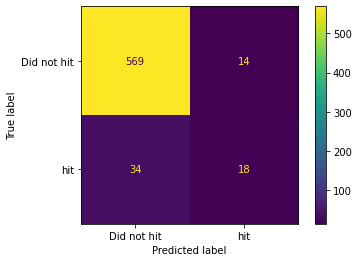

In [439]:
plot_confusion_matrix(clf_xgb2,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Did not hit","hit"])

In [440]:
X.columns

Index(['rb?', 'te?', 'age', 'max_pts', 'avg_pts', 'last_pts',
       '3_yr_trail_avg_fppg', 'injury_risk', 'last_yr_games_played',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr'],
      dtype='object')

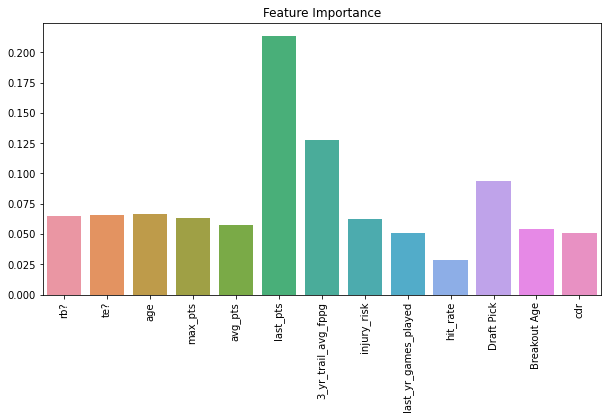

In [441]:
features = ['rb?', 'te?', 'age', 'max_pts', 'avg_pts', 'last_pts',
       '3_yr_trail_avg_fppg', 'injury_risk', 'last_yr_games_played',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr']
f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=features, y=clf_xgb2.feature_importances_)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

## Score 2022

In [442]:
df_2022_X = df_2022_X.drop(columns=['id'])

In [443]:
j_scores_2022 = pd.DataFrame(clf_xgb2.predict_proba(df_2022_X)).set_index(df_2022_X_id['id']).sort_values(
    1, axis=0, ascending=False)
j_scores_2022.to_csv('j_scores_2022_3.0.csv')

In [446]:
j_scores_2022.head(30)

,0,1
id,,
Tyreek Hill,0.040901,0.959099
Mark Andrews,0.085918,0.914082
Justin Jefferson,0.129772,0.870228
Diontae Johnson,0.171367,0.828633
Joe Mixon,0.181296,0.818704
Travis Kelce,0.200429,0.799571
Ezekiel Elliott,0.203035,0.796965
Ja'Marr Chase,0.223278,0.776722
James Conner,0.229050,0.770950


In [374]:
rb_adp = pd.read_csv('rb_adp.csv')
wr_adp = pd.read_csv('wr_adp.csv')
te_adp = pd.read_csv('te_adp.csv')

adp_df = rb_adp.append(wr_adp.append(te_adp))
adp_df

,Full Name,Position,ADP
0,A.J. Dillon,RB,72.1
1,Aaron Green,RB,-
2,Aaron Jones,RB,19.7
3,Aaron Ripkowski,RB,-
4,Abram Smith,RB,215.8
...,...,...,...
499,Zach Ertz,TE,109.8
500,Zach Gentry,TE,216
501,Zach Miller,TE,-
502,Zach Miller,TE,-


In [375]:
winner_df = j_scores_2022.reset_index().merge(adp_df[['Full Name','ADP']], left_on='id',right_on='Full Name')
winner_df.to_csv('winner_df_2.0.csv')

In [379]:
df_2022_id.to_csv('df_2022_id.csv')

## Backtest

### 2021

In [340]:
X_2021 = df_2021.drop(columns=['y'])
X_2021

,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr
0,1,0,23.1,40.2996,40.299600,40.2996,3.663600,0.687500,11.0,0.000000,2.30,19.3,34.8
1,1,0,26.5,315.2000,206.425150,258.9006,15.123225,0.850000,14.0,0.500000,5.39,18.8,47.0
3,1,0,36.2,260.8000,117.199886,124.4992,9.697314,0.718750,16.0,0.142857,1.07,19.5,42.7
8,1,0,26.8,171.0000,84.274975,21.0999,8.333325,0.578125,3.0,0.000000,5.34,19.0,29.9
9,1,0,22.9,86.8998,77.899900,86.8998,5.992300,0.812500,13.0,0.000000,3.38,19.2,28.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,0,1,28.4,161.0000,88.080100,128.2005,6.229340,0.864583,15.0,0.000000,4.12,22.7,15.6
1243,0,1,28.6,124.5000,40.216667,41.9000,3.748333,0.562500,10.0,0.000000,3.21,20.9,11.5
1248,0,1,24.9,73.8000,56.833600,61.1008,8.339600,0.500000,16.0,0.000000,4.20,NaN,10.3
1251,0,1,30.5,280.0000,181.700071,77.5005,12.392214,0.906250,11.0,0.428571,2.03,21.8,31.8


In [341]:
id_2021 = full_data[['Full Name','Fantasy Points Per Game (2021)']].dropna(subset=['Fantasy Points Per Game (2021)'])
id_2021

,Full Name,Fantasy Points Per Game (2021)
0,A.J. Dillon,10.9176
1,Aaron Jones,15.2667
3,Adrian Peterson,6.6500
8,Alex Collins,6.2545
9,Alexander Mattison,7.8688
...,...,...
1242,Tyler Higbee,9.8000
1243,Tyler Kroft,4.3667
1248,Will Dissly,3.3400
1251,Zach Ertz,10.6294


In [342]:
j_scores_2021 = pd.DataFrame(clf_xgb2.predict_proba(X_2021)).set_index(id_2021['Full Name']).sort_values(
    1, axis=0, ascending=False)
j_scores_2021.to_csv('j_scores_2021.csv')

In [343]:
j_scores_2021_check = j_scores_2021.reset_index()
j_scores_2021_check

,Full Name,0,1
0,D.K. Metcalf,0.148728,0.851272
1,Terry McLaurin,0.155249,0.844751
2,Justin Jefferson,0.166978,0.833022
3,Tyreek Hill,0.197524,0.802476
4,Alvin Kamara,0.197993,0.802007
...,...,...,...
545,Garrett Griffin,0.993949,0.006051
546,Trent Sherfield,0.993949,0.006051
547,Trenton Irwin,0.993949,0.006051
548,Eric Tomlinson,0.993949,0.006051


In [344]:
df_2021['id'] = id_2021['Full Name']
df_2021

,y,rb?,te?,age,max_pts,avg_pts,last_pts,3_yr_trail_avg_fppg,injury_risk,last_yr_games_played,hit_rate,Draft Pick,Breakout Age,cdr,id
0,0,1,0,23.1,40.2996,40.299600,40.2996,3.663600,0.687500,11.0,0.000000,2.30,19.3,34.8,A.J. Dillon
1,1,1,0,26.5,315.2000,206.425150,258.9006,15.123225,0.850000,14.0,0.500000,5.39,18.8,47.0,Aaron Jones
3,0,1,0,36.2,260.8000,117.199886,124.4992,9.697314,0.718750,16.0,0.142857,1.07,19.5,42.7,Adrian Peterson
8,0,1,0,26.8,171.0000,84.274975,21.0999,8.333325,0.578125,3.0,0.000000,5.34,19.0,29.9,Alex Collins
9,0,1,0,22.9,86.8998,77.899900,86.8998,5.992300,0.812500,13.0,0.000000,3.38,19.2,28.7,Alexander Mattison
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,0,0,1,28.4,161.0000,88.080100,128.2005,6.229340,0.864583,15.0,0.000000,4.12,22.7,15.6,Tyler Higbee
1243,0,0,1,28.6,124.5000,40.216667,41.9000,3.748333,0.562500,10.0,0.000000,3.21,20.9,11.5,Tyler Kroft
1248,0,0,1,24.9,73.8000,56.833600,61.1008,8.339600,0.500000,16.0,0.000000,4.20,NaN,10.3,Will Dissly
1251,0,0,1,30.5,280.0000,181.700071,77.5005,12.392214,0.906250,11.0,0.428571,2.03,21.8,31.8,Zach Ertz


In [345]:
j_scores_2021_check2 = j_scores_2021_check.merge(df_2021, left_on='Full Name', right_on='id',how='inner')
j_scores_2021_check2.to_csv('j_scores_2021_check.csv')

[CV] END gamma=0, learning_rate=0.25, max_depth=3, reg_lambda=9, scale_pos_weight=1; total time=   1.9s
[CV] END gamma=0, learning_rate=0.25, max_depth=3, reg_lambda=8, scale_pos_weight=1; total time=   2.0s
[CV] END gamma=0, learning_rate=0.3, max_depth=3, reg_lambda=7, scale_pos_weight=1; total time=   1.6s
[CV] END gamma=0, learning_rate=0.3, max_depth=3, reg_lambda=7, scale_pos_weight=1; total time=   1.7s
[CV] END gamma=0, learning_rate=0.3, max_depth=3, reg_lambda=8, scale_pos_weight=1; total time=   1.5s
[CV] END gamma=0, learning_rate=0.3, max_depth=3, reg_lambda=9, scale_pos_weight=1; total time=   1.2s
[CV] END gamma=0, learning_rate=0.3, max_depth=3, reg_lambda=8, scale_pos_weight=1; total time=   1.6s
[CV] END gamma=0, learning_rate=0.3, max_depth=3, reg_lambda=8, scale_pos_weight=1; total time=   1.5s
[CV] END gamma=0, learning_rate=0.3, max_depth=3, reg_lambda=9, scale_pos_weight=1; total time=   1.5s
[CV] END gamma=0, learning_rate=0.3, max_depth=3, reg_lambda=9, scale_p